# Fungsi Dasar

In [16]:
import re, unicodedata 

# === helpers ===
ZW_RE = re.compile(r"[\u200b-\u200d\u2060\ufeff\u00ad\u200e\u200f]")
NBSP_RE = re.compile(r"[\u00A0]")
MULTI_SPACE_RE = re.compile(r"\s{2,}")

# wiki image markup (case-insensitive)
WIKI_IMG_TOKEN_RE = re.compile(
    r"(?i)(?:\|\s*(?:jmpl|thumb|kiri|kanan|ka)\b|\b(?:jmpl|thumb|kiri|kanan|ka)\b\s*\|?)"
)
WIKI_IMG_SIZE_RE = re.compile(
    r"(?i)(?:\|\s*\d{2,4}(?:x\d{2,4})?px\b|\b\d{2,4}(?:x\d{2,4})?px\b\s*\|?)"
)
# sisa pipa/whitespace berlebih
PIPE_SPACES_RE = re.compile(r"(?:\s*\|\s*)+")

_UNITS = r"(km2|m2|km|m|cm|mm|kg|g|mg|t|l|ml|hz|khz|mhz|ghz|v|kv|w|kw|mw|a|ma|pa|kpa|mpa|bar|%)"

def normalize(q: str, lowercase: bool = True) -> str:
    if not q:
        return ""
    # -------- hapus sitasi [angka] --------
    q = re.sub(r"\[\d+\]", "", q)

    # -------- unicode & basic cleanup --------
    q = unicodedata.normalize("NFKC", q)
    q = ZW_RE.sub("", q)
    q = NBSP_RE.sub(" ", q)

    # -------- bersihkan artefak gambar wiki --------
    for _ in range(2):
        q = WIKI_IMG_TOKEN_RE.sub(" ", q)
        q = WIKI_IMG_SIZE_RE.sub(" ", q)
    q = PIPE_SPACES_RE.sub(" ", q)

    # -------- bersihkan artefak HTML/parsoid --------
    q = q.replace(r"\'", "'").replace(r'\"', '"')
    # A) buang tag italic <i ...> / </i> lengkap/terpenggal
    q = re.sub(r"(?i)(?<=\w)<\s*/?\s*i\b[^>]*>?(?=\w)", "", q)
    q = re.sub(r"(?i)<\s*/?\s*i\b[^>]*>?", " ", q)
    q = re.sub(r"(?i)<\s*/?\s*i\b[^\n<]*$", " ", q)

    # 1) hapus atribut data-parsoid (toleran kutip/penutup tidak lengkap)
    q = re.sub(
        r"\s*data-parsoid\s*=\s*(?:'[^']*'?|\"[^\"]*\"?|[^>\s]+)"," ",q,flags=re.IGNORECASE,
    )

    # C) HAPUS "dsr":[<deret angka/titik>] MESKI TANPA PENUTUP
    #    Contoh yang disapu: "dsr":[417424.3.3   atau   'dsr':[12.34
    q = re.sub(r'''(?i)["']dsr["']\s*:\s*\[\s*[0-9.,-]*''', " ", q)
    #    Tambahan: kalau key-nya (korup) tanpa kutip
    q = re.sub(r'''(?i)\bdsr\b\s*:\s*\[\s*[0-9.,-]*''', " ", q)

    # D) setelah dsr dihapus sering tersisa buntut seperti "}'>", buang:
    q = re.sub(r"\}\s*['\"]?\s*>", " ", q)          # }'>  atau }">  → spasi
    q = re.sub(r"(?<=\S)['\"]\s*>", " ", q)         # '>, "> setelah token lain → spasi
    # D) buang penutup yang menggantung (], }, ) + opsional ' atau " atau >) tepat sebelum huruf
    q = re.sub(r'(?:(?<=^)|(?<=\s))[\]\}\)]+(?:\s*["\']?\s*>?)?\s*(?=\w)', '', q)


    # 1) Hapus tag yang berada DI DALAM kata tanpa meninggalkan spasi
    q = re.sub(r"(?<=\w)</?\s*[a-zA-Z][^>]*>(?=\w)", "", q)

    # hapus tag HTML normal (misalnya <b>...</b>)
    q = re.sub(r"</?\s*[a-zA-Z][^>]*>", " ", q)

    # sambungkan huruf yang terpisah oleh tag patah /b>, /i>, /u>, /s>
    q = re.sub(r"(?<=\w)/[bius]>(?=\w)", "", q, flags=re.IGNORECASE)

    # hilangkan sisa /b> /i> /u> /s> sendirian
    q = re.sub(r"/[bius]>", " ", q, flags=re.IGNORECASE)

    # -------- lower & normalisasi tanda baca --------

    q = q.strip()
    q = (q.replace("“", "\"").replace("”", "\"")
           .replace("‘", "'").replace("’", "'")
           .replace("…", "...")
           .replace("–", "-").replace("—", "-")
           .replace("؟", "?").replace("．", ".").replace("؟", "?"))
    
    if lowercase:
        q = q.lower()

    # --- spasi + tanda baca (ramah tanda kurung) ---
    q = re.sub(r"\s+\?", "?", q)                            # hapus spasi sebelum '?'
    q = re.sub(r"\s+([,.:;!?/\)\-])", r"\1", q)             # hapus spasi sebelum tanda baca (kecuali '(')
    q = re.sub(r"([/(])\s+", r"\1", q)                      # hapus spasi setelah '/' dan '('
    q = re.sub(r"(?<=\w)\(", r" (", q)                      # pastikan ada spasi sebelum '(' bila didahului huruf/angka
    q = re.sub(r"\)(?=\w)", r") ", q)                       # pastikan ada spasi setelah ')' bila diikuti huruf/angka

    # rapikan spasi
    q = MULTI_SPACE_RE.sub(" ", q).strip()

    # normalisasi ringan kosakata/angka
    q = re.sub(r"\bdi\s+mana\b", "dimana", q)
    q = re.sub(r"\byg\b", "yang", q)
    q = q.replace("km²", "km2").replace("m²", "m2")
    # --- sisipkan spasi antara angka dan satuan ---

    # 12km -> 12 km, 5m2 -> 5 m2, 100% -> 100 %
    q = re.sub(rf"(?i)(\d)\s*({_UNITS})\b", r"\1 \2", q)

    # suhu: 50°C / 50 °C -> 50 °C  (pastikan ada spasi sebelum '°' dan antara ° dengan huruf)
    q = re.sub(r"(?i)(\d)\s*°\s*([cf])\b", r"\1 °\2", q)

    q = re.sub(r"\s*&\s*", " dan ", q)
    q = re.sub(r"\?{2,}", "?", q)

    # final cleanup
    q = MULTI_SPACE_RE.sub(" ", q).strip()
    return q

In [17]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def add_norm_and_stem(batch, column):
    qs = batch[column]
    norm = [normalize(x) for x in qs]

    stem = []
    for x in norm:
        s = stemmer.stem(x)
        # cek kata pertama ada akhiran -kah
        parts = s.split()
        if parts and parts[0].endswith("kah"):
            parts[0] = re.sub(r"kah$", "", parts[0])
        s = " ".join(parts).strip()
        stem.append(s)

    return {f"{column}_norm": norm, f"{column}_stem": stem}


# Membuat Korpus Panjang 180 Token nan Sudah Dinormalisasi

Gunanya untuk 
1) Pretraining model xRAG
2) Menyusun data negative passages dari bagian dataset yang belum punya

In [11]:
from datasets import load_dataset
from transformers import AutoTokenizer
import re

# Load corpus & tokenizer
corpus = load_dataset("castorini/mr-tydi-corpus", "indonesian", trust_remote_code=True)
corpus

DatasetDict({
    train: Dataset({
        features: ['docid', 'title', 'text'],
        num_rows: 1469399
    })
})

## EDA

nengok kasus dimana terdapat tag html atau yang mirip

In [ ]:
import re
import pandas as pd
from datasets import load_dataset

# Muat dataset (ganti sesuai punyamu)
ds = load_dataset("castorini/mr-tydi-corpus", "indonesian", split="train")

# Pola rawan
PATTERNS = {
    "slash_bius": re.compile(r"/[bius]>"),            # /b> /i> /u> /s>
    "broken_join": re.compile(r"\w/[bius]>\w"),       # d/b>e
    "data_parsoid": re.compile(r"data-parsoid\s*=", re.I),
    "dsr": re.compile(r'"dsr"\s*:\s*\[', re.I),
    "html_tag": re.compile(r"</?\s*[a-zA-Z][^>]*>"),  # <...> tag
}

# Simpan hasil match
records = []
for ex in ds.select(range(100000)):
    text = ex["text"]
    matches = {name: bool(pat.search(text)) for name, pat in PATTERNS.items()}
    if any(matches.values()):
        record = {
            "docid": ex["docid"],
            "title": ex["title"],
            "text_snippet": text,  # simpan potongan teks saja biar file tidak terlalu berat
        }
        record.update(matches)
        records.append(record)

# Buat DataFrame
df = pd.DataFrame(records)

# Simpan ke Excel
output_file = "mr_tydi_matches.xlsx"
df.to_excel(output_file, index=False)

print(f"Hasil disimpan ke {output_file}, total baris: {len(df)}")

Hasil disimpan ke mr_tydi_matches.xlsx, total baris: 97


## Normalisasi dan Chunking 180 Token

In [ ]:
from transformers import AutoTokenizer
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

MAX_TOK = 180
MIN_TOK = 50

# ---------- Normalisasi ----------

def normalize_batch(batch):
    batch["title"] = [normalize(t, lowercase=False) for t in batch["title"]]
    batch["text"] = [normalize(t, lowercase=False) for t in batch["text"]]
    return batch

# ---------- Chunking ----------
def chunk_batch(batch):
    out_docid, out_title, out_text = [], [], []
    for docid, title, text in zip(batch["docid"], batch["title"], batch["text"]):
        token_ids = t5_tokenizer.encode(text, add_special_tokens=False)
        if not token_ids:
            continue

        chunks = []
        start = 0
        while start < len(token_ids):
            end = min(start + MAX_TOK, len(token_ids))

            # pastikan akhir chunk di batas kata
            if end < len(token_ids):
                tok_str = t5_tokenizer.convert_ids_to_tokens([token_ids[end]])[0]
                while end > start and not tok_str.startswith("▁"):
                    end -= 1
                    tok_str = t5_tokenizer.convert_ids_to_tokens([token_ids[end]])[0]
                if end == start:
                    end = min(start + MAX_TOK, len(token_ids))

            chunks.append(token_ids[start:end])
            start = end

        # gabungkan segmen terakhir kalau <50 token
        if len(chunks) >= 2 and len(chunks[-1]) < MIN_TOK:
            chunks[-2].extend(chunks[-1])
            chunks = chunks[:-1]
        elif len(chunks) == 1 and len(chunks[0]) < MIN_TOK:
            chunks = []  # terlalu pendek → buang

        # simpan segmen valid
        for idx, seg in enumerate(chunks):
            if len(seg) < MIN_TOK:
                continue
            out_docid.append(f"{docid}_{idx}")
            out_title.append(title)
            out_text.append(t5_tokenizer.decode(seg, skip_special_tokens=True))

    return {"docid": out_docid, "title": out_title, "text": out_text}

# ---------- Pipeline ----------
# 1. Normalisasi dulu
normalized_corpus = corpus.map(
    normalize_batch,
    batched=True,
    desc="Normalizing title & text"
)

# 2. Chunking setelah normalisasi
split_dataset = normalized_corpus["train"].map(
    chunk_batch,
    batched=True,
    remove_columns=normalized_corpus["train"].column_names,
    desc="Chunking into <=180 tokens (word-aware) & merging last <50"
)

print(split_dataset)
print(split_dataset[0])

## Hapus Duplikasi

In [26]:
import pandas as pd

# ambil 10.000 baris pertama
sample = split_dataset.select(range(10000))

# konversi ke DataFrame untuk analisis cepat
df = pd.DataFrame(sample)

# cek duplikasi berdasarkan kolom 'text'
dup_mask = df.duplicated(subset=["text"], keep=False)
duplicates = df[dup_mask].sort_values(by="text")

# simpan hasil duplikat ke Excel
duplicates.to_excel("duplicates_first_10k.xlsx", index=False)

print(f"Jumlah duplikat (berdasarkan kolom text): {duplicates.shape[0]}")

Jumlah duplikat (berdasarkan kolom text): 38


In [28]:
import pandas as pd
from datasets import Dataset

# Konversi dulu ke pandas DataFrame
df = split_dataset.to_pandas()

# Hapus duplikasi berdasarkan kolom "text"
# keep='first' artinya baris pertama dipertahankan
df_nodup = df.drop_duplicates(subset=["text"], keep="first").reset_index(drop=True)

# Konversi kembali ke HuggingFace Dataset
split_dataset_nodup = Dataset.from_pandas(df_nodup)

print(f"Jumlah awal: {len(split_dataset)}, jumlah setelah buang duplikat: {len(split_dataset_nodup)}")


Jumlah awal: 1588236, jumlah setelah buang duplikat: 1521373


## Push ke Huggingface (Tanpa Pembagian Split)

In [29]:
# pip install datasets huggingface_hub

from datasets import DatasetDict
from huggingface_hub import HfApi, HfFolder
from datetime import datetime

# ====== asumsikan split_dataset sudah ada dari langkahmu sebelumnya ======
# split_dataset = normalized_corpus["train"].map(...)

# Bungkus ke DatasetDict agar rapi (boleh tambah 'validation'/'test' kalau ada)
split_dataset_dict = DatasetDict({"train": split_dataset})

# ====== Konfigurasi repo ======
repo_id = "khalidrizki/indonesian-wiki-chunked-180tok"   # ganti
private = False                                          # True kalau mau privat
token = HfFolder.get_token()
api = HfApi()

# 1) Buat repo (jika belum ada)
api.create_repo(
    repo_id=repo_id,
    repo_type="dataset",
    private=private,
    exist_ok=True,
    token=token,
)

# 2) Push dataset
split_dataset_dict.push_to_hub(
    repo_id=repo_id,
    private=private,
)

# 3) Siapkan README (dataset card)
readme = f"""# mr-tydi-indonesian-chunked-180tok

Hasil preprocessing dari [`castorini/mr-tydi-corpus`](https://huggingface.co/datasets/castorini/mr-tydi-corpus) split **Indonesian**.

## Pipeline
1. **Normalisasi teks**
   - Bersihkan artefak Parsoid/markup wiki (mis. `data-parsoid`, `dsr`, tag HTML patah)
   - Normalisasi whitespace & tanda baca
2. **Chunking word-aware**
   - Tokenizer: **google/flan-t5-base** (SentencePiece)
   - Panjang segmen ≤ **180 token**
   - Pemotongan berhenti di **batas kata** (hindari potong subword di tengah)
   - Jika segmen terakhir < **50 token**, **digabung** ke segmen sebelumnya
3. **docid baru**
   - Format: `docidAsli#partisiOlehMrTydi_nomorSegmen` (mis. `12345#67_0`, `12345#67_1`, …)

## Statistik
- Dataset asli (train, ID): ≈ 1.47M dokumen
- Dataset hasil chunking: lebih besar (tergantung distribusi panjang)
- Panjang segmen: 50–180 token (bisa >180 bila segmen terakhir digabung)

## Contoh
```json
{{
  "docid": "12345#0_0",
  "title": "Dokar",
  "text": "Dokar, kendaraan dengan kuda sebagai penarik ..."
}}"""

Creating parquet from Arrow format: 100%|██████████| 795/795 [00:02<00:00, 283.55ba/s]
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Creating parquet from Arrow format: 100%|██████████| 795/795 [00:02<00:00, 315.18ba/s]
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Uploading the dataset shards: 100%|██████████| 2/2 [00:52<00:00, 26.10s/it]


## 180 Token Menurut Flan T5 itu Berapa Token Multilingual E5?

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np

# 1. Load dataset & tokenizer
corpus = load_dataset("khalidrizki/indonesian-wiki-chunked-180tok", split="train")
tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-base")

# 2. Ambil sampel 100.000 data secara acak
sampled = corpus.shuffle(seed=42).select(range(100_000))

# 3. Tokenisasi batch agar lebih cepat
def tokenize_batch(batch):
    tokens = tokenizer(batch["text"], truncation=False, padding=False)["input_ids"]
    return {"lengths": [len(t) for t in tokens]}

sampled = sampled.map(tokenize_batch, batched=True, batch_size=1000)

# 4. Hitung rata-rata panjang token
avg_length = np.mean(sampled["lengths"])
print(f"Rata-rata panjang token dari 100.000 sampel: {avg_length:.2f}")

Map: 100%|██████████| 100000/100000 [00:08<00:00, 11193.50 examples/s]

Rata-rata panjang token dari 100.000 sampel: 65.77


## Pembagian Split (Train dan Validasi)

In [ ]:
from datasets import load_dataset
import random
import numpy as np

# Load dataset
dataset = load_dataset("khalidrizki/indonesian-wiki-chunked-180tok", split="train")

# Ekstrak prefix sebelum '#'
def get_doc_prefix(example):
    return {"doc_prefix": example["docid"].split("#")[0]}

dataset = dataset.map(get_doc_prefix)

# Group dokumen unik
all_docs = list(set(dataset["doc_prefix"]))
random.seed(42)
random.shuffle(all_docs)

# Hitung target size
target_val_size = 7941

# Iteratif pilih dokumen sampai mendekati target
val_docs = []
val_count = 0
for d in all_docs:
    count_d = (np.array(dataset["doc_prefix"]) == d).sum()
    if val_count + count_d <= target_val_size:
        val_docs.append(d)
        val_count += count_d
    if val_count >= target_val_size:
        break

print(f"Validation rows: {val_count}, Target: {target_val_size}")

# Split dataset
val_dataset = dataset.filter(lambda x: x["doc_prefix"] in val_docs)
train_dataset = dataset.filter(lambda x: x["doc_prefix"] not in val_docs)

print(train_dataset)
print(val_dataset)

Validation rows: 7941, Target: 7941


Filter: 100%|██████████| 1588236/1588236 [01:11<00:00, 22218.61 examples/s]

Dataset({
    features: ['docid', 'title', 'text', 'doc_prefix'],
    num_rows: 1580295
})
Dataset({
    features: ['docid', 'title', 'text', 'doc_prefix'],
    num_rows: 7941
})


In [ ]:
from datasets import DatasetDict

# Gabungkan ke dalam DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "dev": val_dataset
})

dataset.push_to_hub("khalidrizki/indonesian-wiki-chunked-180tok-splitted")

# TyDi QA

## Khusus Data Question dan Answer (Tanpa Retrieval/Negative Passages)

Gabungkan semua split jadi 1

In [3]:
from datasets import load_dataset, concatenate_datasets

# Muat dataset
tydiqa_gold = load_dataset("khalidalt/tydiqa-goldp", "indonesian", trust_remote_code=True)

c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Gabungkan semua split di tydiqa_gold
tydiqa_gold_all = concatenate_datasets([tydiqa_gold[split] for split in tydiqa_gold.keys()])

In [5]:
tydiqa_gold_all

Dataset({
    features: ['id', 'language', 'document_title', 'passage_text', 'question_text', 'answers'],
    num_rows: 6267
})

In [6]:
from collections import Counter

# hitung frekuensi id
id_counts = Counter(tydiqa_gold_all["id"])

# ambil yang lebih dari 1
dupes = {k: v for k, v in id_counts.items() if v > 1}

print(f"Jumlah id unik: {len(id_counts)}")
print(f"Jumlah id duplikat: {len(dupes)}")

# kalau mau lihat contoh id duplikat
for k, v in list(dupes.items())[:10]:
    print(k, "->", v)


Jumlah id unik: 6267
Jumlah id duplikat: 0


Rename kolom question pada tydiqa menjadi query

In [7]:
tydiqa_gold_all = tydiqa_gold_all.rename_column("question_text", "question")

Normalisasi dan buat kolom question_stem, yakni query yang sudah di-stemming. Ini gunanya untuk memudahkan membuang duplikasi

In [8]:
tydiqa_gold_all = tydiqa_gold_all.map(
    add_norm_and_stem, 
    batched=True, 
    fn_kwargs={"column": "question"}   # sesuaikan dengan nama kolom di tydiqa_gold_all
)
tydiqa_gold_all

Map: 100%|██████████| 6267/6267 [09:36<00:00, 10.87 examples/s]


Dataset({
    features: ['id', 'language', 'document_title', 'passage_text', 'question', 'answers', 'question_norm', 'question_stem'],
    num_rows: 6267
})

Dengan melakukan inspeksi manual, dari baris yang question_stem nya terduplikasi, sudah ditentukan mana saja baris yang answer nya salah. 

Dengan demikian, baris-baris yang question_stem terduplikasi dan answer salah tersebut dihapus

In [9]:
row = tydiqa_gold_all.filter(lambda x: x['question']=='apakah bilangan ganjil?' and x['answers']['text'][0]=='t dibuktikan bahwa bilangan ganjil')
row

Filter: 100%|██████████| 6267/6267 [00:00<00:00, 23773.68 examples/s]


Dataset({
    features: ['id', 'language', 'document_title', 'passage_text', 'question', 'answers', 'question_norm', 'question_stem'],
    num_rows: 1
})

In [10]:
row['question_stem'][0]

'apa bilang ganjil'

In [11]:
row = tydiqa_gold_all.filter(lambda x: x['question_stem']=='apa bilang ganjil' and x['answers']['text'][0]=='t dibuktikan bahwa bilangan ganjil')
row

Filter:   0%|          | 0/6267 [00:00<?, ? examples/s]

Filter: 100%|██████████| 6267/6267 [00:00<00:00, 25532.10 examples/s]


Dataset({
    features: ['id', 'language', 'document_title', 'passage_text', 'question', 'answers', 'question_norm', 'question_stem'],
    num_rows: 1
})

In [12]:
# ====== 2) Daftar pasangan dari Excel (sudah dituliskan ulang ke kode) ======
EXCEL_PAIRS = [
    ("apa bilang ganjil", "t dibuktikan bahwa bilangan ganjil"),
    ('apa definisi dari budaya', 'cara hidup yang berkembang, dan dimiliki bersama oleh sebuah kelompok orang, dan diwariskan dari generasi ke generasi'),
    ('apa erti pasar dalam ilmu ekonomi', 'empat bertemunya penjual dan pembeli. Transaksi jual-beli yang terjadi tidak selalu memerlukan lokasi fisik'),
    ('apa ibukota israel', 'Yerusalem'),
    ('apa ibukota jerman', 'Jerman Timur memilih Berlin Timur sebagai ibukota, sedangkan Jerman Barat memilih Bonn'),
    ('apa itu dna', '"dsr":[417,424,3,3]}\'>n</b>ucleic a</b>cid), adalah sejenis biomolekul yang menyimpan dan menyandi instruksi-instru'),
    ('apa itu manga', 'komik yang dibuat di Jepang, kata tersebut digunakan khusus untuk membicarakan tentang komik Jepang, sesuai dengan gaya yang dikembangkan di Jepang pada akhir abad ke-19'),
    ('apa itu rna', 'molekul polimer yang terlibat dalam berbagai peran biologis dalam mengkode, dekode, regulasi, dan ekspresi gen'),
    ('apa mata uang israel', 'Shekel baru Israel'),
    ('apa nama ibukota israel', 'Yerusalem'),
    ('apa nama ibukota jerman', 'Jerman Timur memilih Berlin Timur sebagai ibukota, sedangkan Jerman Barat memilih Bonn'),
    ('apa nama mata uang israel', 'Shekel baru Israel'),
    ('apa warna bendera jepang', '6.2R 4/15.2 untuk merah dan N9.2 untuk putih'),
    ('apa yang maksud dengan budaya', 'suatu cara hidup yang berkembang, dan dimiliki bersama oleh sebuah kelompok orang, dan diwariskan dari generasi ke generasi'),
    ('apa yang maksud dengan monarki', 'merupakan sejenis pemerintahan yang dipimpin oleh seorang penguasa monarki'),
    ('apa yang maksud dengan surah makkiyah', 'yat-ayat yang turun sebelum Rasulullah SAW hijrah ke Madinah'),
    ('apa yang maksud dengan zaman meiji', 'salah satu nama zaman pemerintahan kaisar Jepang sewaktu Kaisar Meiji memerintah Jepang, sesudah tahun Keiō(慶応) dan sebelum zaman zaman Taishō(大正'),
    ('berapa luas danau toba', '100 kilometres (62 miles), lebar 30 kilometres (19mi), dan kedalaman 505 metres'),
    ('berapa luas jakarta timur', '187,75km² (menurut Pemerintah Kota Administrasi Jakarta Timur)[1], atau seluas 188,19km² (menurut Badan Perencanaan Pembangunan Daerah Khusus Ibu Kota Jakarta)'),
    ('berapa luas jerman', '357,021km'),
    ('berapa luas kolombia', "828,660km² dan yang kedua yang terbentuk oleh pegunungan Andes dan lempeng Llanos yang berbagi bersama Venezuela dengan area seluas 1'143,748km²"), 
    ('berapa luas kota lampung', '35.376,50km²'),
    ('berapa luas kuasa sultan mataram', 'Jawa dan sekitarnya, termasuk Madura'),
    ('berapa luas negara israel',	'27.799km2'),
    ("berapa luas papua","808.105km persegi"),
    ('berapa luas pulau jawa','160 juta'),
    ('berapa luas singapura', '5,815km'),
    ('berapa luas sulawesi selatan','45.764,53'),
    ('berapa panjang sungai kuning'	,'40km'),
    ('dari mana asal suku sunda','bagian barat pulau Jawa, Indonesia'),
    ("kapan dinasti tang diri","618"),
    ("kapan internet pertama masuk ke indonesia","1994"),
    ("kapan perintah orde baru mulai","1966"),
    ("kapan pt kereta api indonesia diri","Mei 2010"),
    ("kapan pt kereta api indonesia diri","17 Juni 1864"),
    ("kapan radio pertama kali cipta","Guglielmo Marconi"),
    ("kapan universitas indonesia diri","1955"),
    ("mana letak jam gadang","kota Bukittinggi, Sumatera Barat, Indonesia"),
    ("mana letak jepang","ujung barat Samudra Pasifik, di sebelah timur Laut Jepang, dan bertetangga dengan Republik Rakyat Tiongkok, Korea, dan Rusia"),
    ("mana letak mesir","antara garis lintang 22 ° dan 32 ° N, dan garis bujur 25 ° dan 35 ° E"),
    ("mana letak polandia","Eropa Tengah yang berbatasan dengan Jerman di sebelah barat Perbatasan Oder-Neisse, Ceko, dan Slowakia di sebelah selatan, Rusia (Kaliningrad), Lituania di sebelah timur laut dan Belarus serta Ukraina di sebelah barat (Garis Curzon)"),
    ("siapa diri dinasti han timur","Liu Bang"),
    ("siapa diri toyota motor corporation","Toyoda"),
    ("siapa nama kaisar pertama dinasti ming","Zhu Yuanzhang"),
    ("siapa yang cipta wiracarita mahabharata","Begawan Byasa atau Vyasa"), 
    ("apa erti dari digital", "penggambaran dari suatu keadaan bilangan yang terdiri dari angka 0 dan 1 atau off dan on (bilangan biner)"),
    ("berapa luas jambi", "53.435 km2"),
    ("kapan sultan utsmaniyah diri", "bawa"),
    ("apa itu dvd", "cakram padat yang dapat digunakan untuk menyimpan data, termasuk film dengan kualitas video dan audio yang lebih baik dari kualitas VCD"),
    ("apa nama ibukota provinsi sulawesi utara", "kota Manado"), 
    ("apa nama mata uang korea utara", "Won"), 
    ("berapa luas samudera atlantik", "106.450.000km²"),
    ("mana letak danau toba", "kaldera Gunung Berapi Super")
]

# Ubah ke set untuk lookup cepat; trimming spasi di kiri/kanan biar "persis" tapi toleran spasi ekstra
PAIRS_SET = set((qs.strip(), ans.strip()) for qs, ans in EXCEL_PAIRS)

# ====== 3) Hapus baris di tydiqa_gold_all yang match kombinasi (question_stem, answers.text) ======
# Asumsi: kolom 'question_stem' SUDAH ada di tydiqa_gold_all
def _should_keep(example):
    qstem = (example.get('question_stem') or "").strip()
    texts = example.get('answers', {}).get('text', []) or []
    # hapus baris bila ADA salah satu jawaban yang match persis
    for t in texts:
        if (qstem, (t or "").strip()) in PAIRS_SET:
            return False
    return True

before_n = len(tydiqa_gold_all)
filtered_train = tydiqa_gold_all.filter(_should_keep)
after_n = len(filtered_train)
removed = before_n - after_n

print(f"Rows before: {before_n} | after: {after_n} | removed: {removed}")

# (Opsional) laporan pasangan Excel yang tidak ketemu sama sekali di dataset
# Kita cek apakah ada contoh yang match; kalau tidak ada, kita laporkan
def _has_match(example):
    qstem = (example.get('question_stem') or "").strip()
    texts = example.get('answers', {}).get('text', []) or []
    out = []
    for t in texts:
        key = (qstem, (t or "").strip())
        if key in PAIRS_SET:
            out.append(key)
    return {"_hits": out}

hits_ds = tydiqa_gold_all.map(_has_match, batched=False)
found_pairs = set()
for row in hits_ds:
    for h in row.get("_hits", []):
        found_pairs.add(tuple(h))

not_found = PAIRS_SET - found_pairs
if not_found:
    print("\nPairs from Excel NOT FOUND in dataset:")
    for qs, ans in sorted(not_found):
        print(f"- question_stem={qs!r} | answers.text={ans!r}")

# Commit hasil filter
tydiqa_gold_all_dupe_wo_bad_labels = filtered_train
tydiqa_gold_all_dupe_wo_bad_labels

Filter: 100%|██████████| 6267/6267 [00:00<00:00, 23130.82 examples/s]


Rows before: 6267 | after: 6206 | removed: 61


Map: 100%|██████████| 6267/6267 [00:01<00:00, 5367.56 examples/s]


Dataset({
    features: ['id', 'language', 'document_title', 'passage_text', 'question', 'answers', 'question_norm', 'question_stem'],
    num_rows: 6206
})

Ekstrak jawaban dari yang awalnya berada pada answers.text menjadi answer saja

In [13]:
def extract_text(example):
    example["answer"] = example["answers"]["text"]  # Ambil hanya bagian text, start_byte dan limit_byte dibuang saja
    return example

tydiqa_gold_all_dupe_wo_bad_labels = tydiqa_gold_all_dupe_wo_bad_labels.map(extract_text)
tydiqa_gold_all_dupe_wo_bad_labels = tydiqa_gold_all_dupe_wo_bad_labels.remove_columns(["language", "answers"])

Map: 100%|██████████| 6206/6206 [00:01<00:00, 4896.57 examples/s]


In [14]:
def passage_miss_answer(example):
    passage = example["passage_text"]
    answers = example["answer"] or []  # list of string
    
    # True kalau tidak ada satu pun jawaban yang muncul di passage_text
    return not any(ans in passage for ans in answers)
tydi_miss = tydiqa_gold_all_dupe_wo_bad_labels.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 6206/6206 [00:00<00:00, 27284.22 examples/s]

Jumlah baris yang miss: 0


Inspect lagi, apakah untuk kelompok question_stem sama (terduplikasi), apakah ada passage_text yang passage_text nya berbeda satu sama lain. Kalau berbeda, cek apakah jawaban berbeda juga. Jika jawaban berbeda, cari baris yang jawabannya benar dan sesuai dengan passage_text. Jawaban yang salah kemudian dihapus. Pencarian jawaban salah dilakukan dengan manual.

In [ ]:
# import pandas as pd

# # pastikan kolom yang dibutuhkan ada
# required_cols = {"question_stem", "document_title", "passage_text"}
# missing = required_cols - set(tydiqa_gold_all_dupe_wo_bad_labels.column_names)
# assert not missing, f"Kolom hilang: {missing}"

# # ke pandas untuk analisis cepat
# df = tydiqa_gold_all_dupe_wo_bad_labels.to_pandas()

# # ambil hanya question_stem yang duplikat (>1 kemunculan)
# dup_keys = (
#     df.groupby("question_stem", dropna=False).size()
#       .reset_index(name="n")
#       .query("n > 1")["question_stem"]
# )

# dup_df = df[df["question_stem"].isin(dup_keys)].copy()

# # ringkasan per question_stem
# def _unique_list(s, k=3):
#     # ambil contoh unik maksimal k item untuk pratinjau
#     vals = pd.unique(s.dropna())
#     return list(vals[:k])

# summary = (
#     dup_df.groupby("question_stem", dropna=False)
#           .agg(
#               n_rows=("question_stem", "size"),
#               n_titles=("document_title", pd.Series.nunique),
#               n_passages=("passage_text", pd.Series.nunique),
#               titles_sample=("document_title", lambda s: _unique_list(s, k=3)),
#               passages_sample=("passage_text", lambda s: _unique_list(s, k=1)),
#           )
#           .reset_index()
# )

# summary["same_title"] = summary["n_titles"].eq(1)
# summary["same_passage"] = summary["n_passages"].eq(1)
# summary["all_same"] = summary["same_title"] & summary["same_passage"]

# # baris yang tidak konsisten (judul atau passage berbeda)
# conflicts = summary.query("~all_same").copy()

# print(f"Total question_stem duplikat: {len(summary)}")
# print(f"Grup konsisten (judul & passage sama semua): {summary['all_same'].sum()}")
# print(f"Grup konflik (judul/passage berbeda): {len(conflicts)}")

# # contoh menampilkan beberapa konflik
# if len(conflicts):
#     print("\n=== Contoh konflik (maks 5) ===")
#     for _, r in conflicts.head(5).iterrows():
#         print(f"- question_stem: {r['question_stem']!r} | n_rows={r['n_rows']}, "
#               f"n_titles={r['n_titles']}, n_passages={r['n_passages']}")
#         print(f"  titles_sample: {r['titles_sample']}")
#         print(f"  passages_sample: {r['passages_sample']}")
#         print("-"*60)

# # (Opsional) simpan hasil
# summary.to_excel("tydiqa_gold_dupe_groups_summary.xlsx", index=False)
# conflicts.to_excel("tydiqa_gold_dupe_groups_conflicts.xlsx", index=False)

Total question_stem duplikat: 224
Grup konsisten (judul & passage sama semua): 205
Grup konflik (judul/passage berbeda): 19

=== Contoh konflik (maks 5) ===
- question_stem: 'apa ibukota rusia' | n_rows=2, n_titles=1, n_passages=2
  titles_sample: ['Rusia']
  passages_sample: ['Sebagian besar jalur air Rusia sepanjang 102,000km (63,380mi) terdiri dari sungai atau danau alam. Ibukota Moskwa disebut sebagai "pelabuhan lima laut" karena memiliki 5 jalur air menuju Baltik, Laut Putih, Kaspia, Laut Azov dan Laut Hitam.']
------------------------------------------------------------
- question_stem: 'apa mata uang yang guna di jerman' | n_rows=2, n_titles=1, n_passages=2
  titles_sample: ['Mark Jerman']
  passages_sample: ['Peralihan dari mata uang resmi yang lama ke euro di Jerman berbeda dengan negara-negara Zona Euro lainnya. Di negara-negara lain, saat peralihan mata uang resmi lama dan euro beredar berdampingan selama dua bulan. Tetapi, di Jerman, koin dan uang kertas mark masih diterima

Penghapusan baris berdasarkan question_stem dan passage_text/answer yang salah. Baris berikut sudah diketahui query nya terduplikasi. Berhubung jawabannya pun salah, sekalian aja hapus dulu, biar nanti pas proses penghapusan query ga sengaja meninggalkan baris dengan answer yang salah

In [15]:
import numpy as np

# ====== daftar pasangan ======
Q_ANSWER_PAIRS = [
    ("apa yang maksud dengan uskup",
     "pimpinan Gereja setempat yang bernama Keuskupan dan merupakan bagian dari hierarki Gereja Katolik Roma setelah Sri Paus (Uskup Agung Roma) dan Kardinal"),
    ("berapa lama kaisar romawi kuasa", "27 SM sampai 284 M"),
    ("berapa luas korea selatan", "99.274km2"),
    ("berapa luas negara jepang", "377.835km²"),
]

Q_PSGTEXT_STARTSWITH_PAIRS = [
    ("kapan internet masuk ke indonesia pertama kali",
     "Sejarah internet Indonesia dimulai pada awal tahun 1990-an."),
    ("kapan komputer pertama kali cipta",
     "Sebelum Internet muncul, telah ada beberapa sistem komunikasi yang berbasis digital"),
]

# Lookup cepat
ANSWER_SET = set((q.strip(), a.strip()) for q, a in Q_ANSWER_PAIRS)
PFX_LIST  = [(q.strip(), pfx.strip()) for q, pfx in Q_PSGTEXT_STARTSWITH_PAIRS]

def _iter_answers(val):
    """Yield jawaban sebagai string-strip, terlepas val= str / list / tuple / np.ndarray / None."""
    if val is None:
        return
    if isinstance(val, (list, tuple, np.ndarray)):
        for x in val:
            if x is None:
                continue
            yield str(x).strip()
    else:
        yield str(val).strip()

def _should_drop(example):
    qstem = (example.get("question_stem") or "").strip()
    psg   = (example.get("passage_text") or "").strip()

    # Rule 1: (question_stem, answer) exact match
    for a in _iter_answers(example.get("answer")):
        if (qstem, a) in ANSWER_SET:
            return True

    # Rule 2: (question_stem, passage_text startswith prefix)
    for q, pfx in PFX_LIST:
        if qstem == q and psg.startswith(pfx):
            return True

    return False

# === Flag → filter ===
before_n = len(tydiqa_gold_all_dupe_wo_bad_labels)

flagged = tydiqa_gold_all_dupe_wo_bad_labels.map(
    lambda ex: {"_drop": _should_drop(ex)}, batched=False
)

removed_rows = flagged.filter(lambda ex: ex["_drop"])
kept         = flagged.filter(lambda ex: not ex["_drop"]).remove_columns(["_drop"])

after_n   = len(kept)
removed_n = before_n - after_n
print(f"Rows before: {before_n} | after: {after_n} | removed: {removed_n}")

# Commit hasil bersih kembali ke variabel asal (kalau diinginkan)
tydiqa_gold_all_dupe_wo_bad_labels = kept

# (Opsional) simpan audit baris yang dihapus
# removed_rows.to_csv("tydiqa_removed_rows.csv")


Map:   0%|          | 0/6206 [00:00<?, ? examples/s]

Filter: 100%|██████████| 6206/6206 [00:00<00:00, 36517.44 examples/s]

Rows before: 6206 | after: 6200 | removed: 6


In [10]:
tydi_miss = tydiqa_gold_all_dupe_wo_bad_labels.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 6213/6213 [00:00<00:00, 18761.51 examples/s]

Jumlah baris yang miss: 0


Penghapusan duplikasi dengan menyisakan passage_text yang lebih pendek

In [16]:
import pandas as pd
from datasets import Dataset

# convert ke pandas
df = tydiqa_gold_all_dupe_wo_bad_labels.to_pandas()

# hitung panjang passage_text (kalau NaN → inf supaya tidak kepilih)
df["_passage_len"] = df["passage_text"].fillna("").str.len()

# untuk tiap question_stem, ambil index baris dengan passage_text terpendek
idx_min = df.groupby("question_stem")["_passage_len"].idxmin()

# ambil hanya baris-baris itu
df_kept = df.loc[idx_min].reset_index(drop=True)

print(f"Before: {len(df)} | After: {len(df_kept)} | Removed: {len(df) - len(df_kept)}")

# buang kolom bantu
df_kept = df_kept.drop(columns=["_passage_len"])

# convert balik ke HuggingFace Dataset
tydiqa_gold_all_dupe_wo_bad_labels = Dataset.from_pandas(df_kept)
tydiqa_gold_all_dupe_wo_bad_labels

Before: 6200 | After: 5928 | Removed: 272


Dataset({
    features: ['id', 'document_title', 'passage_text', 'question', 'question_norm', 'question_stem', 'answer'],
    num_rows: 5928
})

In [17]:
tydi_miss = tydiqa_gold_all_dupe_wo_bad_labels.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5928/5928 [00:00<00:00, 53152.16 examples/s]

Jumlah baris yang miss: 0


Isi text dari split dev dan test mr_tydi

In [18]:
corpus = load_dataset("castorini/mr-tydi-corpus", "indonesian", trust_remote_code=True)

In [19]:
mr_tydi = load_dataset("castorini/mr-tydi", "indonesian")

# Buat dictionary {docid: (title, text)} untuk pencarian cepat
corpus_dict = {row["docid"]: (row["title"], row["text"]) for row in corpus["train"]}

# Fungsi untuk melengkapi positive_passages dalam dataset mr_tydi
def fill_passage_info(example):
    for passage in example["positive_passages"]:
        docid = passage["docid"]
        if docid in corpus_dict:  # Cek apakah docid ada di corpus
            passage["title"], passage["text"] = corpus_dict[docid]
    
    return example

# Terapkan fungsi untuk melengkapi positive_passages di split 'dev' dan 'test'
mr_tydi["dev"] = mr_tydi["dev"].map(fill_passage_info)
mr_tydi["test"] = mr_tydi["test"].map(fill_passage_info)

# Cek hasilnya
print(mr_tydi["dev"][0])
print(mr_tydi["test"][0])

{'query_id': '3', 'query': 'Dimana James Hepburn meninggal?', 'positive_passages': [{'docid': '2386357#15', 'text': 'Dia dipenjarakan di Puri Dragsholm, 75 kilometer Kopenhagen. Dia ditahan dalam apa yang dikatakan sebagai kondisi yang mengerikan. Dia meninggal pada bulan April 1578.[8][10]', 'title': 'James Hepburn'}], 'negative_passages': []}
{'query_id': '6148', 'query': 'Siapakah yang menemuka benua Amerika ?', 'positive_passages': [{'docid': '6874#1', 'text': "Kolumbus bukanlah orang pertama yang tiba di Amerika, yang ia dapati sudah diduduki. Ia juga bukan orang Eropa pertama yang sampai ke benua itu karena sekarang telah diakui secara meluas bahwa orang-orang Viking dari Eropa Utara telah berkunjung ke Amerika Utara pada abad ke 11 dan mendirikan koloni L'Anse aux Meadows untuk jangka waktu singkat. Terdapat perkiraan bahwa pelayar yang tidak dikenali pernah melawat ke Amerika sebelum Kolumbus dan membekalkannya dengan sumber untuk kejayaannya. Terdapat juga banyak teori mengena

In [20]:
# Gabungkan semua split di mr_tydi
mr_tydi_all = concatenate_datasets([mr_tydi[split] for split in mr_tydi.keys()])

Normalisasi dan stemming query mr_tydi

In [21]:
mr_tydi_all = mr_tydi_all.map(
    add_norm_and_stem, 
    batched=True, 
    fn_kwargs={"column": "query"}     
)

Map: 100%|██████████| 6955/6955 [01:05<00:00, 106.90 examples/s]


Join kedua dataset

In [22]:
import numpy as np

# 1) Bangun index dari mr_tydi_all: query_norm -> list kandidat mr
mr_index = {}  # query_norm -> [ {query_id, positive_passages_raw, negative_passages_raw, positives_norm:[...]} ]
for qnorm, qid, pos_list, neg_list in zip(
    mr_tydi_all["query_norm"],
    mr_tydi_all["query_id"],
    mr_tydi_all["positive_passages"],
    mr_tydi_all["negative_passages"],
):
    rec = {
        "query_id": qid,
        "positive_passages_raw": pos_list or [],
        "negative_passages_raw": neg_list or [],
        "positives_norm": []
    }
    # siapkan versi ternormalisasi utk pencocokan cepat
    for p in (pos_list or []):
        title = (p.get("title") or "")
        text  = (p.get("text")  or "")
        rec["positives_norm"].append({
            "docid": p.get("docid"),
            "title": title,
            "title_norm": normalize(title),
            "text": text,
            "text_norm": normalize(text),
        })
    mr_index.setdefault(qnorm, []).append(rec)

# 2) Map ke tiap baris tydiqa: tambahkan kolom hasil join
def attach_mr_match(example):
    qnorm = example.get("question_norm") or ""
    cands = mr_index.get(qnorm, [])

    title_norm = normalize(example.get("document_title") or "")
    psg_norm   = normalize(example.get("passage_text")   or "")

    # default (tidak ketemu query_norm)
    if not cands:
        return {
            "mr_query_id": None,
            "mr_docid": None,
            "mr_title": None,
            "mr_text": None,
            "mr_negative_passages": [],   # <- kolom yang kamu minta ikut dibawa
            "mr_query_norm_match": False, # hanya query_norm?
            "mr_pos_match": False,        # apakah positive_passages (title+text) match?
        }

    # ada kandidat dengan query_norm sama
    # coba cari positive yang match (title & text)
    for cand in cands:
        for pos in cand["positives_norm"]:
            if pos["title_norm"] == title_norm and pos["text_norm"] == psg_norm:
                return {
                    "mr_query_id": cand["query_id"],
                    "mr_docid": pos["docid"],
                    "mr_title": pos["title"],
                    "mr_text": pos["text"],
                    "mr_negative_passages": cand["negative_passages_raw"],  # ikutkan apa adanya
                    "mr_query_norm_match": True,
                    "mr_pos_match": True,
                }

    # tidak ada positive yang match; tetap pilih kandidat pertama agar negative_passages tetap terisi
    cand0 = cands[0]
    return {
        "mr_query_id": cand0["query_id"],
        "mr_docid": None,
        "mr_title": None,
        "mr_text": None,
        "mr_negative_passages": cand0["negative_passages_raw"],
        "mr_query_norm_match": True,
        "mr_pos_match": False,
    }

# 3) Terapkan ke dataset tydiqa (tanpa menduplikasi baris)
tydiqa_with_mr = tydiqa_gold_all_dupe_wo_bad_labels.map(
    attach_mr_match,
    batched=False,
    load_from_cache_file=False,
)

# (opsional) ringkas hasil
total = len(tydiqa_with_mr)
qnorm_hits = sum(1 for b in tydiqa_with_mr["mr_query_norm_match"] if b)
pos_hits   = sum(1 for b in tydiqa_with_mr["mr_pos_match"] if b)
print(f"Query-norm matched: {qnorm_hits}/{total}")
print(f"Positive-passage fully matched (title+text): {pos_hits}/{total}")

# hasil akhirnya: tydiqa_with_mr punya kolom tambahan:
# ['mr_query_id','mr_docid','mr_title','mr_text','mr_negative_passages','mr_query_norm_match','mr_pos_match']


Map: 100%|██████████| 5928/5928 [00:05<00:00, 1172.96 examples/s]

Query-norm matched: 5912/5928
Positive-passage fully matched (title+text): 5540/5928


In [23]:
tydi_miss = tydiqa_with_mr.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5928/5928 [00:01<00:00, 3485.28 examples/s]

Jumlah baris yang miss: 0


Buang baris yang tidak nemu pasangan di mr_tydi_all

In [24]:
import pandas as pd

# 1) ambil orphan (tidak ada pasangan query_norm di mr_tydi_all)
orphans = tydiqa_with_mr.filter(lambda ex: not ex["mr_query_norm_match"])
print(f"Jumlah orphan: {len(orphans)}")

# # convert ke pandas biar bisa dicek/ekspor
# orphans_df = orphans.to_pandas()
# orphans_df.to_excel("tydiqa_orphans.xlsx", index=False)
# print("File tydiqa_orphans.xlsx berhasil dibuat.")

# 2) buang orphan dari dataset utama
tydiqa_with_mr = tydiqa_with_mr.filter(lambda ex: ex["mr_query_norm_match"])
print(f"Sekarang tydiqa_with_mr berisi {len(tydiqa_with_mr)} baris (orphan sudah dihapus).")

Filter: 100%|██████████| 5928/5928 [00:01<00:00, 3489.71 examples/s]


Jumlah orphan: 16


Filter: 100%|██████████| 5928/5928 [00:01<00:00, 3577.80 examples/s]

Sekarang tydiqa_with_mr berisi 5912 baris (orphan sudah dihapus).


Inspeksi lebih dalam terkait teks passage

In [ ]:
import re
import pandas as pd
from datasets import Dataset

# pola 'jmpl|' toleran spasi & case-insensitive
JMPL_RE = re.compile(r"jmpl\s*\|", flags=re.IGNORECASE)

# 1) ambil baris yang mengandung 'jmpl|'
def has_jmpl(example):
    txt = example.get("passage_text") or ""
    return bool(JMPL_RE.search(txt))

jmpl_ds =  tydiqa_with_mr.filter(has_jmpl)
print(f"Baris yang mengandung 'jmpl|': {len(jmpl_ds)}")

# 2) tampilkan sampai 5 contoh (ke layar)
n_show = min(5, len(jmpl_ds))
if n_show > 0:
    print("\n=== Contoh passage dengan 'jmpl|' (maks 5) ===")
    for r in jmpl_ds.select(range(n_show)):
        print(f"id: {r.get('id')}")
        print(f"question_stem: {r.get('question_stem')}")
        print(f"document_title: {r.get('document_title')}")
        # tampilkan potongan teks agar mudah dibaca
        psg = (r.get('passage_text') or "").replace("\n", " ")
        print("passage_text (snippet):", psg[:400], "...")
        print("-" * 80)
else:
    print("Tidak ada 'jmpl|' yang ditemukan. Ambil 5 sampel acak untuk inspeksi manual.")
    n_show = min(5, len(tydiqa_with_mr))
    for r in tydiqa_with_mr.shuffle(seed=42).select(range(n_show)):
        print(f"id: {r.get('id')}")
        print(f"question_stem: {r.get('question_stem')}")
        print(f"document_title: {r.get('document_title')}")
        psg = (r.get('passage_text') or "").replace("\n", " ")
        print("passage_text (snippet):", psg[:400], "...")
        print("-" * 80)

# 3) simpan ke Excel untuk inspeksi lebih nyaman
#    - jika ada 'jmpl|', simpan contoh baris tersebut (maks 200 baris agar ringan)
#    - kalau tidak ada, simpan 200 sampel acak
# if len(jmpl_ds) > 0:
#     out_df = jmpl_ds.select(range(min(200, len(jmpl_ds)))).to_pandas()
#     out_path = "tydiqa_passages_with_jmpl.xlsx"
# else:
#     out_df = tydiqa_with_mr.shuffle(seed=42).select(range(min(200, len(tydiqa_with_mr)))).to_pandas()
#     out_path = "tydiqa_passages_sample.xlsx"

# out_df.to_excel(out_path, index=False)
# print(f"Disimpan ke: {out_path}")


Filter: 100%|██████████| 5908/5908 [00:02<00:00, 2847.97 examples/s]

Baris yang mengandung 'jmpl|': 0
Tidak ada 'jmpl|' yang ditemukan. Ambil 5 sampel acak untuk inspeksi manual.
id: -4133709973186485101-1
question_stem: kapan raja sriwijaya diri
document_title: Sriwijaya
passage_text (snippet): Bukti awal mengenai keberadaan kerajaan ini berasal dari abad ke-7; seorang pendeta Tiongkok dari Dinasti Tang, I Tsing, menulis bahwa ia mengunjungi Sriwijaya tahun 671 dan tinggal selama 6 bulan. Selanjutnya prasasti yang paling tua mengenai Sriwijaya juga berada pada abad ke-7, yaitu prasasti Kedukan Bukit di Palembang, bertarikh 682. ...
--------------------------------------------------------------------------------
id: 3098224921792818706-0
question_stem: siapa nama pimpin dalam gereja
document_title: Paus (Gereja Katolik)
passage_text (snippet): Paus (dari Dutch: paus; Latin: papa dari Greek: πάππας pappas, "ayah") adalah Uskup Roma dan pemimpin Gereja Katolik di seluruh dunia. Keutamaan Uskup Roma sebagian besar berasal dari peranannya dalam tradisi seba

In [ ]:
"""
Sampai tahap ini, sudah dilakukan:
1. Penggabungan split TyDi QA
2. Normalisasi dan stemming question
3. Penghapusan duplikasi

4. Mengisi psg positif dari split dev dan test Mr. TyDi
5. Penggabungan split Mr. TyDi
6. Normalisasi dan stemming question Mr. TyDi

7. Join TyDi QA dengan Mr. TyDi
"""
tydiqa_with_mr.save_to_disk("tydiqa_with_mr")

Saving the dataset (1/1 shards): 100%|██████████| 5912/5912 [00:00<00:00, 23094.95 examples/s]


In [ ]:
from datasets import load_from_disk
tydiqa_with_mr = load_from_disk("tydiqa_with_mr")
tydiqa_with_mr

Dataset({
    features: ['id', 'document_title', 'passage_text', 'query', 'question_norm', 'question_stem', 'answer', 'mr_query_id', 'mr_docid', 'mr_title', 'mr_text', 'mr_negative_passages', 'mr_query_norm_match', 'mr_pos_match'],
    num_rows: 5912
})

memperbaiki pasangan query dan answer

In [26]:
rows_to_update = [
    {
        "q_to_find": "dimanakah Dr. Ernest François Eugène Douwes Dekker meninggal?", 
        "new_answer" : "TMP Cikutra, Bandung",
    }, 
    {
        "q_to_find": "Dimanakah Kucing Pallas pertama kali ditemukan ?", 
        "new_answer": "Asia Tengah wilayah Mongolia, Cina dan Dataran Tinggi Tibet",
    }, 
    {
        "q_to_find": "dimanakah Joseph Patrick \"Joe\" Kennedy dilahirkan?", 
        "new_q" : "Kapan Joseph Patrick \"Joe\" Kennedy dilahirkan?",
        "new_answer" : "1888",
    }, 
    {
        "q_to_find": "Dimanakah produksi film pertama dilakukan ?", 
        "new_q" : "Kapan pemutaran film pertama dilakukan ?",
    }, 
    {
        "q_to_find": "dimanakah Fiber optik pertama kali diciptakan?", 
        "new_q" : "Kapan film mulai diproduksi menggunakan videotape?",
    }, 
    {
        "q_to_find": "Dimana Muhammad bin ʿAbd al-Wahhāb dilahirkan?", 
        "new_answer" : "kampung Uyainah (Najd)",
    }, 
    {
        "q_to_find": "Dimanakah balap sepeda professional Eropa pertama diadakan ?", 
        "new_q" : "Sejak kapan Tour of Flanders diadakan?",
    }, 
    {
        "q_to_find": "Dimana Benito Mussolini meninggal ?", 
        "new_answer" : "Giulino di Mezzegra",
    }, 
    {
        "q_to_find": "dimanakah kanon Muratori ditemukan?", 
        "new_q" : "Kapan Papirus 46 diperkirakan dibuat?",
    }, 
    {
        "q_to_find": "Dimana Friedrich Nietzsche meninggal?", 
        "new_q" : "Kapan Friedrich Nietzsche meninggal?",
    }, 
    {
        "q_to_find": "Dimana al-Ikhshīd lahir ?", 
        "new_answer" : "Baghdad",
    }, 
    {
        "q_to_find": "Dimana Pangeran Xia meninggal?", 
        "new_q" : "Pada tahun berapa Dou Jiande meninggal?",
    }, 
    {
        "q_to_find": "Dimana Robert I Estienne lahir?", 
        "new_q" : "Kapankah Robert I Estienne lahir?",
    }, 
    {
        "q_to_find": "Dimana Paus Yohanes XXIII meninggal?", 
        "new_q" : "Kapan Paus Yohanes XXIII meninggal?",
    }, 
    {
        "q_to_find": "dimanakah Napoleon meninggal?", 
        "new_q" : "Tanggal berapa Napoleon meninggal?",
    }, 
    {
        "q_to_find": "Kapan Utsmani berdiri ?", 
        "new_answer" : "1299",
    }, 
    {
        "q_to_find": "Kapan CIA dibentuk ?", 
        "new_q" : "Apa itu CIA?",
    }, 
    {
        "q_to_find": "kapankah Radio pertama kali diciptakan?", 
        "new_q" : "Siapa pencipta radio?",
    }, 
    {
        "q_to_find": "Kapan Mariah lahir ?", 
        "new_answer" : "27 Maret 1970",
    }, 
    {
        "q_to_find": "Kapan Kekaisaran Romawi mengalami masa jaya?", 
        "new_answer" : "Dua abad pertama kekaisaran",
    }, 
    {
        "q_to_find": "kapankah provinsi Sulawesi Barat diresmikan?", 
        "new_q" : "Berapa luas provinsi Sulawesi Barat?",
    }, 
    {
        "q_to_find": "Kapan Gereja Asiria Timur didirikan?", 
        "new_q" : "Siapa yang mendirikan Gereja Asiria Timur?",
    }, 
    {
        "q_to_find": "kapankah Windows XP pertama kali diciptakan?", 
        "new_q" : "kapankah Windows XP pertama kali dirilis?",
        "new_answer" : "25 Oktober 2001",
    }, 
    {
        "q_to_find": "Kapan musik rock pertama kali masuk ke Indonesia?", 
        "new_q" : "Siapa yang dipercaya lebih dulu memperkenalkan musik beraliran rock?",
    }, 
    {
        "q_to_find": "Kapan Sayf Allāh al-Maslūl lahir ?", 
        "new_answer" : "585",
    }, 
    {
        "q_to_find": "Kapan Katherine Anne lahir ?", 
        "new_q" : "Dimana Katie Couric lahir?",
    }, 
    {
        "q_to_find": "kapankah ilmu kimia dipelajari oleh manusia?", 
        "new_q" : "Reaksi kimia apa yang sudah diketahui sejak dahulu kala?",
        "new_answer" : "pembakaran, fermentasi, dan reduksi dari bijih menjadi logam",
    }, 
    {
        "q_to_find": "Kapan Ernest Miller Hemingway pertama kali menulis novel?", 
        "new_q" : "Apa judul buku pertama Ernest Hemingway yang diterbitkan?",
    }, 
    {
        "q_to_find": "Kapankah Kesultanan Utsmaniyah berdiri ?", 
        "new_answer" : "1299",
    }, 
    {
        "q_to_find": "Berapa luas wilayah kekuasan Romawi pada zaman dahulu ?", 
        "new_q" : "Kekaisaran Romawi menguasai daerah sekitar apa?",
    }, 
    {
        "q_to_find": "Berapa luas kekuasaan Kerajaan Sriwijaya?", 
        "new_q" : "Wilayah mana saja yang dikuasai oleh Sriwijaya?",
    }, 
    {
        "q_to_find": "Berapa luas kekuasaan kerajaan Banjar?", 
        "new_q" : "Apa nama kerajaan pertama di Kalimantan bagian selatan menurut mitologi",
        "new_answer" : "Kerajaan Nan Sarunai",
    }, 
    {
        "q_to_find": "berapakah jumlah album Tantowi Yahya?", 
        "new_q" : "Apa album kedua Tantowi Yahya?",
        "new_answer" : "Southern Dreams",
    }, 
    {
        "q_to_find": "Berapa luas kekuasaan dinasti Utsmaniyah ?", 
        "new_q" : "Kesultanan Utsmaniyah berkuasa atas wilayah luas di mana?",
    }, 
    {
        "q_to_find": "berapakah jenis senjata mesin yang digunakan di PD II?", 
        "new_q" : "Senapan apa yang digunakan di banyak negara Persemakmuran Inggris pasca perang dunia II?",
        "new_answer" : "Bren",
    }, 
    {
        "q_to_find": "Berapa luas daerah kekuasan Turki Seljuk ?", 
        "new_q" : "Sejauh mana luas daerah kekuasan Turki Seljuk ?",
    }, 
    {
        "q_to_find": "Berapa luas kerajaan Banjar?", 
        "new_q" : "Sejauh mana luas kerajaan Banjar?",
    }, 
    {
        "q_to_find": "Berapa luas wilayah kekaisaran Romawi?", 
        "new_q" : "Di wilayah mana saja Kekaisaran Romawi berkuasa?",
    }, 
    {
        "q_to_find": "Berapa luas kekuasaan Kesultanan Utsmaniyah?", 
        "new_q" : "Di daerah mana kekuasaaan Kesultanan Utsmaniyah?",
    }, 
    {
        "q_to_find": "Siapakah yang mendirikan Sekolah Tinggi Agama Islam Balai Selasa?", 
        "new_answer" : "M. Dinar Moely dibantu Sekretaris Muchtar Komar dan Bendahara Ny. Martini",
    }, 
    {
        "q_to_find": "Siapakah yang menemukan alarm pertama kali ?", 
        "new_passage_text" : "Alarm | Awalnya, penemuan baterai pada tahun 1799 dan telegraf pada tahun 1841 secara umum mengubah dunia dan menginspirasi para penyuka hobi, ahli listrik dan ilmuwan yang ada di seluruh dunia untuk melihat dan memperdalam ilmu komunikasi. Tidak lama setelah telegraf diperkenalkan, seorang dokter muda yang kaya bernama William Channing membuat sebuah sistem dari pemerintah untuk menyalurkan sinyal alarm kebakaran kepada stasiun pemadam kebakaran yang ada di sekeliling kota Boston, Amerika Serikat. Menggunakan morse yang ditemukan oleh Samuel Morse dalam sistem telegram yang memadukan kode dengan teknologi, Channing membuat rencana elaborasi untuk menyalurkan sinyal dari pusat sistem pemerintah menuju stasiun pemadam kebakaran untuk memberitahu titik lokasi terjadinya kebakaran. Rencana Channing memiliki masalah karena besar bunyi alarm tidak dapat dikendalikan dari stasiun pemadam kebakaran."""
    }, 
    {
        "q_to_find": "Siapakah yang menemukan kamera?", 
        "new_q" : "Pada tahun berapa foto pertama di dunia dihasilkan?",
    }, 
    {
        "q_to_find": "apakah penyebab Uni Soviet dibubarkan?", 
        "new_answer" : "kebijakan glasnost dan perestroika, tetapi justru memicu perpecahan di Uni Soviet",
    }, 
    {
        "q_to_find": "apakah penyebab utama kematian Fidiricu II?", 
        "new_q" : "Kapan wafatnya Fidiricu II?",
    }, 
    {
        "q_to_find": "Apakah penyebab utama Dinasti Ayyubiyyah runtuh?", 
        "new_q" : "Perjanjian antara Mamluk dan Ayyubiyah ditandatangani kapan?",
    }, 
    {
        "q_to_find": "Apakah kepanjangan dari DNA?", 
        "new_answer" : "deoxyribonucleic acid",
    }, 
    {
        "q_to_find": "Di hari apakah Amstel Gold Race diadakan pertama kali?",
        "new_q" : "Kapan Amstel Gold Race mulai tercatat dalam kalender resmi UCI?",
    }, 
    {
        "q_to_find": "Mengapa Kerajaan Joseon berakhir?", 
        "new_q" : "Kapan Kerajaan Joseon berakhir?",
    }, 
    {
        "q_to_find": "Dimana Gianfranco Chiarini belajar memasak?", 
        "new_answer" : "Instituto de Alta Gastronomia de Caracas",
    }, 
    {
        "q_to_find": "Apa penyebab utama runtuhnya kekaisaran Bizantium ?", 
        "new_answer" : "Perang Salib Keempat tahun 1204, ketika kekaisaran ini dibubarkan secara paksa",
    }, 
    {
        "q_to_find": "Apakah film pertama Alexa Ellesse Vega?", 
        "new_answer" : "Twister",
    }, 
    {
        "q_to_find": "kapankah Bebop mulai dipopulerkan?", 
        "new_q" : "Kapan genre musik hip hop mulai muncul di Amerika Serikat?",
    }, 
    {
        "q_to_find": "Apa definisi dari endokrinolog?", 
        "new_q" : "Apa definisi dari endokrinologi?",
    }, 
    {
        "q_to_find": "Berapa berat Mesin kepung?", 
        "new_q" : "Hingga berapa berat mesin kepung besar",
    }
]

In [27]:
from typing import List, Dict, Any

def apply_rows_updates(
    ds,
    rows_to_update: List[Dict[str, Any]],
    lowercase_norm: bool = True,
):
    """
    Terapkan banyak update berdasarkan q_to_find (dicocokkan via question_norm).
    Setiap item bisa berisi beberapa field opsional:
      {
        "q_to_find": str,               # WAJIB (akan dinormalisasi)
        "new_q": Optional[str],         # ubah query (+ regen question_norm & question_stem)
        "new_answer": Optional[str|list[str]],  # ubah kolom 'answer' (list[str]); sinkronkan answers['text'] jika ada
        "new_passage_text": Optional[str],      # ubah passage_text
      }
    """
    # Precompute mapping: find_norm -> payload perubahan
    fix_map = {}
    for row in rows_to_update:
        q_raw = row["q_to_find"]
        find_norm = normalize(q_raw, lowercase=lowercase_norm)
        payload = {}

        # new_q
        if "new_q" in row and row["new_q"] is not None:
            new_q = str(row["new_q"])
            new_norm = normalize(new_q, lowercase=lowercase_norm)
            new_stem = stemmer.stem(new_norm)
            payload.update({
                "new_q": new_q,
                "new_norm": new_norm,
                "new_stem": new_stem,
            })

        # new_answer
        if "new_answer" in row and row["new_answer"] is not None:
            na = row["new_answer"]
            if isinstance(na, (list, tuple)):
                new_answer = [str(x) for x in na]
            else:
                new_answer = [str(na)]
            payload["new_answer"] = new_answer

        # new_passage_text
        if "new_passage_text" in row and row["new_passage_text"] is not None:
            payload["new_passage_text"] = str(row["new_passage_text"])

        # Gabungkan jika ada beberapa entry dengan q_to_find sama (yang terakhir override)
        fix_map[find_norm] = payload

    # Flag baris yang kena perubahan dan terapkan
    def _apply(batch):
        qnorms = batch["question_norm"]
        has_answer_col = "answer" in batch
        has_answers_dict = "answers" in batch

        # siapkan output default (copy)
        out_query         = list(batch["question"])
        out_question_norm = list(batch["question_norm"])
        out_question_stem = list(batch["question_stem"])
        out_answer        = list(batch["answer"]) if has_answer_col else None
        out_answers_dict  = list(batch["answers"]) if has_answers_dict else None
        out_passage_text  = list(batch["passage_text"]) if "passage_text" in batch else None

        touched = [False] * len(qnorms)

        for i, qn in enumerate(qnorms):
            if qn not in fix_map:
                continue
            payload = fix_map[qn]
            touched[i] = True

            # update query (+norm+stem)
            if "new_q" in payload:
                out_query[i]         = payload["new_q"]
                out_question_norm[i] = payload["new_norm"]
                out_question_stem[i] = payload["new_stem"]

            # update answer (+sinkron answers['text'] jika ada)
            if has_answer_col and "new_answer" in payload:
                out_answer[i] = payload["new_answer"]
                if has_answers_dict:
                    curr = dict(out_answers_dict[i]) if out_answers_dict[i] is not None else {}
                    curr["text"] = payload["new_answer"]
                    out_answers_dict[i] = curr

            # update passage_text
            if out_passage_text is not None and "new_passage_text" in payload:
                out_passage_text[i] = payload["new_passage_text"]

        out = {
            "query": out_query,
            "question_norm": out_question_norm,
            "question_stem": out_question_stem,
        }
        if has_answer_col:
            out["answer"] = out_answer
        if has_answers_dict:
            out["answers"] = out_answers_dict
        if out_passage_text is not None:
            out["passage_text"] = out_passage_text

        # untuk ringkasan
        out["_touched"] = touched
        return out

    updated = ds.map(_apply, batched=True, load_from_cache_file=False)
    touched_count = sum(1 for x in updated["_touched"] if x)
    print(f"Baris yang diupdate: {touched_count}")

    if "_touched" in updated.column_names:
        updated = updated.remove_columns(["_touched"])

    return updated

# Terapkan
tydiqa_with_mr = apply_rows_updates(tydiqa_with_mr, rows_to_update, lowercase_norm=True)

Map: 100%|██████████| 5912/5912 [00:01<00:00, 4613.66 examples/s]


Baris yang diupdate: 53


In [28]:
tydi_miss = tydiqa_with_mr.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5912/5912 [00:01<00:00, 3274.20 examples/s]

Jumlah baris yang miss: 1


In [30]:
tydi_miss[0]

{'id': '-5975665470374026550-0',
 'document_title': 'Asam deoksiribonukleat',
 'passage_text': '\n\nAsam deoksiribonukleat, lebih dikenal dengan singkatan DNA (bahasa Inggris: d</b>eoxyribo<b data-parsoid=\'{"dsr":[417,424,3,3]}\'>n</b>ucleic a</b>cid), adalah sejenis biomolekul yang menyimpan dan menyandi instruksi-instruksi genetika setiap organisme dan banyak jenis virus. Instruksi-instruksi genetika ini berperan penting dalam pertumbuhan, perkembangan, dan fungsi organisme dan virus. DNA merupakan asam nukleat; bersamaan dengan protein dan karbohidrat, asam nukleat adalah makromolekul esensial bagi seluruh makhluk hidup yang diketahui. Kebanyakan molekul DNA terdiri dari dua unting biopolimer yang berpilin satu sama lainnya membentuk heliks ganda. Dua unting DNA ini dikenal sebagai polinukleotida karena keduanya terdiri dari satuan-satuan molekul yang disebut nukleotida. Tiap-tiap nukleotida terdiri atas salah satu jenis basa nitrogen (guanina (G), adenina (A), timina (T), atau sit

In [31]:

def normalize_fields(batch):
    new_answers = []
    new_passages = []
    new_titles = []
    new_neg_passages = []

    for i in range(len(batch["answer"])):
        # ===== answers =====
        import re

        ans_list = batch["answer"][i] or []
        normed_ans = []
        for a in ans_list:
            if a is None:
                continue
            s = normalize(a, lowercase=False)
            # hapus tanda kurung penutup di awal string
            s = re.sub(r'^[\]\}\)]+', '', s)
            # hapus tanda kurung pembuka di akhir string
            s = re.sub(r'[\[\{\(]+$', '', s)
            normed_ans.append(s)
        new_answers.append(normed_ans)

        # ===== passage_text =====
        passage = batch.get("passage_text", [None])[i]
        new_passages.append(normalize(passage, lowercase=False) if passage else passage)

        # ===== document_title =====
        doc_title = batch.get("document_title", [None])[i]
        new_titles.append(normalize(doc_title, lowercase=False) if doc_title else doc_title)

        # ===== mr_negative_passages (list of dict) =====
        negs = batch.get("mr_negative_passages", [None])[i]
        if negs is None:
            new_neg_passages.append(None)
        else:
            normed_negs = []
            for d in negs:
                new_d = dict(d)
                if "title" in new_d and new_d["title"] is not None:
                    new_d["title"] = normalize(new_d["title"], lowercase=False)
                if "text" in new_d and new_d["text"] is not None:
                    new_d["text"] = normalize(new_d["text"], lowercase=False)
                normed_negs.append(new_d)
            new_neg_passages.append(normed_negs)

    out = {
        "answer": new_answers,
        "passage_text": new_passages,
        "document_title": new_titles,
        "mr_negative_passages": new_neg_passages,
    }
    return out

# terapkan ke dataset
tydiqa = tydiqa_with_mr.map(
    normalize_fields,
    batched=True,
    batch_size=100,
    load_from_cache_file=False
)

Map:   0%|          | 0/5912 [00:00<?, ? examples/s]

Map: 100%|██████████| 5912/5912 [01:16<00:00, 76.97 examples/s]


In [32]:
tydi_miss = tydiqa.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5912/5912 [00:01<00:00, 3537.43 examples/s]

Jumlah baris yang miss: 3


In [ ]:
def has_answer(example):
    passage = example["passage_text"]
    answers = example["answer"] or []
    # True kalau ada minimal satu jawaban muncul di passage
    return any(ans in passage for ans in answers)

# filter dataset
tydiqa_filtered = tydiqa.filter(has_answer)

print("Sebelum:", len(tydiqa))
print("Sesudah:", len(tydiqa_filtered))

In [54]:
tydiqa_filtered.save_to_disk("./generated_data/tydi_but_still_with_unchecked_multi_answers")

Saving the dataset (0/1 shards):   0%|          | 0/5952 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 5952/5952 [00:00<00:00, 22360.62 examples/s]


cek apakah answer hanya satu

In [34]:
# subset hanya baris dengan jumlah elemen answer > 1
tydiqa_multi_answer = tydiqa_filtered.filter(lambda ex: len(ex["answer"]) > 1)

print(f"Total baris asli   : {len(tydiqa_with_mr)}")
print(f"Total baris subset : {len(tydiqa_multi_answer)}")

# cek contoh
print(tydiqa_multi_answer[0]["answer"])

Filter:   0%|          | 0/5909 [00:00<?, ? examples/s]

Filter: 100%|██████████| 5909/5909 [00:02<00:00, 2684.52 examples/s]

Total baris asli   : 5912
Total baris subset : 558
['ke-12 hingga abad ke-19', 'ke-12 hingga abad ke-19', 'abad ke-12 hingga abad ke-19']


In [ ]:
import re

def _simple_norm(s: str) -> str:
    return (s or "").strip().lower()

def is_conflict(example):
    ans = example.get("answer") or []
    if len(ans) < 2:
        return False

    # normalisasi sederhana
    norm = [_simple_norm(a) for a in ans if a is not None and _simple_norm(a) != ""]
    if len(norm) < 2:
        return False

    # jika semua sama persis → bukan konflik
    if len(set(norm)) == 1:
        return False

    # ambil yang terpendek
    shortest = min(norm, key=len)

    # cek apakah shortest subset dari elemen lain YANG BERBEDA
    subset_of_other = any(
        (shortest != other) and (shortest in other)
        for other in norm
    )

    # konflik jika BUKAN subset dari elemen lain (dan kita sudah pastikan tidak semuanya identik)
    return not subset_of_other

# buat subset konflik baru
tydiqa_multi_answer_conflict = tydiqa_multi_answer.filter(is_conflict)

print(f"Total multi-answer: {len(tydiqa_multi_answer)}")
print(f"Total konflik     : {len(tydiqa_multi_answer_conflict)}")

# intip beberapa contoh
for i in range(min(5, len(tydiqa_multi_answer_conflict))):
    print(tydiqa_multi_answer_conflict[i]["answer"])

import pandas as pd

# konversi ke pandas DataFrame
conflict_df = tydiqa_multi_answer_conflict.to_pandas()

# simpan ke Excel
conflict_df.to_excel("tydiqa_multi_answer_conflict.xlsx", index=False)

print("✅ File berhasil disimpan ke tydiqa_multi_answer_conflict.xlsx")


Filter: 100%|██████████| 558/558 [00:00<00:00, 6625.17 examples/s]

Total multi-answer: 558
Total konflik     : 45
['ilmu atau seni dalam menciptakan dan menghias lambang, beserta kajian tentang makna, asal-usul, sejarah, dan perkembangannya', 'suatu ilmu atau seni dalam menciptakan dan menghias lambang, beserta kajian tentang makna, asal-usul, sejarah, dan perkembangannya', 'panglima perang']
['konsep Hindu, tetapi juga dipakai dalam konteks agama Buddha, untuk merujuk pada berbagai benda nyata', 'lingkaran', 'lingkaran']
['avtur', 'aviation turbine fuel', 'jenis bahan bakar penerbangan yang dirancang untuk digunakan pada pesawat terbang yang bermesin turbin gas']
['mata hitam, rambut hitam yang tak pernah memanjang dan memiliki ekor', 'gaya rambut yang secara tegap berdiri ke atas dengan ujung-ujung runcing']
['pola permukiman dan ritualnya', 'Vinča']


Atur answer sebagai satu elemen saja, yakni string terpendek

In [35]:
# Asumsi: fungsi normalize(q: str, lowercase: bool=True) sudah ada di sistem

def _shortest_normalized_answer(ans_list, lowercase=False):
    """
    Ambil elemen terpendek SETELAH dinormalisasi.
    Tie-breaker: kalau ada beberapa dengan panjang sama, ambil yang pertama.
    Kembalikan string normalized (bukan versi aslinya).
    """
    if ans_list is None:
        return None
    if not isinstance(ans_list, (list, tuple)):
        ans_list = [ans_list]

    # Normalisasi tiap elemen, buang None/kosong
    normed = [normalize(str(a), lowercase=lowercase) for a in ans_list if a is not None and str(a).strip() != ""]
    if not normed:
        return None
    # pilih yang terpendek
    shortest = min(normed, key=len)
    return shortest

def keep_shortest_answer(batch, lowercase_norm=False):
    out_answer = []
    out_answers_dict = None
    has_answers_dict = "answers" in batch

    if has_answers_dict:
        out_answers_dict = []

    for i in range(len(batch["answer"])):
        shortest = _shortest_normalized_answer(batch["answer"][i], lowercase=lowercase_norm)
        # simpan sebagai list (konsisten dengan skema)
        new_list = [shortest] if shortest is not None else []

        out_answer.append(new_list)

        if has_answers_dict:
            curr = dict(batch["answers"][i]) if batch["answers"][i] is not None else {}
            curr["text"] = new_list
            out_answers_dict.append(curr)

    out = {"answer": out_answer}
    if has_answers_dict:
        out["answers"] = out_answers_dict
    return out

# Terapkan ke dataset
tydiqa_one_answer = tydiqa_filtered.map(
    keep_shortest_answer,
    batched=True,
    fn_kwargs={"lowercase_norm": False},   # ganti ke False jika ingin pertahankan kapitalisasi
    load_from_cache_file=False,
)

changed = sum(1 for a in tydiqa_one_answer["answer"] if isinstance(a, list) and len(a) == 1)
print(f"Selesai. Baris dengan answer akhir 1 elemen: {changed} dari {len(tydiqa_one_answer)}")

Map: 100%|██████████| 5909/5909 [00:01<00:00, 3726.03 examples/s]

Selesai. Baris dengan answer akhir 1 elemen: 5909 dari 5909


In [36]:
tydi_miss = tydiqa_one_answer.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5909/5909 [00:01<00:00, 3584.83 examples/s]

Jumlah baris yang miss: 0


In [39]:
import pandas as pd

# konversi ke DataFrame
df_miss = tydi_miss.to_pandas()

# simpan ke Excel
output_path = "tydi_miss_answers.xlsx"
df_miss.to_excel(output_path, index=False)

print(f"File berhasil disimpan ke {output_path} dengan {len(df_miss)} baris.")


File berhasil disimpan ke tydi_miss_answers.xlsx dengan 97 baris.


In [37]:
rows_to_update_2 = [
    {
        "q_to_find": "apa arti dari heraldik?", 
        "new_answer" : ['suatu ilmu atau seni dalam menciptakan dan menghias lambang, beserta kajian tentang makna, asal-usul, sejarah, dan perkembangannya'],
    }, 
    {
        "q_to_find": "apa arti kata mandala?", 
        "new_answer" : ['konsep Hindu, tetapi juga dipakai dalam konteks agama Buddha, untuk merujuk pada berbagai benda nyata','lingkaran'],
    }, 
    {
        "q_to_find": "apa bahan bakar mesin jet?", 
        "new_answer" : ['avtur'],
    }, 
    {
        "q_to_find": "apa ciri khas bangsa saiya?", 
        "new_answer" : ['mata hitam, rambut hitam yang tak pernah memanjang dan memiliki ekor'],
    }, 
    {
        "q_to_find": "apa ciri khas dari kebudayaan neolitik?", 
        "new_answer" : ['pola permukiman dan ritualnya'],
    }, 
    {
        "q_to_find": "apa pendidikan terakhir mochamad fadjroel rachman?", 
        "new_answer" : ['Magister Hukum'],
    }, 
    {
        "q_to_find": "apa isi surat deuteropauline?", 
        "new_answer" : ['gagasan eskatologi','wujud kepastian iman yang menjadi suatu pengharapan dalam kehidupan dan bagaimana sikap orang terhadap parousia serta sikap iman terhadap parousia yang mempunyai arti bagi kehidupan saat ini'],
    }, 
    {
        "q_to_find": "apa maksud istilah shengnü?", 
        "new_answer" : ['ejekan yang dipopulerkan oleh Federasi Wanita Seluruh Tiongkok yang mengklasifikasikan wanita yang masih belum menikah pada usia akhir dua puluh tahunan atau lebih','wanita sisa'],
    }, 
    {
        "q_to_find": "apa nama bandara di penang?", 
        "new_answer" : ['Bandar Udara Internasional Penang', 'Bandar Udara Internasional Bayan Lepas'],
    }, 
    {
        "q_to_find": "apa nama rumah adat suku banjar?", 
        "new_answer" : ['Rumah Baanjung', 'Rumah Banjar'],
    }, 
    {
        "q_to_find": "apa peran dewa wisnu dalam kepercayaan hindu?", 
        "new_answer" : ['pemelihara'],
    }, 
    {
        "q_to_find": "apa penyebab utama pengeboman pasar tentena 2005?", 
        "new_answer" : ['konflik sektarian antara Muslim dan Kristen di Poso', 'upaya balas dendam atas kekejaman sebelumnya yang dilakukan terhadap komunitas Muslim di Poso'],
    }, 
    {
        "q_to_find": "apa seni islam pertama di baitul qur'an?", 
        "new_answer" : ['salinan pertama Alquran'],
    }, 
    {
        "q_to_find": "apa spesies ubur-ubur yang terbesar?", 
        "new_answer" : ['Cyanea capillata', 'Surai singa'],
    }, 
    {
        "q_to_find": "apa perusahaan pertama tempat david mackenzie ogilvy bekerja?", 
        "new_answer" : ['Majestic Hotel'],
    }, 
    {
        "q_to_find": "bagaimana sistem pemerintahan pakistan?", 
        "new_answer" : ['pemerintah federal', 'republik demokrasi parlementer'],
    }, 
    {
        "q_to_find": "berapa luas smk negeri 1 cikampek?", 
        "new_answer" : ['29095m²', '28997m²'],
    }, 
    {
        "q_to_find": "di tim apakah marc márquez alenta mendapatkan gelar juara dunia kelas 125cc pertama kali?", 
        "new_answer" : ['KTM'],
    }, 
    {
        "q_to_find": "kapan kapal pertama diciptakan?", 
        "new_answer" : ['10.000 tahun yang lalu','masa Neolitikum'],
    }, 
    {
        "q_to_find": "kapan katrina kaif mulai menjadi model?", 
        "new_answer" : ['usia empat belas'],
    }, 
    {
        "q_to_find": "kapan komputer mikro mulai dikembangkan?", 
        "new_answer" : ['1971'],
    }, 
    {
        "q_to_find": "kapan need for speed: payback dirilis?", 
        "new_answer" : ['10 November 2017'],
    }, 
    {
        "q_to_find": "kapan raja ataulf menikah?", 
        "new_answer" : ['Januari 414'],
    }, 
    {
        "q_to_find": "kapan rudi garcia mulai menjadi manajer sepak bola?", 
        "new_answer" : ['Antara tahun 1994 dan 1996'],
    }, 
    {
        "q_to_find": "kapan teori hubungan internasional diciptakan?", 
        "new_answer" : ['setelah Perang Dunia I', '1939'],
    }, 
    {
        "q_to_find": "dimana pelemparan di praha terjadi?", 
        "new_answer" : ['Bohemia'],
    }, 
    {
        "q_to_find": "dimana letak aquitania?", 
        "new_answer" : ['Perancis bagian barat daya', 'Pegunungan Pyrenees'],
    }, 
    {
        "q_to_find": "dimana letak balai kota dki jakarta?", 
        "new_answer" : ['Jl. Medan Merdeka Selatan No. 8-9, Jakarta Pusat'],
    }, 
    {
        "q_to_find": "dimana letak cekungan tarim?", 
        "new_answer" : ['Barat Laut China','Xinjiang China'],
    }, 
    {
        "q_to_find": "dimana letak daerah malta di eropa?", 
        "new_answer" : ['Eropa Selatan'],
    }, {
        "q_to_find": "dimana letak montenegro?", 
        "new_answer" : ['Eropa Selatan'],
    }, 
    {
        "q_to_find": "dimana letak orléans?", 
        "new_answer" : ['Amerika Serikat' ,'muara Sungai Mississippi'],
    }, 
    {
        "q_to_find": "dimana letak samudera pasifik?", 
        "new_answer" : ['di antara Asia dan Australia di sebelah barat, Amerika di sebelah timur, Antartika di sebelah selatan dan Samudra Arktik di sebelah utara'],
    }, 
    {
        "q_to_find": "dimana letak timur dekat kuno?", 
        "new_answer" : ['Timur Tengah'],
    }, 
    {
        "q_to_find": "dimana letak universitas leiden?", 
        "new_answer" : ['Leiden','Belanda'],
    }, 
    {
        "q_to_find": "dimana studio pembuatan tom and jerry?", 
        "new_answer" : ['Hollywood'],
    }, 
    {
        "q_to_find": "dimana su dingfang lahir?", 
        "new_answer" : ['Wuyi'],
    }, 
    {
        "q_to_find": "siapa dewa wisnu menurut agama hindu?", 
        "new_answer" : ['Dewa yang bergelar sebagai shtiti (pemelihara) yang bertugas memelihara dan melindungi segala ciptaan Brahman'],
    }, 
    {
        "q_to_find": "siapa ketua perum lkbn pertama?", 
        "new_answer" : ['Mr. Soemanang'],
    }, 
    {
        "q_to_find": "siapa nama karakter antagonis utama di dalam avatar: the last airbender?", 
        "new_answer" : ['Amon'],
        "new_passage_text": 'Steve Blum sebagai Amon adalah pria bertopeng misterius yang memimpin kelompok Equalists, sebuah kelompok yang anti-Pengendali yang juga menggunakan Ketrampilan Chi-Blokir yang dipakai untuk menaklukkan musuh. Dalam "Kitab Wahyu" yang pernah ditulisnya, wajahnya memiliki luka yang disebabkan oleh Mafia Pengendali Api yang suka memeras dan pernah membunuh keluarganya yang kemudian menjadi sebab ia mendirikan kelompok Anti-Pengendali, tetapi sebenarnya cerita itu hanya bohong agar para equalistbisa mngikuti jalannya, Ia memiliki kemampuan untuk menghilangkan kemampuan Pengendalian seseorang. Kemampuan seperti ini telah dimiliki oleh Aang di Avatar serial sebelumnya di Episode terakhir. Dia adalah tokoh Antagonis utama dalam serial ini.'
    }, 
    {
        "q_to_find": "siapa presiden russia pada tahun 2012?", 
        "new_answer" : ['Vladimir Putin'],
    }, 
    {
        "q_to_find": "siapa presiden wanita pertama di filipina?", 
        "new_answer" : ['Maria Corazon Sumulong Cojuangco Aquino', 'Cory Aquino'],
    },
    {
        "q_to_find": "siapa puteri indonesia yang ke 18?", 
        "new_answer" : ['Sonia Fergina Citra'],
    },
    {
        "q_to_find": "siapa yang mendirikan organisasi palang merah?", 
        "new_answer" : ['Henry Dunant'],
    },
    {
        "q_to_find": "tahun berapa pertempuran shiffin terjadi?", 
        "new_answer" : ['657 Masehi', '37 Hijriah'],
    },
]
tydiqa_filtered_answer = apply_rows_updates(
    tydiqa_one_answer,
    rows_to_update=rows_to_update_2,
    lowercase_norm=True,
)

Map: 100%|██████████| 5909/5909 [00:00<00:00, 26409.60 examples/s]

Baris yang diupdate: 20


In [38]:
tydi_miss = tydiqa_filtered_answer.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5909/5909 [00:01<00:00, 3430.52 examples/s]

Jumlah baris yang miss: 1


In [39]:
tydiqa_fin = tydiqa_filtered_answer.filter(has_answer)

print("Sebelum:", len(tydiqa_filtered_answer))
print("Sesudah:", len(tydiqa_fin))

Filter: 100%|██████████| 5909/5909 [00:01<00:00, 3237.92 examples/s]

Sebelum: 5909
Sesudah: 5908


Hapus kolom 'mr_query_norm_match' dan 'mr_pos_match'

In [40]:
tydiqa_fin = tydiqa_fin.remove_columns(['mr_query_norm_match', 'mr_pos_match', 'mr_title', 'mr_text'])

In [41]:
"""
Sampai tahap ini, sudah:
1. Memperbaiki pertanyaan/jawaban yang salah (misal, pertanyaan "dimana" malah dijawab dengan tanggal)
2. Kalau ada beberapa jawaban, dan jawaban terpendek tidak sama dengan jawaban yang lain, maka perlu ditandai mana jawaban yang benar (bisa multiple)
3. Untuk kasus jawaban banyak tapi relatif sama, pertahankan jawaban terpendek dan buang jawaban yang lain
4. Atur jawaban multiple yang benar secara manual
5. Normalisasi passage positif dan jawaban
"""
tydiqa_fin.save_to_disk("./generated_data/tydiqa_fin")

Saving the dataset (1/1 shards): 100%|██████████| 5908/5908 [00:00<00:00, 25550.37 examples/s]


In [1]:
from datasets import load_from_disk
tydiqa_fin = load_from_disk("./generated_data/tydiqa_fin")
tydiqa_fin

c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['id', 'document_title', 'passage_text', 'question', 'question_norm', 'question_stem', 'answer', 'mr_query_id', 'mr_docid', 'mr_negative_passages', 'query'],
    num_rows: 5908
})

In [2]:
import re
from typing import List, Tuple, Union
from datasets import Dataset
from transformers import AutoTokenizer

# Pakai BASE sesuai permintaan
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# ---------- helpers ----------
def _encode_with_offsets(text: str, tokenizer):
    enc = tokenizer(
        text,
        add_special_tokens=False,
        return_offsets_mapping=True,
        return_attention_mask=False,
        return_token_type_ids=False,
    )
    return enc["input_ids"], enc["offset_mapping"]  # offsets: [(char_start, char_end)]

def _find_answer_char_spans(context: str, answer: str) -> List[Tuple[int, int]]:
    if not answer:
        return []
    return [(m.start(), m.end()) for m in re.finditer(re.escape(answer), context)]

def _char_to_token_span(offsets: List[Tuple[int,int]], char_start: int, char_end: int):
    tok_s, tok_e = None, None
    for i, (s, e) in enumerate(offsets):
        if e <= char_start:
            continue
        if s >= char_end:
            break
        if tok_s is None:
            tok_s = i
        tok_e = i
    if tok_s is None:
        return None
    return (tok_s, tok_e)  # inklusif

def _answers_token_spans(context: str, answers: List[str], offsets: List[Tuple[int,int]]) -> List[Tuple[int,int]]:
    """Gabungkan semua rentang token untuk SEMUA jawaban (boleh multi-kemunculan)."""
    spans_tok: List[Tuple[int,int]] = []
    for ans in answers:
        if not isinstance(ans, str) or not ans:
            continue
        for (cs, ce) in _find_answer_char_spans(context, ans):
            span = _char_to_token_span(offsets, cs, ce)
            if span is not None:
                spans_tok.append(span)
    if not spans_tok:
        return spans_tok
    spans_tok.sort()
    merged = []
    cur_s, cur_e = spans_tok[0]
    for s, e in spans_tok[1:]:
        if s <= cur_e + 1:
            cur_e = max(cur_e, e)
        else:
            merged.append((cur_s, cur_e))
            cur_s, cur_e = s, e
    merged.append((cur_s, cur_e))
    return merged

def _adjust_cut_for_answer(start_idx: int, tentative_cut: int, ans_spans: List[Tuple[int,int]]) -> int:
    """
    Aturan:
      * cut == s (awal jawaban): potong sebelum s, KECUALI s == start_idx -> maju ke e+1 (hindari segmen kosong)
      * s < cut <= e (di tengah jawaban): maju ke e+1
      * lainnya: biarkan
    """
    cut = tentative_cut
    for (s, e) in ans_spans:
        if cut == s:
            cut = s if s > start_idx else (e + 1)
            break
        if s < cut <= e:
            cut = e + 1
            break
    return cut

# ---------- NEW: snap batas potong ke batas kata ----------
def _is_midword_boundary(b: int, context: str, offsets: List[Tuple[int,int]]) -> bool:
    """
    Apakah batas antara token (b-1) | (b) jatuh di tengah kata?
    Definisi 'tengah kata': tidak ada spasi/punctuation di antara keduanya
    DAN kedua sisi adalah huruf/angka.
    """
    if b <= 0 or b >= len(offsets):
        return False
    left_end = offsets[b - 1][1]   # char index setelah token kiri
    right_start = offsets[b][0]    # char index awal token kanan

    # Jika ada jarak (spasi) di antaranya, jelas bukan mid-word.
    if left_end < right_start:
        # ada karakter di antara; kalau itu whitespace, aman
        gap = context[left_end:right_start]
        if any(ch.isspace() for ch in gap):
            return False
        # kalau gap bukan spasi (aneh, tapi anggap sebagai pemisah juga)
        if any(not ch.isalnum() for ch in gap):
            return False
        # kalau semua gap alnum (jarang), ini mid-word
        return True

    # Umumnya tokenizer menyambung langsung: left_end == right_start
    # Cek char terakhir kiri & char pertama kanan
    left_char  = context[left_end - 1] if left_end - 1 >= 0 else " "
    right_char = context[right_start]   if right_start < len(context) else " "
    return left_char.isalnum() and right_char.isalnum()

def _snap_cut_to_word_boundary(start: int, cut: int, n_tok: int, context: str, offsets: List[Tuple[int,int]]) -> int:
    """
    Jika 'cut' memotong di tengah kata, coba MAJU hingga keluar dari kata.
    Jika sudah di ujung dan masih mid-word, mundur sampai awal kata (tanpa membuat segmen kosong).
    """
    if cut <= start or cut >= n_tok:
        return cut
    if not _is_midword_boundary(cut, context, offsets):
        return cut

    # Coba MAJU sampai bukan mid-word
    fwd = cut
    while fwd < n_tok and _is_midword_boundary(fwd, context, offsets):
        fwd += 1
    if fwd < n_tok:
        return fwd

    # Jika mentok (mis. sisa teks satu kata panjang sampai akhir), MUNDUR
    back = cut
    while back > start + 1 and _is_midword_boundary(back, context, offsets):
        back -= 1
    return max(back, start + 1)

# ---------- core: segmenter generik ----------
def segment_string_with_answers(
    context: str,
    answers: Union[str, List[str], None],
    tokenizer,
    max_wp: int = 180,
    min_wp_last: int = 50,
) -> List[str]:
    """
    Segmentasi string 'context' ke potongan <= max_wp (WP T5),
    hindari memotong JAWABAN (string atau list of strings),
    dan JUGA hindari memotong di tengah-tengah kata.
    Jika segmen terakhir < min_wp_last token, gabungkan ke segmen sebelumnya.
    """
    if not isinstance(context, str) or len(context) == 0:
        return []

    # Normalisasi tipe answers -> list[str]
    if answers is None:
        answers_list: List[str] = []
    elif isinstance(answers, str):
        answers_list = [answers]
    else:
        answers_list = [a for a in answers if isinstance(a, str) and a]

    input_ids, offsets = _encode_with_offsets(context, tokenizer)
    n_tok = len(input_ids)
    if n_tok == 0:
        return [context]

    # semua rentang token jawaban
    ans_tok_spans = _answers_token_spans(context, answers_list, offsets)

    # bagi per 180 dengan penyesuaian jawaban + snap ke batas kata
    segments_tok_ranges: List[Tuple[int,int]] = []  # [(start, end_exclusive)]
    start = 0
    while start < n_tok:
        tentative_cut = min(start + max_wp, n_tok)
        cut = _adjust_cut_for_answer(start, tentative_cut, ans_tok_spans)
        # snap ke batas kata agar tidak terbelah di tengah kata
        cut = _snap_cut_to_word_boundary(start, cut, n_tok, context, offsets)
        # amankan batas
        cut = max(cut, start + 1)
        cut = min(cut, n_tok)
        segments_tok_ranges.append((start, cut))
        start = cut

    # merge segmen terakhir bila < min_wp_last
    if len(segments_tok_ranges) >= 2:
        last_s, last_e = segments_tok_ranges[-1]
        if (last_e - last_s) < min_wp_last:
            prev_s, prev_e = segments_tok_ranges[-2]
            segments_tok_ranges[-2] = (prev_s, last_e)
            segments_tok_ranges.pop()

    # konversi token-index ke substring asli via offsets
    seg_texts: List[str] = []
    for (a, b) in segments_tok_ranges:
        char_start = offsets[a][0]
        char_end   = offsets[b-1][1]
        seg_texts.append(context[char_start:char_end].strip())

    return seg_texts

# ---------- wrapper map yang fleksibel ----------
def add_segments_generic(
    example,
    context_col: str = "context",
    answer_col: str  = "answer",
    out_col: str     = "context_segments_180",
    tokenizer = t5_tokenizer,
    max_wp: int = 180,
    min_wp_last: int = 50,
):
    segs = segment_string_with_answers(
        context = example[context_col],
        answers = example.get(answer_col, None),
        tokenizer = tokenizer,
        max_wp = max_wp,
        min_wp_last = min_wp_last,
    )
    example[out_col] = segs
    return example


In [ ]:
tydiqa_fin = tydiqa_fin.map(
    lambda ex: add_segments_generic(
        ex,
        context_col="passage_text",
        answer_col="answer",
        out_col="passage_segments_180",  # nama keluaran sesuai selera
        tokenizer=t5_tokenizer,
        max_wp=180,
        min_wp_last=50,
    ),
    load_from_cache_file=False
)


In [5]:
def add_pos_neg_for_indoqa_or_tydiqa(example, case_insensitive: bool = False):
    segs = example.get("passage_segments_180", []) or []

    # Ambil kolom jawaban (INDOQA: 'answer' -> str; TYDIQA: 'answers' -> list[str])
    ans_obj = example.get("answer", None)

    # Normalisasi ke list[str]
    if isinstance(ans_obj, str):
        answers_list = [ans_obj] if ans_obj.strip() else []
    elif isinstance(ans_obj, (list, tuple)):
        answers_list = [a for a in ans_obj if isinstance(a, str) and a.strip()]
    else:
        answers_list = []

    # Jika tidak ada segmen atau daftar jawaban kosong → semuanya negatif
    if not segs or not answers_list:
        example["positive_passage"] = ""
        example["negative_passages"] = segs[:]
        return example

    # Normalisasi case jika diminta
    if case_insensitive:
        seg_norms = [s.casefold() for s in segs]
        answers_norm = [a.casefold() for a in answers_list]
    else:
        seg_norms = segs
        answers_norm = answers_list

    # Cek: segmen harus mengandung SEMUA elemen jawaban
    def contains_all(seg_text: str, all_answers: list[str]) -> bool:
        return all(a in seg_text for a in all_answers)

    pos_indices = [i for i, s in enumerate(seg_norms) if contains_all(s, answers_norm)]

    if pos_indices:
        pos_idx = pos_indices[0]
        example["positive_passage"] = segs[pos_idx]  # pakai teks asli
        example["negative_passages"] = [s for j, s in enumerate(segs) if j != pos_idx]
    else:
        example["positive_passage"] = ""
        example["negative_passages"] = segs[:]

    return example

# Contoh pemakaian:
# INDOQA (answer = string):
# indoqa_clean = indoqa_clean.map(add_pos_neg_for_indoqa_or_tydiqa)

# TYDIQA (answers = list[str]):
tydiqa_fin = tydiqa_fin.map(add_pos_neg_for_indoqa_or_tydiqa)


Map: 100%|██████████| 5908/5908 [00:01<00:00, 3965.10 examples/s]


In [10]:
tydiqa_fin=tydiqa_fin.remove_columns(['passage_text', 'query'])

In [11]:
def has_answer(example):
    passage = example["positive_passage"]
    answers = example["answer"] or []
    # True kalau ada minimal satu jawaban muncul di passage
    return any(ans in passage for ans in answers)

# filter dataset
print("panjang sebelum drop positive_passagge kosong:", len(tydiqa_fin))
tydiqa_with_unfinished_negative_passages = tydiqa_fin.filter(has_answer)
print("panjang setelah drop positive_passagge kosong:", len(tydiqa_with_unfinished_negative_passages))

panjang sebelum drop positive_passagge kosong: 5908


Filter: 100%|██████████| 5908/5908 [00:02<00:00, 2597.84 examples/s]

panjang setelah drop positive_passagge kosong: 5907


In [12]:
tydiqa_with_unfinished_negative_passages.save_to_disk("./generated_data/tydiqa_with_unfinished_negative_passages")

Saving the dataset (1/1 shards): 100%|██████████| 5907/5907 [00:00<00:00, 19205.47 examples/s]


# Indoqa

In [13]:
from datasets import load_dataset, concatenate_datasets
indoqa_raw = load_dataset("SEACrowd/indoqa", trust_remote_code=True)
indoqa_raw

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'context', 'category', 'span_start', 'span_end'],
        num_rows: 3309
    })
    validation: Dataset({
        features: ['id', 'question', 'answer', 'context', 'category', 'span_start', 'span_end'],
        num_rows: 1104
    })
})

In [14]:
indoqa = concatenate_datasets([indoqa_raw[split] for split in indoqa_raw.keys()])

In [19]:
indoqa = indoqa.filter(lambda x: x['category']=='SPAN')

indoqa = indoqa.map(
    add_norm_and_stem, 
    batched=True, 
    fn_kwargs={"column": "question"}   # sesuaikan dengan nama kolom di tydiqa_gold_all
)
indoqa

Map: 100%|██████████| 4253/4253 [06:06<00:00, 11.61 examples/s]


Dataset({
    features: ['id', 'question', 'answer', 'context', 'category', 'span_start', 'span_end', 'question_norm', 'question_stem'],
    num_rows: 4253
})

In [20]:
import pandas as pd
from datasets import Dataset

# konversi ke pandas
df = indoqa.to_pandas()

# tambahkan panjang context
df["_context_len"] = df["context"].str.len()

# urutkan biar idxmin konsisten (misal by context_len)
df_sorted = df.sort_values(by=["question_stem", "_context_len"])

# ambil index dengan context terpendek untuk setiap question_stem
idx_keep = df_sorted.groupby("question_stem")["_context_len"].idxmin()

# subset baru
df_dedup = df.loc[idx_keep].reset_index(drop=True)

print(f"Sebelum: {len(df)} baris")
print(f"Sesudah: {len(df_dedup)} baris (duplikat dihapus)")

# drop kolom bantu
df_dedup = df_dedup.drop(columns=["_context_len"])

# konversi balik ke HuggingFace Dataset
indoqa_dedup = Dataset.from_pandas(df_dedup, preserve_index=False)

Sebelum: 4253 baris
Sesudah: 4247 baris (duplikat dihapus)


In [21]:
def normalize_fields(batch):
    new_answers = []
    new_passages = []

    for i in range(len(batch["answer"])):

        answer = batch.get("answer", [None])[i]
        new_answers.append(normalize(answer, lowercase=False) if answer else answer)

        # ===== passage_text =====
        passage = batch.get("context", [None])[i]
        new_passages.append(normalize(passage, lowercase=False) if passage else passage)

    out = {
        "answer": new_answers,
        "context": new_passages,
    }
    return out

indoqa_clean = indoqa_dedup.map(
    normalize_fields,
    batched=True,
    batch_size=100,
    load_from_cache_file=False
)

Map: 100%|██████████| 4247/4247 [00:02<00:00, 1547.77 examples/s]


Tokenizing `context`: 100%|██████████| 9/9 [00:00<00:00,  9.41it/s]


=== Statistik panjang token `context` (Flan-T5) ===
       count: 4247
        mean: 282.12
         std: 86.64
         min: 111
  p50_median: 264.00
         p90: 413.00
         p95: 450.70
         p99: 499.00
         max: 566
   > 256:  52.91%
   > 512:   0.61%
   > 600:   0.00%
  > 1024:   0.00%


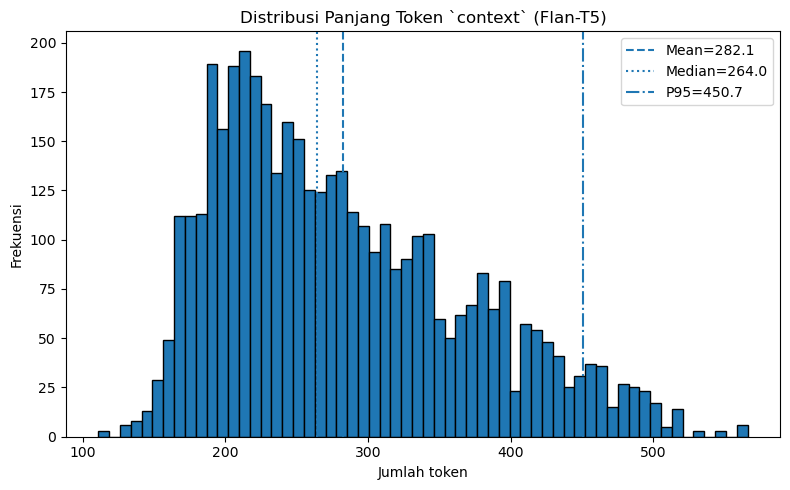

In [22]:
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1) Tokenizer Flan-T5
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# 2) Ambil panjang token kolom `context` dengan batching (lebih cepat)
def token_lengths_for_column(ds, col="context", batch_size=512):
    lengths = []
    n = len(ds)
    for start in tqdm(range(0, n, batch_size), desc=f"Tokenizing `{col}`"):
        end = min(start + batch_size, n)
        batch_texts = [(ds[i].get(col) or "") for i in range(start, end)]
        enc = t5_tokenizer(batch_texts, add_special_tokens=True, truncation=False)
        # panjang = jumlah token per contoh
        lens = [len(ids) for ids in enc["input_ids"]]
        lengths.extend(lens)
    return np.array(lengths, dtype=np.int32)

lengths = token_lengths_for_column(indoqa_clean, col="context", batch_size=512)

# 3) Statistik ringkas
def describe_lengths(arr):
    if arr.size == 0:
        return {}
    stats = {
        "count": int(arr.size),
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "min": int(np.min(arr)),
        "p50_median": float(np.median(arr)),
        "p90": float(np.percentile(arr, 90)),
        "p95": float(np.percentile(arr, 95)),
        "p99": float(np.percentile(arr, 99)),
        "max": int(np.max(arr)),
    }
    # proporsi melewati beberapa ambang umum (opsional)
    for thr in (256, 512, 600, 1024):
        stats[f"> {thr}"] = float((arr > thr).mean() * 100.0)
    return stats

stats = describe_lengths(lengths)

# 4) Cetak statistik
print("=== Statistik panjang token `context` (Flan-T5) ===")
for k in ["count","mean","std","min","p50_median","p90","p95","p99","max","> 256","> 512","> 600","> 1024"]:
    if k in stats:
        if k.startswith("> "):
            print(f"{k:>8}: {stats[k]:6.2f}%")
        elif k in {"mean","std","p50_median","p90","p95","p99"}:
            print(f"{k:>12}: {stats[k]:.2f}")
        else:
            print(f"{k:>12}: {stats[k]}")

# 5) Visualisasi histogram
plt.figure(figsize=(8,5))
plt.hist(lengths, bins=60, edgecolor="black")
plt.title("Distribusi Panjang Token `context` (Flan-T5)")
plt.xlabel("Jumlah token"); plt.ylabel("Frekuensi")

# Garis bantu mean/median/p95
mean_v = np.mean(lengths) if lengths.size else 0
med_v  = np.median(lengths) if lengths.size else 0
p95_v  = np.percentile(lengths, 95) if lengths.size else 0
plt.axvline(mean_v, linestyle="--", label=f"Mean={mean_v:.1f}")
plt.axvline(med_v,  linestyle=":",  label=f"Median={med_v:.1f}")
plt.axvline(p95_v,  linestyle="-.", label=f"P95={p95_v:.1f}")
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
indoqa_clean

Dataset({
    features: ['id', 'question', 'answer', 'context', 'category', 'span_start', 'span_end', 'question_norm', 'question_stem'],
    num_rows: 4247
})

Potong context agar panjangnya 180 token, minimal 50 token

In [24]:
indoqa_clean = indoqa_clean.map(
    lambda ex: add_segments_generic(
        ex,
        context_col="context",
        answer_col="answer",
        out_col="context_segments_180",  # nama keluaran sesuai selera
        tokenizer=t5_tokenizer,
        max_wp=180,
        min_wp_last=50,
    ),
    load_from_cache_file=False
)

Map: 100%|██████████| 4247/4247 [00:04<00:00, 973.72 examples/s] 


In [ ]:
# import re
# from typing import List, Tuple
# from datasets import Dataset  # kalau perlu
# from transformers import AutoTokenizer

# # Pakai BASE (bukan large)
# t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# def _encode_with_offsets(text: str, tokenizer):
#     """
#     Tokenisasi tanpa special tokens, sekaligus ambil offset mapping (char start, char end) per token.
#     """
#     enc = tokenizer(
#         text,
#         add_special_tokens=False,
#         return_offsets_mapping=True,
#         return_attention_mask=False,
#         return_token_type_ids=False,
#     )
#     # enc["input_ids"] adalah deretan wordpiece; setiap item = 1 token WP
#     return enc["input_ids"], enc["offset_mapping"]  # offsets: List[(start,end)]

# def _find_answer_char_spans(context: str, answer: str) -> List[Tuple[int, int]]:
#     """
#     Cari semua kemunculan substring 'answer' di 'context' (exact match, case-sensitive).
#     Kembalikan list pasangan (char_start, char_end).
#     """
#     if not answer:
#         return []
#     return [(m.start(), m.end()) for m in re.finditer(re.escape(answer), context)]

# def _char_to_token_span(offsets: List[Tuple[int,int]], char_start: int, char_end: int) -> Tuple[int, int]:
#     """
#     Peta rentang karakter [char_start, char_end) ke rentang token indeks [tok_s, tok_e] (inklusif).
#     Token dihitung masuk jika overlap dengan rentang karakter.
#     """
#     tok_s, tok_e = None, None
#     for i, (s, e) in enumerate(offsets):
#         if e <= char_start:    # token berakhir sebelum mulai jawaban
#             continue
#         if s >= char_end:      # token mulai setelah akhir jawaban
#             break
#         # overlap
#         if tok_s is None:
#             tok_s = i
#         tok_e = i
#     if tok_s is None:
#         return None
#     return (tok_s, tok_e)

# def _answer_token_spans(context: str, answer: str, offsets: List[Tuple[int,int]]) -> List[Tuple[int,int]]:
#     """
#     Dapatkan semua rentang token (start,end inklusif) yang mencakup jawaban (string).
#     """
#     spans_char = _find_answer_char_spans(context, answer)
#     spans_tok = []
#     for (cs, ce) in spans_char:
#         span = _char_to_token_span(offsets, cs, ce)
#         if span is not None:
#             spans_tok.append(span)
#     return spans_tok

# def _adjust_cut_for_answer(start_idx: int, tentative_cut: int, ans_spans: List[Tuple[int,int]]) -> int:
#     """
#     Sesuaikan titik potong (batas) agar tidak memotong jawaban.
#     - start_idx: indeks token awal segmen saat ini
#     - tentative_cut: indeks token batas eksklusif (potong di sini) = start_idx + 180 atau akhir teks
#     - ans_spans: daftar (s,e) inklusif token-range jawaban

#     Aturan:
#       * Jika tepat di awal jawaban (tentative_cut == s): potong SEBELUM jawaban (cut = s),
#         kecuali s == start_idx (akan kosong) -> dalam kasus ini MAJU ke akhir jawaban (cut = e+1).
#       * Jika jatuh DI TENGAH jawaban (s < tentative_cut <= e): MAJU ke akhir jawaban (cut = e+1).
#       * Jika tidak menyentuh jawaban: biarkan.
#     """
#     cut = tentative_cut
#     for (s, e) in ans_spans:
#         # tepat di awal jawaban
#         if cut == s:
#             if s > start_idx:
#                 cut = s
#             else:
#                 # menghindari segmen kosong; masukkan jawaban di segmen ini
#                 cut = e + 1
#             break
#         # di tengah jawaban
#         if s < cut <= e:
#             cut = e + 1
#             break
#     return cut

# def segment_context_with_answer(context: str, answer: str, tokenizer, max_wp: int = 180, min_wp_last: int = 50) -> List[str]:
#     """
#     Bagi 'context' (string) menjadi segmen dengan panjang <= max_wp wordpiece.
#     Jika batas memotong jawaban, sesuaikan sesuai aturan.
#     Setelah selesai, jika segmen terakhir < min_wp_last token, gabungkan ke segmen sebelumnya.

#     Return: list of segment strings.
#     """
#     if not isinstance(context, str) or len(context) == 0:
#         return []

#     input_ids, offsets = _encode_with_offsets(context, tokenizer)
#     n_tok = len(input_ids)
#     if n_tok == 0:
#         return [context]

#     # daftar jawaban (boleh ada beberapa kemunculan)
#     ans_tok_spans = _answer_token_spans(context, answer or "", offsets)

#     segments_tok_ranges: List[Tuple[int,int]] = []  # [ (a,b) ) b eksklusif
#     start = 0
#     while start < n_tok:
#         # target batas normal
#         tentative_cut = min(start + max_wp, n_tok)
#         # sesuaikan jika memotong jawaban
#         cut = _adjust_cut_for_answer(start, tentative_cut, ans_tok_spans)
#         # amankan batas
#         cut = max(cut, start + 1)  # jangan biarkan kosong
#         cut = min(cut, n_tok)

#         segments_tok_ranges.append((start, cut))
#         start = cut

#     # Hitung panjang token tiap segmen; jika segmen terakhir < min_wp_last, gabung ke sebelumnya
#     if len(segments_tok_ranges) >= 2:
#         last_s, last_e = segments_tok_ranges[-1]
#         last_len = last_e - last_s
#         if last_len < min_wp_last:
#             # gabung ke segmen sebelumnya (kontigu, jadi aman)
#             prev_s, prev_e = segments_tok_ranges[-2]
#             segments_tok_ranges[-2] = (prev_s, last_e)
#             segments_tok_ranges.pop()

#     # Konversi token-range ke substring asli via offset char
#     segments_text: List[str] = []
#     for (a, b) in segments_tok_ranges:
#         char_start = offsets[a][0]
#         char_end   = offsets[b-1][1]
#         segments_text.append(context[char_start:char_end])

#     return segments_text

# # ===== contoh pemakaian pada HuggingFace Dataset indoqa_clean =====
# # Asumsi: indoqa_clean punya kolom "context" (str) dan "answer" (str)
# def add_segments_for_indoqa(example):
#     segs = segment_context_with_answer(
#         context=example["context"],
#         answer=example["answer"],
#         tokenizer=t5_tokenizer,
#         max_wp=180,
#         min_wp_last=50,
#     )
#     example["context_segments_180"] = segs  # list[str]
#     return example

# # Terapkan:
# indoqa_clean = indoqa_clean.map(add_segments_for_indoqa)


Map: 100%|██████████| 4247/4247 [00:04<00:00, 855.09 examples/s] 


In [25]:
def add_pos_neg_for_indoqa(example, case_insensitive: bool = False):
    segs = example.get("context_segments_180", []) or []
    ans  = example.get("answer", "") or ""

    # jika tidak ada segmen atau jawaban kosong → semuanya negatif
    if not segs or not isinstance(ans, str) or not ans.strip():
        example["positive_passage"] = ""
        example["negative_passages"] = segs[:]  # semua negatif
        return example

    if case_insensitive:
        ans_norm = ans.casefold()
        seg_norms = [s.casefold() for s in segs]
        hit_indices = [i for i, s in enumerate(seg_norms) if ans_norm in s]
    else:
        hit_indices = [i for i, s in enumerate(segs) if ans in s]

    if hit_indices:
        pos_idx = hit_indices[0]
        example["positive_passage"] = segs[pos_idx]             # pakai teks asli
        example["negative_passages"] = [s for j, s in enumerate(segs) if j != pos_idx]
    else:
        # tidak ada segmen yang memuat jawaban (edge case)
        example["positive_passage"] = ""
        example["negative_passages"] = segs[:]

    return example

# Terapkan ke dataset (setelah kolom context_segments_180 ada)
# Exact match:
indoqa_clean = indoqa_clean.map(add_pos_neg_for_indoqa)

Map: 100%|██████████| 4247/4247 [00:00<00:00, 5680.81 examples/s]


In [26]:
# ambil baris yang positive_passage kosong
empty_pos = indoqa_clean.filter(lambda ex: not ex["positive_passage"].strip())

print("Jumlah baris dengan positive_passage kosong:", len(empty_pos))
# lihat contoh
print(empty_pos[:3])


Filter: 100%|██████████| 4247/4247 [00:00<00:00, 28356.31 examples/s]

Jumlah baris dengan positive_passage kosong: 3
{'id': ['1634B9b3aVWdJnidGaTwrGNb1147', '1170ckd0uh4YAd-bKWZ_EFml3244', '1539KqJCW6Fb0u-gfUpW2rn21396'], 'question': ['Mengapa Singapura mengirimkan 3 helikopter CH-47 Chinook ke Louisiana?', 'Pada tanggal berapa Timor Timur lepas dari NKRI dan menjadi negara terpisah yang berdaulat?', 'Siapakah guru Agama Mohamad Hatta ?'], 'answer': ["untuk membantu operasi kemanusiaan Badai Katrina'", 'mengadakan jajak pendapat bagi warga Timor Timur untuk memilih merdeka atau masih tetap menjadi 30 Agustus 1999.', 'Muhammad Jamil Jambek, Abdullah Ahmad, dan beberapa ulama lainnyaMuhammad Jamil Jambek, Abdullah Ahmad, dan beberapa ulama lainnya'], 'context': ['Sumber daya pertahanan Singapura telah dimanfaatkan pada misi-misi bantuan kemanusiaan internasional, termasuk tugas penjagaan perdamaian dari Perserikatan Bangsa-Bangsa yang melibatkan 11 negara. Bulan September 2005, Angkatan Udara Republik Singapura (RSAF) mengirimkan tiga helikopter CH-47 Chin

In [27]:
def has_answer(example):
    passage = example["positive_passage"]
    answers = example["answer"] or []
    # True kalau ada minimal satu jawaban muncul di passage
    return any(ans in passage for ans in answers)

print("Sebelum:", len(indoqa_clean))
# filter dataset
indoqa_clean_filtered = indoqa_clean.filter(has_answer)
print("Sesudah:", len(indoqa_clean_filtered))

Sebelum: 4247


Filter: 100%|██████████| 4247/4247 [00:00<00:00, 27535.97 examples/s]

Sesudah: 4244


In [28]:
indoqa_clean_filtered = indoqa_clean_filtered.remove_columns(['category', 'span_start', 'span_end', 'context','context_segments_180'])

Tokenizing `positive_passage`: 100%|██████████| 9/9 [00:00<00:00,  9.34it/s]


=== Statistik panjang token `context` (Flan-T5) ===
       count: 4247
        mean: 179.19
         std: 34.99
         min: 1
  p50_median: 182.00
         p90: 217.00
         p95: 224.00
         p99: 231.00
         max: 332
   > 256:   0.12%
   > 512:   0.00%
   > 600:   0.00%
  > 1024:   0.00%


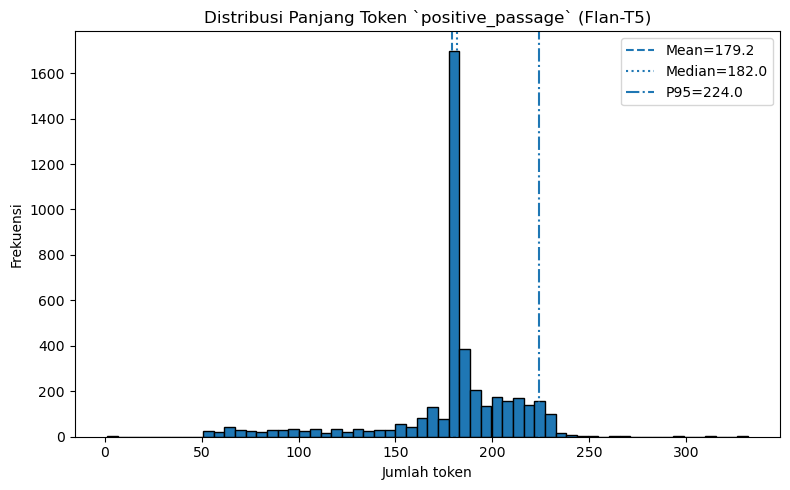

In [29]:
lengths = token_lengths_for_column(indoqa_clean, col="positive_passage", batch_size=512)
stats = describe_lengths(lengths)
# 4) Cetak statistik
print("=== Statistik panjang token `context` (Flan-T5) ===")
for k in ["count","mean","std","min","p50_median","p90","p95","p99","max","> 256","> 512","> 600","> 1024"]:
    if k in stats:
        if k.startswith("> "):
            print(f"{k:>8}: {stats[k]:6.2f}%")
        elif k in {"mean","std","p50_median","p90","p95","p99"}:
            print(f"{k:>12}: {stats[k]:.2f}")
        else:
            print(f"{k:>12}: {stats[k]}")

# 5) Visualisasi histogram
plt.figure(figsize=(8,5))
plt.hist(lengths, bins=60, edgecolor="black")
plt.title("Distribusi Panjang Token `positive_passage` (Flan-T5)")
plt.xlabel("Jumlah token"); plt.ylabel("Frekuensi")

# Garis bantu mean/median/p95
mean_v = np.mean(lengths) if lengths.size else 0
med_v  = np.median(lengths) if lengths.size else 0
p95_v  = np.percentile(lengths, 95) if lengths.size else 0
plt.axvline(mean_v, linestyle="--", label=f"Mean={mean_v:.1f}")
plt.axvline(med_v,  linestyle=":",  label=f"Median={med_v:.1f}")
plt.axvline(p95_v,  linestyle="-.", label=f"P95={p95_v:.1f}")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
indoqa_clean_filtered.save_to_disk("./generated_data/indoqa_with_unfinished_negative_passages")

Saving the dataset (1/1 shards): 100%|██████████| 4244/4244 [00:00<00:00, 47453.78 examples/s]


# FacQA

In [1]:
from datasets import load_dataset, concatenate_datasets
facqa = load_dataset("SEACrowd/facqa", trust_remote_code=True)

c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tandai baris mana yang berasal dari split train, mana yang validation, mana yang test

In [2]:
from datasets import load_dataset

# load dataset
facqa = load_dataset("SEACrowd/facqa", trust_remote_code=True)

# ubah kolom "index" -> "id" dan sesuaikan nilainya per split
def rename_and_prefix(example, idx, split_name):
    # gabungkan nama split + id lama
    return {"id": f"{split_name}_{str(example['index'])}"}

new_splits = {}
for split_name, ds in facqa.items():
    # map dengan tambahan index
    ds_new = ds.map(
        lambda ex, idx: rename_and_prefix(ex, idx, split_name),
        with_indices=True
    )
    # hapus kolom "index" lama
    ds_new = ds_new.remove_columns(["index"])
    new_splits[split_name] = ds_new

facqa = facqa.__class__(new_splits)

print(facqa)
print(facqa["train"][0])


DatasetDict({
    train: Dataset({
        features: ['question', 'passage', 'seq_label', 'id'],
        num_rows: 2495
    })
    test: Dataset({
        features: ['question', 'passage', 'seq_label', 'id'],
        num_rows: 311
    })
    validation: Dataset({
        features: ['question', 'passage', 'seq_label', 'id'],
        num_rows: 311
    })
})
{'question': ['Kelompok', 'apakah', 'yang', 'menyatakan', 'bertanggung', 'jawab', 'atas', 'ledakan', 'di', 'Srinagar', '?'], 'passage': ['Lewat', 'telepon', 'ke', 'kantor', 'berita', 'lokal', 'Current', 'News', 'Service', ',', 'Hezb-ul', 'Mujahedeen', ',', 'kelompok', 'militan', 'Kashmir', 'yang', 'terbesar', ',', 'menyatakan', 'bertanggung', 'jawab', 'atas', 'ledakan', 'di', 'Srinagar', '.'], 'seq_label': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'id': 'train_0'}


gabungkan semua split

In [3]:
from datasets import concatenate_datasets
facqa = concatenate_datasets([facqa[split] for split in facqa.keys()])
facqa

Dataset({
    features: ['question', 'passage', 'seq_label', 'id'],
    num_rows: 3117
})

gabungkan pertanyaan dan jawaban yang tadinya berupa list of strings

In [4]:
# --- util: simple detokenizer utk spasi & tanda baca ---
_PUNCT_RIGHT = set([",", ".", ":", ";", "!", "?", "%", ")", "]", "}", "’", "”"])
_PUNCT_LEFT  = set(["(", "[", "{", "‘", "“"])

def detok(tokens):
    out = []
    for i, tok in enumerate(tokens):
        if i == 0:
            out.append(tok)
            continue
        # tanpa spasi sebelum tanda baca kanan
        if tok in _PUNCT_RIGHT:
            out[-1] = out[-1] + tok
        # tanpa spasi setelah tanda buka kiri
        elif out[-1] in _PUNCT_LEFT:
            out[-1] = out[-1] + tok
        # kasus khusus tanda persen
        elif tok == "%" and out[-1].isdigit():
            out[-1] = out[-1] + tok
        else:
            out.append(" " + tok)
    return "".join(out)

In [5]:
from datasets import load_dataset

# fungsi ekstraksi jawaban dari BIO (pakai detok)
def extract_answer(tokens, labels):
    answers = []
    current = []
    for tok, lab in zip(tokens, labels):
        if lab == "B":
            if current:
                answers.append(detok(current))
            current = [tok]
        elif lab == "I":
            current.append(tok)
        else:  # O
            if current:
                answers.append(detok(current))
                current = []
    if current:
        answers.append(detok(current))
    return answers


# fungsi untuk map ke dataset
def preprocess(example):
    # gabungkan token jadi string utuh dengan detok
    example["question_text"] = detok(example["question"])
    # example["passage_text"]  = detok(example["passage"])  # aktifkan jika perlu
    # ekstrak jawaban ter-detok
    example["answer_text"]   = extract_answer(example["passage"], example["seq_label"])
    return example


# terapkan ke semua split
facqa = facqa.map(preprocess)

# cek hasil
print(facqa)
print(facqa[0]["question_text"])
# print(facqa[0]["passage_text"])
print(facqa[0]["answer_text"])

Map: 100%|██████████| 3117/3117 [00:01<00:00, 2605.11 examples/s]

Dataset({
    features: ['question', 'passage', 'seq_label', 'id', 'question_text', 'answer_text'],
    num_rows: 3117
})
Kelompok apakah yang menyatakan bertanggung jawab atas ledakan di Srinagar?
['Hezb-ul Mujahedeen']


lakukan segmentasi passage agar panjangnya 180 token. dalam kasus ada segmen yang panjangnya kurang dari 50 token, maka gabungkan segmen tersebut ke segmen sebelumnya

In [6]:
from transformers import AutoTokenizer
from datasets import Dataset  # jika perlu contoh lokal
import re

t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

# --- deteksi span B-I: kembalikan [(start, end_inclusive), ...] ---
def find_spans(seq_label):
    spans = []
    start = None
    for i, tag in enumerate(seq_label):
        if tag == "B":
            if start is not None:
                spans.append((start, i-1))
            start = i
        elif tag == "I":
            if start is None:
                # Jika ada I tanpa B (data noisy), mulai span di sini
                start = i
        else:  # "O" atau lainnya
            if start is not None:
                spans.append((start, i-1))
                start = None
    if start is not None:
        spans.append((start, len(seq_label)-1))
    return spans

# --- helper: apakah index i ada di dalam span manapun; dan cari end span aktif ---
def span_end_if_inside(i, spans):
    for s, e in spans:
        if s <= i <= e:
            return e
    return None

def is_span_start(i, spans):
    for s, e in spans:
        if s == i:
            return (s, e)
    return None

# --- hitung jumlah wordpieces per token ---
def wp_counts_for_tokens(tokens, tokenizer):
    counts = []
    for tok in tokens:
        # add_special_tokens=False agar hitung murni konten
        ids = tokenizer(tok, add_special_tokens=False).input_ids
        counts.append(len(ids))
    return counts

# --- segmentasi aman span + MERGE segmen < min_wp ke segmen sebelumnya ---
def segment_passage(tokens, seq_label, tokenizer, max_wp=180, min_wp=50):
    assert len(tokens) == len(seq_label)
    spans = find_spans(seq_label)
    wp_counts = wp_counts_for_tokens(tokens, tokenizer)

    segments_tok = []  # list of token-slices (masih berupa list token)
    i = 0
    seg_start = 0
    acc_wp = 0

    n = len(tokens)
    while i < n:
        c = wp_counts[i]
        # jika muat, lanjut
        if acc_wp + c <= max_wp:
            acc_wp += c
            i += 1
            continue

        # tidak muat bila tambah token i
        # cek: apakah kita sedang berada di dalam span (i-1 di dalam span yg berlanjut melewati i-1)?
        if i > seg_start:
            end_inside = span_end_if_inside(i-1, spans)
        else:
            end_inside = None

        # 1) Jika sedang di dalam span, majukan ke akhir span
        if end_inside is not None and end_inside >= i-1:
            cut_end = end_inside  # inklusif
            if cut_end < i-1:
                cut_end = i-1
            segments_tok.append(tokens[seg_start:cut_end+1])
            # reset ke setelah span
            i = cut_end + 1
            seg_start = i
            acc_wp = 0
            continue

        # 2) Jika token i adalah awal span, potong sebelum span
        span_at_i = is_span_start(i, spans)
        if span_at_i is not None:
            if i == seg_start:
                s, e = span_at_i
                segments_tok.append(tokens[s:e+1])  # span > max_wp pun dibolehkan 1 chunk
                i = e + 1
                seg_start = i
                acc_wp = 0
            else:
                segments_tok.append(tokens[seg_start:i])
                seg_start = i
                acc_wp = 0
            continue

        # 3) Bukan di dalam span, bukan awal span -> potong biasa sebelum i
        if i == seg_start:
            segments_tok.append([tokens[i]])
            i += 1
            seg_start = i
            acc_wp = 0
        else:
            segments_tok.append(tokens[seg_start:i])
            seg_start = i
            acc_wp = 0

    # sisa
    if seg_start < n:
        segments_tok.append(tokens[seg_start:])

    # konversi ke teks (sementara, sebelum merge)
    segment_texts = [detok(seg) for seg in segments_tok]

    # === MERGE: gabungkan segmen yang < min_wp ke segmen sebelumnya ===
    def wp_len(text):
        return len(tokenizer(text, add_special_tokens=False).input_ids)

    merged = []
    for idx, seg_text in enumerate(segment_texts):
        if idx > 0 and wp_len(seg_text) < min_wp:
            # append ke sebelumnya (boleh melewati 180 sesuai aturan pengecualian)
            merged[-1] = merged[-1].rstrip() + " " + seg_text.lstrip()
        else:
            merged.append(seg_text)

    full_text = detok(tokens)
    return full_text, merged

# ====== Integrasi ke HuggingFace Dataset (tetap SATU kolom akhir) ======
def add_text_and_segments(example):
    full_text, segs_final = segment_passage(
        example["passage"], example["seq_label"], t5_tokenizer, max_wp=180, min_wp=50
    )
    example["passage_text"] = full_text
    example["passage_segments_180"] = segs_final  # sudah final + merged
    return example

facqa_initial = facqa.map(add_text_and_segments)


Map: 100%|██████████| 3117/3117 [00:08<00:00, 352.10 examples/s]


Tokenizing `passage_text`: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


=== Statistik panjang token `context` (Flan-T5) ===
       count: 3117
        mean: 133.88
         std: 44.03
         min: 15
  p50_median: 128.00
         p90: 193.00
         p95: 211.00
         p99: 266.00
         max: 366
   > 256:   1.67%
   > 512:   0.00%
   > 600:   0.00%
  > 1024:   0.00%


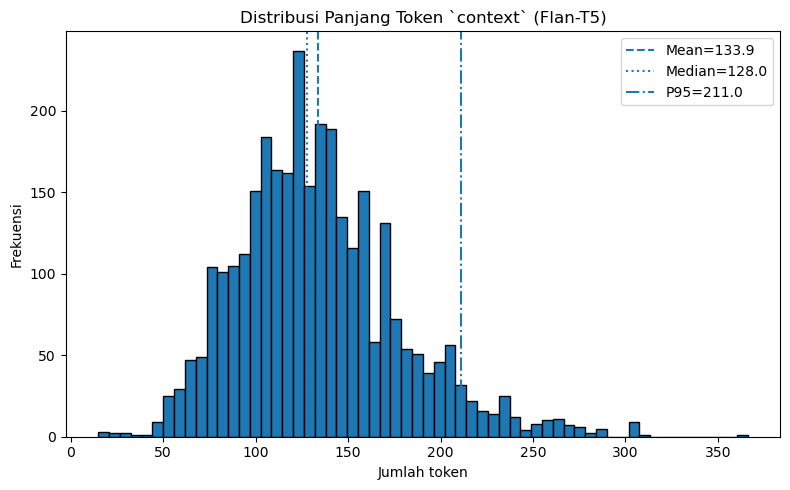

In [30]:
lengths = token_lengths_for_column(facqa_initial, col="passage_text", batch_size=512)
stats = describe_lengths(lengths)
# 4) Cetak statistik
print("=== Statistik panjang token `context` (Flan-T5) ===")
for k in ["count","mean","std","min","p50_median","p90","p95","p99","max","> 256","> 512","> 600","> 1024"]:
    if k in stats:
        if k.startswith("> "):
            print(f"{k:>8}: {stats[k]:6.2f}%")
        elif k in {"mean","std","p50_median","p90","p95","p99"}:
            print(f"{k:>12}: {stats[k]:.2f}")
        else:
            print(f"{k:>12}: {stats[k]}")

# 5) Visualisasi histogram
plt.figure(figsize=(8,5))
plt.hist(lengths, bins=60, edgecolor="black")
plt.title("Distribusi Panjang Token `context` (Flan-T5)")
plt.xlabel("Jumlah token"); plt.ylabel("Frekuensi")

# Garis bantu mean/median/p95
mean_v = np.mean(lengths) if lengths.size else 0
med_v  = np.median(lengths) if lengths.size else 0
p95_v  = np.percentile(lengths, 95) if lengths.size else 0
plt.axvline(mean_v, linestyle="--", label=f"Mean={mean_v:.1f}")
plt.axvline(med_v,  linestyle=":",  label=f"Median={med_v:.1f}")
plt.axvline(p95_v,  linestyle="-.", label=f"P95={p95_v:.1f}")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
def passage_miss_answer(example):
    passage = example["passage_text"]
    answers = example["answer_text"] or []  # list of string
    
    # True kalau tidak ada satu pun jawaban yang muncul di passage_text
    return not any(ans in passage for ans in answers)
fac_miss = facqa_initial.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(fac_miss)}")
# df=fac_miss.to_pandas()
# df.to_excel("answer_not_in_positive_passage.xlsx")

Jumlah baris yang miss: 0


In [9]:
import re

# normalisasi ringan untuk kesesuaian segmen vs jawaban
_PUNCT_RIGHT = r",\.\:\;\!\?\%\)\]\}\'\""
_PUNCT_LEFT = r"\(\[\{"

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    # hapus spasi sebelum tanda baca kanan: "Fauzi , Gubernur" -> "Fauzi, Gubernur"
    s = re.sub(rf"\s+([{_PUNCT_RIGHT}])", r"\1", s)
    # hapus spasi setelah tanda buka kiri: "( 15/12)" -> "(15/12)"
    s = re.sub(rf"([{_PUNCT_LEFT}])\s+", r"\1", s)
    # rapikan spasi ganda
    s = re.sub(r"\s{2,}", " ", s)
    # trim
    s = s.strip()
    return s

def add_positive_negative(example):
    segments = example.get("passage_segments_180", [])  # list[str]
    answers  = example.get("answer_text", [])           # list[str]

    # bersihkan / normalisasi
    seg_norms = [normalize_text(seg).casefold() for seg in segments]
    ans_norms = [normalize_text(a).casefold() for a in answers if isinstance(a, str) and a.strip()]

    # fungsi cek: segmen memuat SEMUA jawaban
    def contains_all(seg_norm: str, ans_list_norm):
        return all(a in seg_norm for a in ans_list_norm)

    if not segments:
        # tidak ada segmen sama sekali
        example["positive_passage"] = ""
        example["negative_passages"] = []
        example["positive_passage_index"] = -1
        example["has_all_answers_in_one_segment"] = False
        return example

    # jika tidak ada jawaban (edge case), anggap tidak ada segmen positif
    if not ans_norms:
        example["positive_passage"] = ""
        example["negative_passages"] = segments[:]  # semua negatif
        example["positive_passage_index"] = -1
        example["has_all_answers_in_one_segment"] = False
        return example

    # cari segmen yang memuat semua jawaban
    pos_indices = [i for i, segn in enumerate(seg_norms) if contains_all(segn, ans_norms)]

    if pos_indices:
        pos_idx = pos_indices[0]                # ambil yang pertama jika ada beberapa
        positive = segments[pos_idx]            # pakai teks aslinya (tanpa normalisasi)
        negatives = [seg for j, seg in enumerate(segments) if j != pos_idx]
        has_all = True
    else:
        pos_idx = -1
        positive = ""                           # atau None
        negatives = segments[:]                 # semua dianggap negatif
        has_all = False

    example["positive_passage"] = positive
    example["negative_passages"] = negatives
    example["positive_passage_index"] = pos_idx
    example["has_all_answers_in_one_segment"] = has_all
    return example

# Terapkan ke dataset (setelah passage_segments_180 & answer_text ada)
facqa_positive_and_negative = facqa_initial.map(add_positive_negative)


Map:   0%|          | 0/3117 [00:00<?, ? examples/s]

Map: 100%|██████████| 3117/3117 [00:00<00:00, 3205.83 examples/s]


In [11]:
def all_answers_not_in_first(example):
    answers = example["answer_text"]  # list of strings
    segments = example["passage_segments_180"]

    if not segments:  # jaga-jaga kalau list kosong
        return False

    first_seg = segments[0]
    # cek apakah ada jawaban yg muncul di segmen pertama
    any_in_first = any(ans in first_seg for ans in answers)

    # kalau tidak ada satu pun di segmen pertama, return True
    return not any_in_first

multi_segments = facqa_positive_and_negative.filter(lambda x: len(x['passage_segments_180'])> 1)
# filter baris yang semua jawabannya bukan di segmen pertama
not_in_first = multi_segments.filter(all_answers_not_in_first)

print("banyak baris yang jawabannya tidak berada di segmen pertama:", len(not_in_first))

# df = not_in_first.to_pandas()
# df.to_excel("answers_not_in_first_segment.xlsx", index=False)
# print("Disimpan ke answers_not_in_first_segment.xlsx")

Filter: 100%|██████████| 123/123 [00:00<00:00, 1411.00 examples/s]

banyak baris yang jawabannya tidak berada di segmen pertama: 35


In [ ]:
# 1) hitung jumlah 'B' total & distribusi 'B' per baris
from collections import Counter
def count_B_I_O(ex):
    c = Counter(ex["seq_label"])
    ex["num_B"] = c.get("B", 0)
    ex["num_I"] = c.get("I", 0)
    ex["num_O"] = c.get("O", 0)
    return ex

facqa = facqa.map(count_B_I_O)

total_B = int(sum(facqa["num_B"]))
print("Total B:", total_B)
print("Total rows:", len(facqa))

# 2) filter baris yang punya >1 span (num_B > 1)
multi_span = facqa.filter(lambda ex: ex["num_B"] > 1)
print("Rows with multi-span answers:", len(multi_span))

Map: 100%|██████████| 3117/3117 [00:00<00:00, 4599.30 examples/s]


Total B: 3169
Total rows: 3117


Filter: 100%|██████████| 3117/3117 [00:00<00:00, 5156.09 examples/s]

Rows with multi-span answers: 42


In [16]:
facqa_positive_and_negative = facqa_positive_and_negative.map(
    add_norm_and_stem, 
    batched=True, 
    fn_kwargs={"column": "question_text"}   # sesuaikan dengan nama kolom di tydiqa_gold_all
)
facqa_positive_and_negative

Map: 100%|██████████| 3117/3117 [06:41<00:00,  7.77 examples/s]


Dataset({
    features: ['question', 'passage', 'seq_label', 'id', 'question_text', 'answer_text', 'passage_text', 'passage_segments_180', 'positive_passage', 'negative_passages', 'positive_passage_index', 'has_all_answers_in_one_segment', 'question_text_norm', 'question_text_stem'],
    num_rows: 3117
})

In [17]:
def passage_miss_answer(example):
    passage = example["positive_passage"]
    answers = example["answer_text"] or []  # list of string
    
    # True kalau tidak ada satu pun jawaban yang muncul di passage_text
    return not any(ans in passage for ans in answers)
fac_miss = facqa_positive_and_negative.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(fac_miss)}")
# df=fac_miss.to_pandas()
# df.to_excel("answer_not_in_positive_passage.xlsx")

Filter: 100%|██████████| 3117/3117 [00:00<00:00, 5167.76 examples/s]

Jumlah baris yang miss: 0


In [18]:
facqa_positive_and_negative = facqa_positive_and_negative.remove_columns([ 'passage', 'seq_label','passage_text', 'passage_segments_180','positive_passage_index', 'has_all_answers_in_one_segment'])
facqa_positive_and_negative

Dataset({
    features: ['question', 'id', 'question_text', 'answer_text', 'positive_passage', 'negative_passages', 'question_text_norm', 'question_text_stem'],
    num_rows: 3117
})

In [19]:
import pandas as pd

# konversi dataset HF ke pandas
df = facqa_positive_and_negative.to_pandas()

# cari duplikasi berdasarkan kolom question_stem
dupes_mask = df.duplicated(subset=["question_text_stem"], keep=False)

# subset baris duplikat
dupes_df = df[dupes_mask].sort_values("question_text_stem")

# hitung jumlah pertanyaan yang duplikat
n_dupes = dupes_df["question_text_stem"].nunique()
print(f"Jumlah question_stem yang terduplikasi: {n_dupes}")
print(f"Jumlah baris yang termasuk duplikat  : {len(dupes_df)}")

# simpan ke Excel
# dupes_df.to_excel("facqa_question_stem_duplicates.xlsx", index=False)
# print("✅ File 'facqa_question_stem_duplicates.xlsx' berhasil dibuat.")

Jumlah question_stem yang terduplikasi: 73
Jumlah baris yang termasuk duplikat  : 189


menghapus baris yang questions_stem nya terduplikasi dan answer nya jelek (pengecekan answer secara manual)

In [20]:
# ====== 2) Daftar pasangan dari Excel (sudah dituliskan ulang ke kode) ======
EXCEL_PAIRS = [
    ("apa nama badan bagi dari universitas gadjah mada ugm yang libat dalam ada sistem energi alternatif di yogyakarta", 'PSE UGM'),
    ("apa nama partai hosni mubarak", 'NDP'),
    ('di badan apakah bastian purnama jabat bagai direktur utama', 'BES'),
    ('kapan keluar undang nomor 31 tentang ikan', 'tahun '
    '2004'),
    ('kapan mou indonesia-gam ditandatangani', '15/8'),
    ('kepala badan apakah mohamed elbaradei', 'IAEA'),
    ('kepala balai apakah yohanes sudarto', 'BKSDA Kalteng'),
    ('menandatangani apakah perintah indonesia dan gam di helsinki finlandia tanggal 15 agustus 2005', 'nota kesepahaman atau MOU tentang perdamaian di Aceh'),
    ('siapa nama putra presiden hosni mubarak','Jamal')
]

# Ubah ke set untuk lookup cepat; trimming spasi agar toleran spasi ekstra
PAIRS_SET = set((qs.strip(), ans.strip()) for qs, ans in EXCEL_PAIRS)

# ====== Filter facqa: drop baris yang match (question_text_stem, salah-satu answer_text) ======
def _should_keep_facqa(example):
    qstem = (example.get("question_text_stem") or "").strip()
    answers = example.get("answer_text") or []  # list[str]
    for t in answers:
        if (qstem, (t or "").strip()) in PAIRS_SET:
            return False  # baris ini DIHAPUS
    return True  # keep

before_n = len(facqa_positive_and_negative)
facqa_filtered = facqa_positive_and_negative.filter(_should_keep_facqa)
after_n = len(facqa_filtered)
removed = before_n - after_n
print(f"Rows before: {before_n} | after: {after_n} | removed: {removed}")

# ====== (Opsional) laporan pasangan Excel yang tidak ketemu di dataset ======
def _collect_hits(example):
    qstem = (example.get("question_text_stem") or "").strip()
    answers = example.get("answer_text") or []
    hits = []
    for t in answers:
        key = (qstem, (t or "").strip())
        if key in PAIRS_SET:
            hits.append(key)
    return {"_hits": hits}

hits_ds = facqa_positive_and_negative.map(_collect_hits, batched=False)
found_pairs = set()
for row in hits_ds:
    for h in row.get("_hits", []):
        # 'h' sudah tuple-like (atau list dua elemen)
        found_pairs.add(tuple(h))

not_found = PAIRS_SET - found_pairs
if not_found:
    print("\nPairs from Excel NOT FOUND in facqa:")
    for qs, ans in sorted(not_found):
        print(f"- question_text_stem={qs!r} | answer_text element={ans!r}")

# Commit hasil filter
facqa = facqa_filtered

Filter: 100%|██████████| 3117/3117 [00:00<00:00, 20280.51 examples/s]


Rows before: 3117 | after: 3108 | removed: 9


Map: 100%|██████████| 3117/3117 [00:00<00:00, 6548.57 examples/s]


In [21]:
def passage_miss_answer(example):
    passage = example["positive_passage"]
    answers = example["answer_text"] or []  # list of string
    
    # True kalau tidak ada satu pun jawaban yang muncul di passage_text
    return not any(ans in passage for ans in answers)
fac_miss = facqa.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(fac_miss)}")
# df=fac_miss.to_pandas()
# df.to_excel("answer_not_in_positive_passage.xlsx")

Filter: 100%|██████████| 3108/3108 [00:00<00:00, 11389.97 examples/s]

Jumlah baris yang miss: 0


In [22]:
import pandas as pd
import numpy as np
from datasets import Dataset

# convert ke pandas
df = facqa.to_pandas()

# panjang passage; NaN -> +inf agar tidak terpilih sebagai terpendek
df["_passage_len"] = df["positive_passage"].str.len()
df["_passage_len"] = df["_passage_len"].fillna(np.inf)

# (opsional) buat hasil deterministik pada tie: sort by _passage_len lalu ambil first
df_sorted = df.sort_values(by=["question_text_stem", "_passage_len"], kind="mergesort")

# ambil indeks dengan passage terpendek per question_text_stem
idx_min = df_sorted.groupby("question_text_stem")["_passage_len"].idxmin()

# subset baris yang disimpan
df_kept = df.loc[idx_min].reset_index(drop=True)

print(f"Before: {len(df)} | After: {len(df_kept)} | Removed: {len(df) - len(df_kept)}")

# buang kolom bantu
df_kept = df_kept.drop(columns=["_passage_len"])

# convert balik ke HF Dataset (hindari kolom __index_level_0__)
facqa_wo_dedupe = Dataset.from_pandas(df_kept, preserve_index=False)


Before: 3108 | After: 3001 | Removed: 107


In [23]:
def normalize_fields(batch, answer_col):
    new_answers = []
    new_positive = []
    new_negatives = []

    answers_batch   = batch.get(answer_col, [])
    positives_batch = batch.get("positive_passage", [])
    negatives_batch = batch.get("negative_passages", [])

    for i in range(len(answers_batch)):
        # ===== answers: pastikan list, lalu normalize per elemen =====
        ans = answers_batch[i]
        if ans is None:
            norm_ans = []
        elif isinstance(ans, (list, tuple)):
            norm_ans = [normalize(a, lowercase=False) for a in ans if a is not None]
        else:
            # kalau awalnya string tunggal → jadikan list satu elemen
            norm_ans = [normalize(ans, lowercase=False)]

        new_answers.append(norm_ans)

        # ===== positive_passage (string) =====
        pos = positives_batch[i] if i < len(positives_batch) else None
        norm_pos = normalize(pos, lowercase=False) if pos else pos
        new_positive.append(norm_pos)

        # ===== negative_passages (list of string) =====
        negs = negatives_batch[i] if i < len(negatives_batch) else []
        norm_negs = [normalize(n, lowercase=False) for n in negs if n is not None]
        new_negatives.append(norm_negs)
    # tulis balik ke kolom yang sama
    return {
        answer_col: new_answers,
        "positive_passage": new_positive,
        "negative_passages": new_negatives,
    }

facqa_wo_dedupe = facqa.map(
    normalize_fields,
    batched=True,
    batch_size=100,
    load_from_cache_file=False,
    fn_kwargs={"answer_col": "answer_text"},
)

Map: 100%|██████████| 3108/3108 [00:01<00:00, 2120.77 examples/s]


In [24]:
def passage_miss_answer(example):
    passage = example["positive_passage"]
    answers = example["answer_text"] or []  # list of string
    
    # True kalau tidak ada satu pun jawaban yang muncul di passage_text
    return not any(ans in passage for ans in answers)
fac_miss = facqa_wo_dedupe.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(fac_miss)}")
# df=fac_miss.to_pandas()
# df.to_excel("answer_not_in_positive_passage.xlsx")

Filter: 100%|██████████| 3108/3108 [00:00<00:00, 17515.86 examples/s]


Jumlah baris yang miss: 0


Tokenizing `positive_passage`: 100%|██████████| 7/7 [00:00<00:00, 11.00it/s]


=== Statistik panjang token `positive_passage` (Flan-T5) ===
       count: 3108
        mean: 129.18
         std: 37.51
         min: 15
  p50_median: 127.00
         p90: 178.00
         p95: 196.65
         p99: 211.00
         max: 224
   > 256:   0.00%
   > 512:   0.00%
   > 600:   0.00%
  > 1024:   0.00%


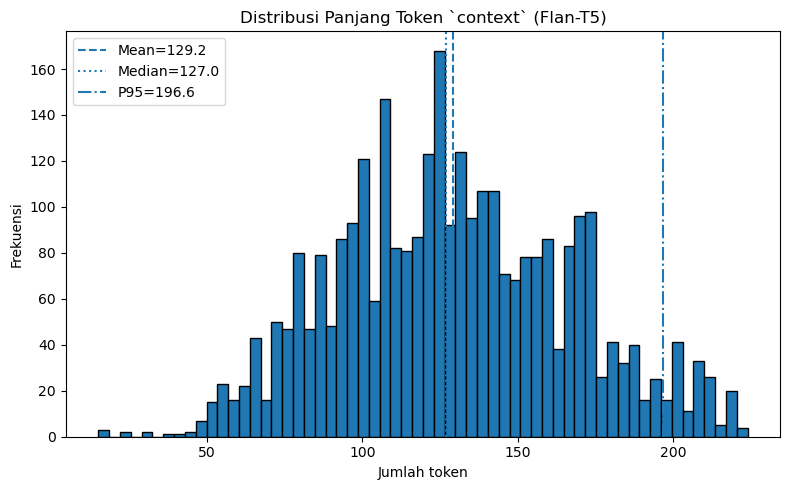

In [31]:
lengths = token_lengths_for_column(facqa_wo_dedupe, col="positive_passage", batch_size=512)
stats = describe_lengths(lengths)
# 4) Cetak statistik
print("=== Statistik panjang token `positive_passage` (Flan-T5) ===")
for k in ["count","mean","std","min","p50_median","p90","p95","p99","max","> 256","> 512","> 600","> 1024"]:
    if k in stats:
        if k.startswith("> "):
            print(f"{k:>8}: {stats[k]:6.2f}%")
        elif k in {"mean","std","p50_median","p90","p95","p99"}:
            print(f"{k:>12}: {stats[k]:.2f}")
        else:
            print(f"{k:>12}: {stats[k]}")

# 5) Visualisasi histogram
plt.figure(figsize=(8,5))
plt.hist(lengths, bins=60, edgecolor="black")
plt.title("Distribusi Panjang Token `context` (Flan-T5)")
plt.xlabel("Jumlah token"); plt.ylabel("Frekuensi")

# Garis bantu mean/median/p95
mean_v = np.mean(lengths) if lengths.size else 0
med_v  = np.median(lengths) if lengths.size else 0
p95_v  = np.percentile(lengths, 95) if lengths.size else 0
plt.axvline(mean_v, linestyle="--", label=f"Mean={mean_v:.1f}")
plt.axvline(med_v,  linestyle=":",  label=f"Median={med_v:.1f}")
plt.axvline(p95_v,  linestyle="-.", label=f"P95={p95_v:.1f}")
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
facqa_wo_dedupe

Dataset({
    features: ['id', 'question', 'answer', 'positive_passage', 'negative_passages', 'question_norm', 'question_stem'],
    num_rows: 3108
})

In [33]:
facqa_wo_dedupe=facqa_wo_dedupe.remove_columns(['question'])
facqa_wo_dedupe=facqa_wo_dedupe.rename_column('answer_text', 'answer')

# mapping nama lama ke nama baru
rename_map = {
    "question_text": "question",
    "question_text_norm": "question_norm",
    "question_text_stem": "question_stem",
}

# rename kolom
facqa_wo_dedupe = facqa_wo_dedupe.rename_columns(rename_map)

In [39]:
def passage_miss_answer(example):
    passage = example["positive_passage"]
    answers = example["answer"] or []  # list of string
    
    # True kalau tidak ada satu pun jawaban yang muncul di passage_text
    return not any(ans in passage for ans in answers)
fac_miss = facqa_wo_dedupe.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(fac_miss)}")
# df=fac_miss.to_pandas()
# df.to_excel("answer_not_in_positive_passage.xlsx")

Filter: 100%|██████████| 3108/3108 [00:00<00:00, 23771.43 examples/s]

Jumlah baris yang miss: 0


In [ ]:
facqa_wo_dedupe.save_to_disk("./generated_data/facqa_with_unfinished_negative_passages")

In [2]:
from datasets import load_from_disk
facqa_wo_dedupe = load_from_disk("./generated_data/facqa_with_unfinished_negative_passages")

In [4]:
rows = facqa_wo_dedupe.filter(lambda x: len(x['negative_passages'])>0)
df=rows.to_pandas()
df.to_excel("negative_passages_splitted_from_positive_passage.xlsx")

# Isi negative passages

In [197]:
from datasets import load_dataset
corpus = load_dataset("khalidrizki/indonesian-wiki-chunked-180tok")
# ambil hanya split train
corpus = corpus["train"]

# shuffle dengan seed biar hasil konsisten
corpus = corpus.shuffle(seed=42)

# pilih 300 ribu baris pertama setelah shuffle
corpus = corpus.select(range(300_000))

print(corpus)

Dataset({
    features: ['docid', 'title', 'text'],
    num_rows: 300000
})


In [205]:
prefix = "Sejarah Nusantara pada era kerajaan Hindu-Buddha | 101- Penempatan Lembah Bujang yang menggunakan aksara Sanskrit Pallava membuktikan"

# ambil baris yang diawali prefix
subset = corpus.filter(lambda ex: ex["text"].startswith(prefix))

print("Jumlah baris ditemukan:", len(subset))
print(subset)

Filter: 100%|██████████| 300000/300000 [00:11<00:00, 27188.88 examples/s]

Jumlah baris ditemukan: 0
Dataset({
    features: ['docid', 'title', 'text'],
    num_rows: 0
})


Dataset({
    features: ['docid', 'title', 'text'],
    num_rows: 300000
})


Map: 100%|██████████| 300000/300000 [00:26<00:00, 11428.26 examples/s]



Statistik panjang token (T5-base) — kolom 'text':
 count: 300000
  mean: 135.50
median: 139.00
   q25: 93.00
   q75: 180.00
   p10: 66.00
   p90: 185.00
   min: 2
   max: 230


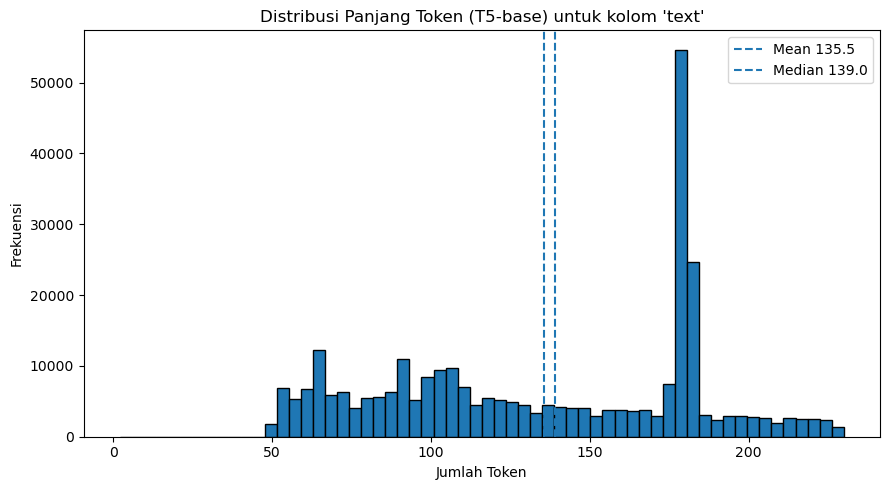

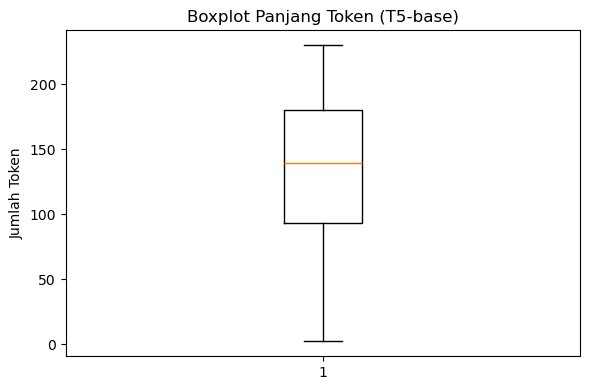

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer

# ----- 1) Siapkan dataset persis seperti milikmu -----
corpus = load_dataset("khalidrizki/indonesian-wiki-chunked-180tok")["train"]
corpus = corpus.shuffle(seed=42).select(range(300_000))
print(corpus)

# ----- 2) Load tokenizer T5 base -----
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# ----- 3) Hitung panjang token per contoh (batched) -----
def add_t5_len(batch):
    # Tokenisasi tanpa truncation, tanpa padding; panjang = jumlah token WP T5
    enc = t5_tokenizer(
        batch["text"],
        add_special_tokens=True,   # set True agar panjang mencakup special tokens (konsisten banyak pipeline)
        truncation=False,
        padding=False,
        return_attention_mask=False,
        return_token_type_ids=False,
    )
    # enc["input_ids"] adalah list of lists; ambil panjangnya
    lengths = [len(ids) for ids in enc["input_ids"]]
    return {"t5_len": lengths}

# num_proc bisa >1 kalau sistemmu mendukung multiprocessing (opsional)
corpus_len = corpus.map(add_t5_len, batched=True, batch_size=1024, load_from_cache_file=False)

# ----- 4) Statistik ringkas -----
lens = np.array(corpus_len["t5_len"], dtype=np.int32)
stats = {
    "count": len(lens),
    "mean": float(np.mean(lens)),
    "median": float(np.median(lens)),
    "q25": float(np.percentile(lens, 25)),
    "q75": float(np.percentile(lens, 75)),
    "p10": float(np.percentile(lens, 10)),
    "p90": float(np.percentile(lens, 90)),
    "min": int(lens.min()),
    "max": int(lens.max()),
}
print("\nStatistik panjang token (T5-base) — kolom 'text':")
for k, v in stats.items():
    print(f"{k:>6}: {v:.2f}" if isinstance(v, float) else f"{k:>6}: {v}")

# ----- 5) Visualisasi -----
plt.figure(figsize=(9,5))
plt.hist(lens, bins=60, edgecolor="black")
plt.axvline(stats["mean"], linestyle="--", label=f"Mean {stats['mean']:.1f}")
plt.axvline(stats["median"], linestyle="--", label=f"Median {stats['median']:.1f}")
plt.title("Distribusi Panjang Token (T5-base) untuk kolom 'text'")
plt.xlabel("Jumlah Token")
plt.ylabel("Frekuensi")
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot untuk melihat sebaran & outlier
plt.figure(figsize=(6,4))
plt.boxplot(lens, vert=True, showfliers=True)
plt.title("Boxplot Panjang Token (T5-base)")
plt.ylabel("Jumlah Token")
plt.tight_layout()
plt.show()


In [51]:
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

model_name = "intfloat/multilingual-e5-small"
embedding_tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name).to("cuda:0")
embedding_model.eval()

# Fungsi average pooling
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

corpus_dict = {row["docid"]: (row["title"], row["text"]) for row in corpus}
corpus_docids = list(corpus_dict.keys())
corpus_texts = [f"passage: {corpus_dict[docid][0]} | {corpus_dict[docid][1]}" for docid in corpus_docids]

In [52]:
import torch.nn.functional as F
from tqdm import tqdm
import torch
import faiss
batch_size = 128  # Sesuaikan dengan VRAM yang tersedia
corpus_embeddings = []

for start_idx in tqdm(range(0, len(corpus_texts), batch_size), desc="Encoding Corpus"):
    end_idx = min(start_idx + batch_size, len(corpus_texts))
    batch_texts = corpus_texts[start_idx:end_idx]

    batch_dict = embedding_tokenizer(batch_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
    batch_dict = {k: v.to("cuda:0") for k, v in batch_dict.items()}

    with torch.no_grad():
        outputs = embedding_model(**batch_dict)

    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalisasi untuk cosine similarity
    corpus_embeddings.append(embeddings.to(torch.float32).cpu())  # Pastikan float32 dan tetap di CPU

Encoding Corpus: 100%|██████████| 2344/2344 [09:26<00:00,  4.13it/s]


In [53]:
import numpy as np
# Gabungkan semua embedding menjadi satu tensor besar
corpus_embeddings = torch.cat(corpus_embeddings, dim=0).numpy().astype(np.float32)  # Konversi ke NumPy

# Buat FAISS index untuk pencarian similarity
index = faiss.IndexFlatIP(corpus_embeddings.shape[1])  # IP = Inner Product (Cosine Similarity)
index.add(corpus_embeddings)  # Tambahkan corpus embeddings ke FAISS

In [54]:
import os
import numpy as np
os.makedirs("./generated_data", exist_ok=True)

# Simpan FAISS index
faiss.write_index(index, "./generated_data/corpus_faiss.idx")

# Simpan lookup agar urutan selaras dengan index
# (penting untuk merekonstruksi teks dari hasil pencarian FAISS)
np.save("./generated_data/corpus_texts.npy", np.array(corpus_texts, dtype=object))
np.save("./generated_data/corpus_docids.npy", np.array(corpus_docids, dtype=object))

print("Saved:",
      "./generated_data/corpus_faiss.idx",
      "./generated_data/corpus_texts.npy",
      "./generated_data/corpus_docids.npy", sep="\n")

Saved:
./generated_data/corpus_faiss.idx
./generated_data/corpus_texts.npy
./generated_data/corpus_docids.npy


In [ ]:
# GA UP TO DATE
# import faiss

# # baca kembali dari file
# index = faiss.read_index("./generated_data/_corpus_faiss.idx")

In [55]:
import os
import re
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import faiss
from tqdm import tqdm

# ---------------------------
# 1) Load FAISS index + lookup
# ---------------------------

# Lookup yang SELARAS dengan urutan embeddings saat di-add.
# Misalnya kamu simpan pakai: np.save("./generated_data/corpus_texts.npy", np.array(corpus_texts, dtype=object))
# corpus_texts = np.load("./generated_data/corpus_texts.npy", allow_pickle=True).tolist()
# assert index.ntotal == len(corpus_texts), "Index size dan jumlah corpus_texts tidak sama!"

# (opsional) Kalau kamu juga simpan docids selaras:
# corpus_docids = np.load("./generated_data/corpus_docids.npy", allow_pickle=True).tolist()

# ---------------------------
# 2) Siapkan encoder (multilingual-e5-small)
# ---------------------------
model_name = "intfloat/multilingual-e5-small"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
embedding_tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name).to(device).eval()

def average_pool(last_hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

# ---------------------------
# 3) Util: normalisasi ringan & filter
# ---------------------------
def strip_passage_prefix(s: str) -> str:
    # Kalau saat buat index kamu pakai "passage: title | body", kita hilangkan "passage:" agar adil saat perbandingan
    return re.sub(r"^\s*passage:\s*", "", s, flags=re.IGNORECASE)

def normalize_cmp(s: str) -> str:
    if s is None:
        return ""
    s = strip_passage_prefix(s)
    s = re.sub(r"\s+", " ", s).strip().casefold()
    return s

def choose_topk_filtered(ids_row, k, positive_text):
    """Ambil top-k corpus_texts untuk satu query, sambil membuang yang sama persis dgn positive_passage."""
    pos_norm = normalize_cmp(positive_text or "")
    out = []
    for idx in ids_row:
        cand = corpus_texts[idx]
        # bandingkan secara normalisasi
        if normalize_cmp(cand) == pos_norm:
            continue
        out.append(cand)
        if len(out) == k:
            break
    return out

# ---------------------------
# 4) Batch retrieve untuk dataset HF
# ---------------------------
# Param:
TOPK = 3               # ingin 3 passages
SEARCH_OVERFETCH = 5  # ambil lebih banyak, untuk jaga-jaga kalau ada yang terfilter karena sama dgn positive_passage
BATCH_SIZE = 128

# amp untuk inference cepat
amp_dtype = torch.bfloat16 if (device.type == "cuda" and torch.cuda.is_bf16_supported()) else torch.float16

def retrieve_batch(batch):
    """
    batch: dict dari HF map (berisi 'question_norm' dan 'positive_passage')
    Output: tambah kolom 'retrieved_top3' = list of list[str]
    """
    questions = batch["question_norm"]
    positives = batch.get("positive_passage", [""] * len(questions))

    # Prefix E5: "query: ..."
    texts = [f"query: {q}" for q in questions]

    tok = embedding_tokenizer(
        texts,
        max_length=512,
        padding=True,
        truncation=True,
        pad_to_multiple_of=8,
        return_tensors="pt",
    )

    tok = {k: v.to(device, non_blocking=True) for k, v in tok.items()}

    with torch.inference_mode(), torch.autocast(device_type=device.type, dtype=amp_dtype) if device.type == "cuda" else torch.cuda.amp.autocast(enabled=False):
        out = embedding_model(**tok)
        q_emb = average_pool(out.last_hidden_state, tok["attention_mask"])
        q_emb = F.normalize(q_emb, p=2, dim=1).float().cpu().numpy()  # [B, d], float32

    # FAISS search (batch)
    D, I = index.search(q_emb, TOPK + SEARCH_OVERFETCH)  # ambil ekstra kandidat

    # Filter yang sama dengan positive_passage lalu ambil 3
    retrieved = []
    for row_ids, pos_text in zip(I, positives):
        retrieved.append(choose_topk_filtered(row_ids, TOPK, pos_text))

    batch["retrieved_top3"] = retrieved
    return batch

# ---------------------------
# 5) Terapkan ke dataset
# ---------------------------
# Misal dataset-mu bernama indoqa_clean / tydiqa_fin / ds_lain
# Pastikan dataset memiliki kolom 'question_norm' dan 'positive_passage'
# Contoh:
# ds = indoqa_clean  # atau tydiqa_fin, asal punya dua kolom tsb

# ds = ds.map(
#     retrieve_batch,
#     batched=True,
#     batch_size=BATCH_SIZE,
#     load_from_cache_file=False,
#     desc="Retrieving top-3 passages"
# )
# Sekarang ds punya kolom 'retrieved_top3'


In [ ]:
import re
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

def _as_text_list(maybe_list):
    """retrieved_top3 bisa list[str] atau list[dict{'text':...}]; kembalikan list[str]."""
    out = []
    if not isinstance(maybe_list, list):
        return out
    for x in maybe_list:
        if isinstance(x, dict):
            t = x.get("text", "")
        else:
            t = x
        if isinstance(t, str) and t.strip():
            out.append(t)
    return out

def _collect_candidates(positive_passage, negative_passages, retrieved_top3):
    """
    Kembalikan: list[ (text, is_positive) ] yang sudah deduplicate berdasarkan normalize_cmp.
    Urutan awal tidak penting karena nanti kita re-rank pakai model.
    """
    seen = set()
    cands = []

    def add(text, is_pos):
        if not isinstance(text, str) or not text.strip():
            return
        key = normalize_cmp(text)
        if key in seen:
            return
        seen.add(key)
        cands.append((text, is_pos))

    # positive
    add(positive_passage, True)

    # negatives
    if isinstance(negative_passages, list):
        for t in negative_passages:
            add(t, False)

    # retrieved (list[str] atau list[dict])
    for t in _as_text_list(retrieved_top3):
        add(t, False)

    return cands

# ---------- core: re-rank & bangun dua kolom ----------
amp_dtype = torch.bfloat16 if (device.type == "cuda" and torch.cuda.is_bf16_supported()) else torch.float16

def rerank_build_top3_for_batch(batch):
    """
    Input batch (HF map):
      - question_norm: str
      - positive_passage: str
      - negative_passages: list[str]
      - retrieved_top3: list[str] atau list[dict{'text':...}]
    Output kolom baru:
      - top3_psgs_include_positive: list[dict{text, score, is_positive}]
      - top3_psgs_may_not_include_positive: list[dict{text, score, is_positive}]
    """
    questions = batch["question_norm"]
    positives = batch.get("positive_passage", [""] * len(questions))
    negatives = batch.get("negative_passages", [[] for _ in range(len(questions))])
    retrieved = batch.get("retrieved_top3", [[] for _ in range(len(questions))])

    out_inc_pos = []
    out_maybe_pos = []

    for q, pos, negs, rets in zip(questions, positives, negatives, retrieved):
        # Kumpulkan kandidat
        cands = _collect_candidates(pos, negs, rets)  # list[(text, is_positive)]
        if not cands:
            out_inc_pos.append([])
            out_maybe_pos.append([])
            continue

        # siapkan teks untuk embedding
        cand_texts = [t for (t, _) in cands]
        cand_flags = [is_pos for (_, is_pos) in cands]
        # E5: prefix
        q_text = f"query: {q}"
        p_texts = [f"passage: {t}" for t in cand_texts]

        # tokenisasi & embedding (per contoh sederhana; per-row agar simpel)
        tok_q = embedding_tokenizer(q_text, max_length=512, padding=True, truncation=True, return_tensors="pt")
        tok_p = embedding_tokenizer(p_texts, max_length=512, padding=True, truncation=True, return_tensors="pt")

        tok_q = {k: v.to(device, non_blocking=True) for k, v in tok_q.items()}
        tok_p = {k: v.to(device, non_blocking=True) for k, v in tok_p.items()}

        with torch.inference_mode(), (
            torch.autocast(device_type=device.type, dtype=amp_dtype) if device.type == "cuda" else torch.cuda.amp.autocast(enabled=False)
        ):
            out_q = embedding_model(**tok_q)
            out_p = embedding_model(**tok_p)

            q_emb = average_pool(out_q.last_hidden_state, tok_q["attention_mask"])
            p_emb = average_pool(out_p.last_hidden_state, tok_p["attention_mask"])

            q_emb = F.normalize(q_emb, p=2, dim=1)        # [1, d]
            p_emb = F.normalize(p_emb, p=2, dim=1)        # [N, d]

            scores = (q_emb @ p_emb.T).squeeze(0)         # [N]
            scores = (scores * 100.0).float().cpu().numpy().tolist()

        # urutkan kandidat berdasarkan skor (desc)
        order = sorted(range(len(cands)), key=lambda i: scores[i], reverse=True)
        ranked = [{"text": cand_texts[i], "score": float(scores[i]), "is_positive": bool(cand_flags[i])} for i in order]

        # 1) top3_psgs_may_not_include_positive: ambil 3 teratas apa adanya
        out_maybe_pos.append(ranked[:3])

        # 2) top3_psgs_include_positive:
        #    - kalau ada positive, letakkan positive (skor aslinya), lalu isi dengan top skor lain hingga 3 item
        #    - kalau tidak ada positive, sama seperti maybe_pos
        pos_indices = [i for i, r in enumerate(ranked) if r["is_positive"]]
        if pos and pos_indices:
            pos_item = ranked[pos_indices[0]]
            # ambil non-positive dari ranked (urut skor)
            fillers = [r for r in ranked if not r["is_positive"]]
            include_list = [pos_item] + fillers[:2]
            out_inc_pos.append(include_list[:3])
        else:
            out_inc_pos.append(ranked[:3])

    batch["top3_psgs_include_positive"] = out_inc_pos
    batch["top3_psgs_may_not_include_positive"] = out_maybe_pos
    return batch

# ---- contoh pemakaian pada dataset HF (mis. tydiqa_with_neg) ----
# tydiqa_with_neg = tydiqa_with_neg.map(
#     rerank_build_top3_for_batch,
#     batched=True,
#     batch_size=64,                 # bebas; ini tidak GPU-heavy karena per-row embed kandidat
#     load_from_cache_file=False,
#     desc="Re-ranking to build top3 cols"
# )


In [145]:
def _sort_top3_by_score_batch(batch, col="top3_psgs_include_positive"):
    lists = batch.get(col, [])
    out = []
    for items in lists:
        if not isinstance(items, list):
            out.append(items)  # biarkan apa adanya kalau bukan list
            continue
        # skor numerik; jika tidak ada/invalid -> -inf
        def _score(it):
            try:
                return float(it.get("score", float("-inf")))
            except Exception:
                return float("-inf")
        sorted_items = sorted(items, key=_score, reverse=True)
        out.append(sorted_items[:3])  # jaga-jaga kalau lebih dari 3
    batch[col] = out
    return batch

# Terapkan ke masing-masing dataset yang kamu punya
# (aktifkan hanya yang ada variabelnya di sesi kamu)



### Inspect persentase dari masing-masing dataset terkait berapa banyak yang sudah memiliki negative passages

In [ ]:
def remove_passage_prefix(batch):
    cleaned = []
    for segs in batch["retrieved_top3"]:
        # hilangkan prefix "passage: " kalau ada
        new_segs = [s.replace("passage: ", "", 1) if s.startswith("passage: ") else s
                    for s in segs]
        cleaned.append(new_segs)
    batch["retrieved_top3"] = cleaned
    return batch

In [34]:
facqa = load_from_disk("./generated_data/facqa_with_unfinished_negative_passages")
indoqa = load_from_disk("./generated_data/indoqa_with_unfinished_negative_passages")
tydiqa = load_from_disk("./generated_data/tydiqa_with_unfinished_negative_passages")

In [39]:
total_fac_len = len(facqa)
fac_wo_negs = facqa.filter(lambda x: len(x['negative_passages'])==0)
print(f"tanpa negatives, facqa punya {len(fac_wo_negs)} baris ({round(len(fac_wo_negs)/total_fac_len*100, 2)})%")
fac_w_one_negs = facqa.filter(lambda x: len(x['negative_passages'])==1)
print(f"dengan tepat 1 negative, facqa punya {len(fac_w_one_negs)} baris ({round(len(fac_w_one_negs)/total_fac_len*100, 2)})%")
fac_w_multi_negs = facqa.filter(lambda x: len(x['negative_passages'])>1)
print(f"dengan >1 negatives, facqa punya {len(fac_w_multi_negs)} baris ({round(len(fac_w_multi_negs)/total_fac_len*100, 2)})%") 

tanpa negatives, facqa punya 2985 baris (96.04)%
dengan tepat 1 negative, facqa punya 123 baris (3.96)%
dengan >1 negatives, facqa punya 0 baris (0.0)%


In [43]:
total_indo_len = len(indoqa)
indo_wo_negs = indoqa.filter(lambda x: len(x['negative_passages'])==0)
print(f"tanpa negatives, facqa punya {len(indo_wo_negs)} baris ({round(len(indo_wo_negs)/total_indo_len*100, 2)})%")
indo_w_one_negs = indoqa.filter(lambda x: len(x['negative_passages'])==1)
print(f"dengan tepat 1 negative, facqa punya {len(indo_w_one_negs)} baris ({round(len(indo_w_one_negs)/total_indo_len*100, 2)})%")
indo_w_multi_negs = indoqa.filter(lambda x: len(x['negative_passages'])>1)
print(f"dengan >1 negatives, facqa punya {len(indo_w_multi_negs)} baris ({round(len(indo_w_multi_negs)/total_indo_len*100, 2)})%") 

tanpa negatives, facqa punya 1521 baris (35.84)%
dengan tepat 1 negative, facqa punya 2302 baris (54.24)%
dengan >1 negatives, facqa punya 421 baris (9.92)%


In [44]:
total_tydi_len = len(tydiqa)
tydi_wo_negs = tydiqa.filter(lambda x: len(x['negative_passages'])==0)
print(f"tanpa negatives, facqa punya {len(tydi_wo_negs)} baris ({round(len(tydi_wo_negs)/total_tydi_len*100, 2)})%")
tydi_w_one_negs = tydiqa.filter(lambda x: len(x['negative_passages'])==1)
print(f"dengan tepat 1 negative, facqa punya {len(tydi_w_one_negs)} baris ({round(len(tydi_w_one_negs)/total_tydi_len*100, 2)})%")
tydi_w_multi_negs = tydiqa.filter(lambda x: len(x['negative_passages'])>1)
print(f"dengan >1 negatives, facqa punya {len(tydi_w_multi_negs)} baris ({round(len(tydi_w_multi_negs)/total_tydi_len*100, 2)})%") 

tanpa negatives, facqa punya 3155 baris (53.41)%
dengan tepat 1 negative, facqa punya 1991 baris (33.71)%
dengan >1 negatives, facqa punya 761 baris (12.88)%


## FacQA 

In [56]:
facqa = facqa.map(
    retrieve_batch,
    batched=True,
    batch_size=BATCH_SIZE,
    load_from_cache_file=False,
    desc="Retrieving top-3 passages"
)

Retrieving top-3 passages: 100%|██████████| 3108/3108 [10:53<00:00,  4.76 examples/s]


In [60]:
facqa = facqa.map(remove_passage_prefix, batched=True)

Map: 100%|██████████| 3108/3108 [00:00<00:00, 30958.68 examples/s]


In [69]:
facqa.save_to_disk("./generated_data/facqa_with_negs")

Saving the dataset (0/1 shards):   0%|          | 0/3108 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 3108/3108 [00:00<00:00, 99942.48 examples/s] 


In [117]:
facqa = facqa.map(
    rerank_build_top3_for_batch,
    batched=True,
    batch_size=64,                 # bebas; ini tidak GPU-heavy karena per-row embed kandidat
    load_from_cache_file=False,
    desc="Re-ranking to build top3 cols"
)

Re-ranking to build top3 cols: 100%|██████████| 3108/3108 [02:11<00:00, 23.67 examples/s]


In [121]:
# Ambil kolom
rows = facqa["top3_psgs_may_not_include_positive"]

total = len(rows)
with_pos = 0
none_pos = 0

# hitung posisi (di antara baris yang punya positif)
pos_counts = {0: 0, 1: 0, 2: 0}

for items in rows:
    # Pastikan list valid
    if not isinstance(items, list) or len(items) == 0:
        none_pos += 1
        continue

    # Cari indeks item dengan is_positive=True
    pos_idxs = [i for i, it in enumerate(items) if isinstance(it, dict) and it.get("is_positive", False) is True]

    if not pos_idxs:
        none_pos += 1
        continue

    with_pos += 1
    top_idx = min(pos_idxs)  # pilih yang ranking tertinggi
    if top_idx in pos_counts:
        pos_counts[top_idx] += 1
    # jika list kurang dari 3 elemen tapi ada positif di idx 0/1, tetap terhitung

# --- Hasil & persentase ---
pct_any = (with_pos / total * 100.0) if total else 0.0
pct_top0 = (pos_counts[0] / with_pos * 100.0) if with_pos else 0.0
pct_top1 = (pos_counts[1] / with_pos * 100.0) if with_pos else 0.0
pct_top2 = (pos_counts[2] / with_pos * 100.0) if with_pos else 0.0

print(f"Total baris: {total}")
print(f"Baris yang memiliki is_positive di TOP-3: {with_pos} ({pct_any:.2f}%)")
print("Distribusi posisi (di antara baris yang memiliki positif):")
print(f"  Index 0 (skor tertinggi): {pos_counts[0]} ({pct_top0:.2f}%)")
print(f"  Index 1:                  {pos_counts[1]} ({pct_top1:.2f}%)")
print(f"  Index 2:                  {pos_counts[2]} ({pct_top2:.2f}%)")


Total baris: 3108
Baris yang memiliki is_positive di TOP-3: 2239 (72.04%)
Distribusi posisi (di antara baris yang memiliki positif):
  Index 0 (skor tertinggi): 1966 (87.81%)
  Index 1:                  195 (8.71%)
  Index 2:                  78 (3.48%)


In [ ]:
# Ambil kolom
rows = facqa["top3_psgs_include_positive"]

total = len(rows)
with_pos = 0
none_pos = 0

# hitung posisi (di antara baris yang punya positif)
pos_counts = {0: 0, 1: 0, 2: 0}

for items in rows:
    # Pastikan list valid
    if not isinstance(items, list) or len(items) == 0:
        none_pos += 1
        continue

    # Cari indeks item dengan is_positive=True
    pos_idxs = [i for i, it in enumerate(items) if isinstance(it, dict) and it.get("is_positive", False) is True]

    if not pos_idxs:
        none_pos += 1
        continue

    with_pos += 1
    top_idx = min(pos_idxs)  # pilih yang ranking tertinggi
    if top_idx in pos_counts:
        pos_counts[top_idx] += 1
    # jika list kurang dari 3 elemen tapi ada positif di idx 0/1, tetap terhitung

# --- Hasil & persentase ---
pct_any = (with_pos / total * 100.0) if total else 0.0
pct_top0 = (pos_counts[0] / with_pos * 100.0) if with_pos else 0.0
pct_top1 = (pos_counts[1] / with_pos * 100.0) if with_pos else 0.0
pct_top2 = (pos_counts[2] / with_pos * 100.0) if with_pos else 0.0

print(f"Total baris: {total}")
print(f"Baris yang memiliki is_positive di TOP-3: {with_pos} ({pct_any:.2f}%)")
print("Distribusi posisi (di antara baris yang memiliki positif):")
print(f"  Index 0 (skor tertinggi): {pos_counts[0]} ({pct_top0:.2f}%)")
print(f"  Index 1:                  {pos_counts[1]} ({pct_top1:.2f}%)")
print(f"  Index 2:                  {pos_counts[2]} ({pct_top2:.2f}%)")


Total baris: 3108
Baris yang memiliki is_positive di TOP-3: 3108 (100.00%)
Distribusi posisi (di antara baris yang memiliki positif):
  Index 0 (skor tertinggi): 3108 (100.00%)
  Index 1:                  0 (0.00%)
  Index 2:                  0 (0.00%)


In [146]:
facqa = facqa.map(_sort_top3_by_score_batch, batched=True, load_from_cache_file=False)

Map: 100%|██████████| 3108/3108 [00:00<00:00, 9350.42 examples/s] 


In [157]:
facqa = facqa.remove_columns(['negative_passages'])

In [159]:
facqa

Dataset({
    features: ['id', 'question', 'answer', 'positive_passage', 'question_norm', 'question_stem', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive'],
    num_rows: 3108
})

In [161]:
facqa.save_to_disk("./generated_data/facqa_finish")

Saving the dataset (1/1 shards): 100%|██████████| 3108/3108 [00:00<00:00, 115794.35 examples/s]


## IndoQA

In [62]:
indoqa = indoqa.map(
    retrieve_batch,
    batched=True,
    batch_size=BATCH_SIZE,
    load_from_cache_file=False,
    desc="Retrieving top-3 passages"
)

Retrieving top-3 passages: 100%|██████████| 4244/4244 [13:36<00:00,  5.20 examples/s]


In [63]:
indoqa = indoqa.map(remove_passage_prefix, batched=True)

Map: 100%|██████████| 4244/4244 [00:00<00:00, 25213.17 examples/s]


In [68]:
indoqa.save_to_disk("./generated_data/indoqa_with_negs")

Saving the dataset (0/1 shards):   0%|          | 0/4244 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 4244/4244 [00:00<00:00, 159046.35 examples/s]


In [118]:
indoqa = indoqa.map(
    rerank_build_top3_for_batch,
    batched=True,
    batch_size=64,                 # bebas; ini tidak GPU-heavy karena per-row embed kandidat
    load_from_cache_file=False,
    desc="Re-ranking to build top3 cols"
)

Re-ranking to build top3 cols: 100%|██████████| 4244/4244 [03:16<00:00, 21.62 examples/s]


In [124]:
# Ambil kolom
rows = indoqa["top3_psgs_may_not_include_positive"]

total = len(rows)
with_pos = 0
none_pos = 0

# hitung posisi (di antara baris yang punya positif)
pos_counts = {0: 0, 1: 0, 2: 0}

for items in rows:
    # Pastikan list valid
    if not isinstance(items, list) or len(items) == 0:
        none_pos += 1
        continue

    # Cari indeks item dengan is_positive=True
    pos_idxs = [i for i, it in enumerate(items) if isinstance(it, dict) and it.get("is_positive", False) is True]

    if not pos_idxs:
        none_pos += 1
        continue

    with_pos += 1
    top_idx = min(pos_idxs)  # pilih yang ranking tertinggi
    if top_idx in pos_counts:
        pos_counts[top_idx] += 1
    # jika list kurang dari 3 elemen tapi ada positif di idx 0/1, tetap terhitung

# --- Hasil & persentase ---
pct_any = (with_pos / total * 100.0) if total else 0.0
pct_top0 = (pos_counts[0] / with_pos * 100.0) if with_pos else 0.0
pct_top1 = (pos_counts[1] / with_pos * 100.0) if with_pos else 0.0
pct_top2 = (pos_counts[2] / with_pos * 100.0) if with_pos else 0.0

print(f"Total baris: {total}")
print(f"Baris yang memiliki is_positive di TOP-3: {with_pos} ({pct_any:.2f}%)")
print("Distribusi posisi (di antara baris yang memiliki positif):")
print(f"  Index 0 (skor tertinggi): {pos_counts[0]} ({pct_top0:.2f}%)")
print(f"  Index 1:                  {pos_counts[1]} ({pct_top1:.2f}%)")
print(f"  Index 2:                  {pos_counts[2]} ({pct_top2:.2f}%)")


Total baris: 4244
Baris yang memiliki is_positive di TOP-3: 2985 (70.33%)
Distribusi posisi (di antara baris yang memiliki positif):
  Index 0 (skor tertinggi): 2250 (75.38%)
  Index 1:                  522 (17.49%)
  Index 2:                  213 (7.14%)


In [ ]:
indoqa = indoqa.map(_sort_top3_by_score_batch, batched=True, load_from_cache_file=False)

Total baris: 4244
Baris yang memiliki is_positive di TOP-3: 4244 (100.00%)
Distribusi posisi (di antara baris yang memiliki positif):
  Index 0 (skor tertinggi): 4244 (100.00%)
  Index 1:                  0 (0.00%)
  Index 2:                  0 (0.00%)


In [163]:
indoqa=indoqa.remove_columns(['negative_passages'])

In [165]:
indoqa.save_to_disk("./generated_data/indoqa_finish")

Saving the dataset (1/1 shards): 100%|██████████| 4244/4244 [00:00<00:00, 63890.84 examples/s]


## TyDi

In [64]:
tydiqa

Dataset({
    features: ['id', 'document_title', 'question', 'question_norm', 'question_stem', 'answer', 'mr_query_id', 'mr_docid', 'mr_negative_passages', 'passage_segments_180', 'positive_passage', 'negative_passages'],
    num_rows: 5907
})

In [65]:
# dataset dengan kolom mr_negative_passages sudah terisi (bukan None/kosong)
tydiqa_with_neg = tydiqa.filter(
    lambda ex: ex["mr_negative_passages"] is not None and len(ex["mr_negative_passages"]) > 0
)

# dataset dengan kolom mr_negative_passages belum terisi (None/kosong)
tydiqa_without_neg = tydiqa.filter(
    lambda ex: ex["mr_negative_passages"] is None or len(ex["mr_negative_passages"]) == 0
)

print("Jumlah dengan negatives:", len(tydiqa_with_neg))
print("Jumlah tanpa negatives:", len(tydiqa_without_neg))


Filter: 100%|██████████| 5907/5907 [00:02<00:00, 2028.76 examples/s]

Jumlah dengan negatives: 4284
Jumlah tanpa negatives: 1623


In [ ]:
import re
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

model_name = "intfloat/multilingual-e5-small"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
embedding_tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name).to(device).eval()

def average_pool(last_hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

# ---------- Util normalisasi & filter ----------
def strip_passage_prefix(s: str) -> str:
    return re.sub(r"^\s*passage:\s*", "", s, flags=re.IGNORECASE)

def normalize_cmp(s: str) -> str:
    if s is None:
        return ""
    s = strip_passage_prefix(s)
    s = re.sub(r"\s+", " ", s).strip().casefold()
    return s

def docid_prefix(docid: str) -> str:
    # "1#0_12" -> "1#0"; jika tidak ada "_", kembalikan apa adanya
    if not isinstance(docid, str):
        return ""
    return docid.split("_", 1)[0]

def choose_topk_filtered(ids_row, k, positive_text, forbid_prefix, return_with_docid: bool = False):
    """
    Ambil top-k dari corpus dengan filter:
      - buang kandidat yang identik (setelah normalisasi) dgn positive_text
      - buang kandidat yang prefix docid-nya == forbid_prefix (mr_docid)

    return_with_docid=True -> kembalikan list[{'text':..., 'docid':...}]
    False (default)       -> kembalikan list[str] (teks saja)
    """
    pos_norm = normalize_cmp(positive_text or "")
    out = []
    for idx in ids_row:
        cand_docid = corpus_docids[idx]
        if docid_prefix(cand_docid) == forbid_prefix:
            continue

        cand_text = corpus_texts[idx]
        if pos_norm and normalize_cmp(cand_text) == pos_norm:
            continue

        if return_with_docid:
            out.append({"text": cand_text, "docid": cand_docid})
        else:
            out.append(cand_text)

        if len(out) == k:
            break
    return out

# ---------- Batch retrieve untuk HF Dataset (tydiqa_with_neg) ----------
TOPK = 3
SEARCH_OVERFETCH = 20  # overfetch lebih besar karena ada filter tambahan
BATCH_SIZE = 128
amp_dtype = torch.bfloat16 if (device.type == "cuda" and torch.cuda.is_bf16_supported()) else torch.float16

def retrieve_batch(batch):
    """
    Ekspektasi kolom di tydiqa_with_neg:
      - question_norm: string
      - positive_passage: string (opsional)
      - mr_docid: string, contoh "1#0"
    Output (ditambahkan):
      - retrieved_top3: list[list[str]]
      - retrieved_top3_with_docid: list[list[{'text': str, 'docid': str}]]
    """
    questions = batch["question_norm"]
    positives = batch.get("positive_passage", [""] * len(questions))
    mr_ids    = batch["mr_docid"]

    # Prefix E5
    texts = [f"query: {q}" for q in questions]
    tok = embedding_tokenizer(
        texts,
        max_length=512,
        padding=True,
        truncation=True,
        pad_to_multiple_of=8,
        return_tensors="pt",
    )
    tok = {k: v.to(device, non_blocking=True) for k, v in tok.items()}

    with torch.inference_mode(), (
        torch.autocast(device_type=device.type, dtype=amp_dtype) if device.type == "cuda" else torch.cuda.amp.autocast(enabled=False)
    ):
        out = embedding_model(**tok)
        q_emb = average_pool(out.last_hidden_state, tok["attention_mask"])
        q_emb = F.normalize(q_emb, p=2, dim=1).float().cpu().numpy()

    # FAISS search
    D, I = index.search(q_emb, TOPK + SEARCH_OVERFETCH)

    # Build dua kolom sekaligus
    retrieved_with_doc = []
    retrieved_texts    = []
    for row_ids, pos_text, mr in zip(I, positives, mr_ids):
        items = choose_topk_filtered(row_ids, TOPK, pos_text, forbid_prefix=mr, return_with_docid=True)
        retrieved_with_doc.append(items)
        retrieved_texts.append([it["text"] for it in items])

    batch["retrieved_top3_with_docid"] = retrieved_with_doc
    batch["retrieved_top3"] = retrieved_texts
    return batch

In [174]:
def add_pos_with_title(batch):
    titles = batch["document_title"]
    positives = batch["positive_passage"]
    out = []
    for t, p in zip(titles, positives):
        if p is None or not str(p).strip():
            out.append(p)  # biarkan kosong kalau memang kosong
        else:
            title = (t or "").strip()
            if title:
                out.append(f"{title} | {p.strip()}")
            else:
                out.append(p.strip())
    batch["positive_passage_with_title"] = out
    return batch


### Khusus baris yang `mr_negative_passages` masih kosong (split dev & test)

In [77]:
# hitung total baris
n_total = len(tydiqa_without_neg)

# cek yang kosong (None atau string kosong setelah strip)
n_empty = sum(
    1 for x in tydiqa_without_neg["mr_docid"]
    if x is None or str(x).strip() == ""
)

persentase = (n_empty / n_total) * 100 if n_total > 0 else 0.0

print(f"Total baris: {n_total}")
print(f"Baris mr_docid kosong: {n_empty}")
print(f"Persentase: {persentase:.2f}%")

Total baris: 1623
Baris mr_docid kosong: 105
Persentase: 6.47%


In [84]:
tydiqa_without_neg= tydiqa_without_neg.filter(lambda ex: ex["mr_docid"] is not None and str(ex["mr_docid"]).strip() != "")

In [90]:
# contoh pemakaian:
tydiqa_without_neg = tydiqa_without_neg.map(
    retrieve_batch,
    batched=True,
    batch_size=BATCH_SIZE,
    load_from_cache_file=False,
    desc="Retrieving top-3 (with docids)"
)

Retrieving top-3 (with docids): 100%|██████████| 1518/1518 [04:59<00:00,  5.06 examples/s]


In [99]:
tydiqa_without_neg = tydiqa_without_neg.map(remove_passage_prefix, batched=True)

Map: 100%|██████████| 1518/1518 [00:00<00:00, 17222.27 examples/s]


In [130]:
import re
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

amp_dtype = torch.bfloat16 if (device.type == "cuda" and torch.cuda.is_bf16_supported()) else torch.float16

# ====== utils ======
def strip_prefixes(s: str) -> str:
    # buang "query:" / "passage:" jika sudah ada
    return re.sub(r"^\s*(?:query|passage)\s*:\s*", "", s or "", flags=re.IGNORECASE)

def to_e5_query(s: str) -> str:
    return "query: " + strip_prefixes(s)

def to_e5_passage(s: str) -> str:
    return "passage: " + strip_prefixes(s)

def normalize_cmp(s: str) -> str:
    # untuk deduplikasi
    s = strip_prefixes(s or "")
    s = re.sub(r"\s+", " ", s).strip().casefold()
    return s

def prepend_title(title: str, text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return text
    title = (title or "").strip()
    if not title:
        return text.strip()
    # jika sudah diawali title (longgar), jangan gandakan
    t_clean = text.strip()
    if t_clean.lower().startswith(title.lower()):
        return t_clean
    return f"{title} | {t_clean}"

def _as_text_list(maybe_list):
    """retrieved_top3 bisa list[str] atau list[dict{'text':...}]; kembalikan list[str]."""
    out = []
    if not isinstance(maybe_list, list):
        return out
    for x in maybe_list:
        if isinstance(x, dict):
            t = x.get("text", "")
        else:
            t = x
        if isinstance(t, str) and t.strip():
            out.append(t)
    return out

def _collect_candidates_with_title(title, positive_passage, negative_passages, retrieved_top3):
    """
    Kembalikan: list[(text, is_positive)] setelah:
      - title dipasang ke positive & negatives
      - retrieved_top3 dipakai langsung (sudah punya title)
      - deduplicate (normalize_cmp)
    """
    seen = set()
    cands = []

    def add(text, is_pos):
        if not isinstance(text, str) or not text.strip():
            return
        key = normalize_cmp(text)
        if key in seen:
            return
        seen.add(key)
        cands.append((text, is_pos))

    # positive + title
    add(prepend_title(title, positive_passage), True)

    # negatives + title
    if isinstance(negative_passages, list):
        for t in negative_passages:
            add(prepend_title(title, t), False)

    # retrieved (sudah berjudul)
    for t in _as_text_list(retrieved_top3):
        add(t, False)

    return cands

# ====== core: re-rank & build two cols ======
def build_top3_for_tydiqa_without_neg(batch):
    """
    Ekspektasi kolom:
      - question_norm: str
      - document_title: str
      - positive_passage: str
      - negative_passages: list[str]
      - retrieved_top3: list[str] atau list[dict{'text':...}] (sudah berjudul)
    Output:
      - top3_psgs_include_positive: list[dict{text, score, is_positive}]
      - top3_psgs_may_not_include_positive: list[dict{text, score, is_positive}]
    """
    questions = batch["question_norm"]
    titles    = batch["document_title"]
    positives = batch.get("positive_passage", [""] * len(questions))
    negatives = batch.get("negative_passages", [[] for _ in range(len(questions))])
    retrieved = batch.get("retrieved_top3", [[] for _ in range(len(questions))])

    out_inc_pos = []
    out_maybe_pos = []

    for q, title, pos, negs, rets in zip(questions, titles, positives, negatives, retrieved):
        # 1) kumpulkan kandidat (dengan title untuk pos & negs)
        cands = _collect_candidates_with_title(title, pos, negs, rets)  # list[(text, is_positive)]
        if not cands:
            out_inc_pos.append([])
            out_maybe_pos.append([])
            continue

        cand_texts = [t for (t, _) in cands]
        cand_flags = [is_pos for (_, is_pos) in cands]

        # 2) buat input E5
        q_text  = to_e5_query(q)
        p_texts = [to_e5_passage(t) for t in cand_texts]

        # 3) embed & score
        tok_q = embedding_tokenizer(q_text, max_length=512, padding=True, truncation=True, return_tensors="pt")
        tok_p = embedding_tokenizer(p_texts, max_length=512, padding=True, truncation=True, return_tensors="pt")

        tok_q = {k: v.to(device, non_blocking=True) for k, v in tok_q.items()}
        tok_p = {k: v.to(device, non_blocking=True) for k, v in tok_p.items()}

        with torch.inference_mode(), (
            torch.autocast(device_type=device.type, dtype=amp_dtype) if device.type == "cuda" else torch.cuda.amp.autocast(enabled=False)
        ):
            out_q = embedding_model(**tok_q)
            out_p = embedding_model(**tok_p)

            q_emb = average_pool(out_q.last_hidden_state, tok_q["attention_mask"])
            p_emb = average_pool(out_p.last_hidden_state, tok_p["attention_mask"])

            q_emb = F.normalize(q_emb, p=2, dim=1)        # [1, d]
            p_emb = F.normalize(p_emb, p=2, dim=1)        # [N, d]

            scores = (q_emb @ p_emb.T).squeeze(0)         # [N]
            scores = (scores * 100.0).float().cpu().numpy().tolist()

        # 4) ranking desc
        order = sorted(range(len(cands)), key=lambda i: scores[i], reverse=True)
        ranked = [{"text": cand_texts[i], "score": float(scores[i]), "is_positive": bool(cand_flags[i])} for i in order]

        # 5a) top3 bebas (boleh/tidak mengandung positive)
        top3_any = ranked[:3]
        out_maybe_pos.append(top3_any)

        # 5b) top3 harus menyertakan positive (jika ada)
        pos_indices = [i for i, r in enumerate(ranked) if r["is_positive"]]
        if pos_indices:
            pos_item = ranked[pos_indices[0]]           # ambil positive skor tertinggi
            fillers = [r for r in ranked if not r["is_positive"]]
            top_inc = [pos_item] + fillers[:2]
            out_inc_pos.append(top_inc[:3])
        else:
            # kalau tidak ada positive sama sekali (kosong), fallback = top3_any
            out_inc_pos.append(top3_any)

    batch["top3_psgs_include_positive"] = out_inc_pos
    batch["top3_psgs_may_not_include_positive"] = out_maybe_pos
    return batch

# ====== apply ke dataset HF ======
tydiqa_without_neg = tydiqa_without_neg.map(
    build_top3_for_tydiqa_without_neg,
    batched=True,
    batch_size=64,
    load_from_cache_file=False,
    desc="Build top3 (include & maybe) for tydiqa_without_neg"
)

Build top3 (include & maybe) for tydiqa_without_neg: 100%|██████████| 1518/1518 [00:59<00:00, 25.41 examples/s]


In [ ]:
# Ambil kolom
rows = tydiqa_without_neg["top3_psgs_may_not_include_positive"]

total = len(rows)
with_pos = 0
none_pos = 0

# hitung posisi (di antara baris yang punya positif)
pos_counts = {0: 0, 1: 0, 2: 0}

for items in rows:
    # Pastikan list valid
    if not isinstance(items, list) or len(items) == 0:
        none_pos += 1
        continue

    # Cari indeks item dengan is_positive=True
    pos_idxs = [i for i, it in enumerate(items) if isinstance(it, dict) and it.get("is_positive", False) is True]

    if not pos_idxs:
        none_pos += 1
        continue

    with_pos += 1
    top_idx = min(pos_idxs)  # pilih yang ranking tertinggi
    if top_idx in pos_counts:
        pos_counts[top_idx] += 1
    # jika list kurang dari 3 elemen tapi ada positif di idx 0/1, tetap terhitung

# --- Hasil & persentase ---
pct_any = (with_pos / total * 100.0) if total else 0.0
pct_top0 = (pos_counts[0] / with_pos * 100.0) if with_pos else 0.0
pct_top1 = (pos_counts[1] / with_pos * 100.0) if with_pos else 0.0
pct_top2 = (pos_counts[2] / with_pos * 100.0) if with_pos else 0.0

print(f"Total baris: {total}")
print(f"Baris yang memiliki is_positive di TOP-3: {with_pos} ({pct_any:.2f}%)")
print("Distribusi posisi (di antara baris yang memiliki positif):")
print(f"  Index 0 (skor tertinggi): {pos_counts[0]} ({pct_top0:.2f}%)")
print(f"  Index 1:                  {pos_counts[1]} ({pct_top1:.2f}%)")
print(f"  Index 2:                  {pos_counts[2]} ({pct_top2:.2f}%)")

Total baris: 1518
Baris yang memiliki is_positive di TOP-3: 1287 (84.78%)
Distribusi posisi (di antara baris yang memiliki positif):
  Index 0 (skor tertinggi): 1045 (81.20%)
  Index 1:                  167 (12.98%)
  Index 2:                  75 (5.83%)


In [166]:
tydiqa_without_neg = tydiqa_without_neg.map(_sort_top3_by_score_batch, batched=True, load_from_cache_file=False)

Map: 100%|██████████| 1518/1518 [00:00<00:00, 6676.68 examples/s]


In [ ]:
tydiqa_wo_neg_columns_dropped = tydiqa_without_neg.remove_columns([
    'mr_query_id', 
    'mr_docid', 
    'mr_negative_passages', 
    'passage_segments_180', 
    'negative_passages', 
    'retrieved_top3_with_docid'
])

# Terapkan ke tydiqa_without_neg
tydiqa_wo_neg_columns_dropped = tydiqa_wo_neg_columns_dropped.map(
    add_pos_with_title,
    batched=True,
    load_from_cache_file=False,
    desc="Tambah kolom positive_passage_with_title ke tydiqa_without_neg"
)
tydiqa_wo_neg_columns_dropped

tydiqa_wo_neg_columns_dropped = tydiqa_wo_neg_columns_dropped.remove_columns(['document_title', 'positive_passage'])
tydiqa_wo_neg_columns_dropped = tydiqa_wo_neg_columns_dropped.rename_column('positive_passage_with_title', 'positive_passage')
tydiqa_wo_neg_columns_dropped

Dataset({
    features: ['id', 'question', 'question_norm', 'question_stem', 'answer', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', 'positive_passage'],
    num_rows: 1518
})

### Khusus baris yang `mr_negative_passages sudah berisi` (split train)

In [75]:
# Contoh pemakaian:
tydiqa_with_neg = tydiqa_with_neg.map(
    retrieve_batch,
    batched=True,
    batch_size=BATCH_SIZE,
    load_from_cache_file=False,
    desc="Retrieving top-3 (prefix-filtered)"
)

# hitung total baris
n_total = len(tydiqa_with_neg)

# cek yang kosong (None atau string kosong setelah strip)
n_empty = sum(
    1 for x in tydiqa_with_neg["mr_docid"]
    if x is None or str(x).strip() == ""
)

persentase = (n_empty / n_total) * 100 if n_total > 0 else 0.0

print(f"Total baris: {n_total}")
print(f"Baris mr_docid kosong: {n_empty}")
print(f"Persentase: {persentase:.2f}%")

Total baris: 4284
Baris mr_docid kosong: 267
Persentase: 6.23%


In [142]:
import re
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

# ====== utils ======

def prepend_title(title: str, text: str) -> str:
    """Tambahkan 'title | text' secara aman (hindari duplikasi jika sudah diawali title yang sama)."""
    if not isinstance(text, str) or not text.strip():
        return text
    title = (title or "").strip()
    t_clean = text.strip()
    if not title:
        return t_clean
    # jika sudah diawali title (longgar), jangan gandakan
    if t_clean.lower().startswith(title.lower()):
        return t_clean
    return f"{title} | {t_clean}"

def mr_neg_to_texts(mr_list):
    """mr_negative_passages: list[dict{'title':..., 'text':...}] -> list[str] 'title | text' (skip jika kosong)."""
    out = []
    if not isinstance(mr_list, list):
        return out
    for item in mr_list:
        if not isinstance(item, dict):
            continue
        title = item.get("title", "") or ""
        text  = item.get("text", "") or ""
        merged = prepend_title(title, text)
        if isinstance(merged, str) and merged.strip():
            out.append(merged)
    return out

def collect_candidates_for_with_neg(document_title, positive_passage, negative_passages, mr_negative_passages):
    """
    Kembalikan list[(text, is_positive)]:
      - positive_passage & negative_passages diasumsikan sudah diawali title; guard untuk hindari dobel
      - mr_negative_passages disusun 'title | text'
      - deduplicate by normalize_cmp
    """
    seen = set()
    cands = []

    def add(text, is_pos):
        if not isinstance(text, str) or not text.strip():
            return
        key = normalize_cmp(text)
        if key in seen:
            return
        seen.add(key)
        cands.append((text, is_pos))

    # positive (guard prepend kalau belum)
    add(prepend_title(document_title, positive_passage), True)

    # negatives (guard prepend kalau belum)
    if isinstance(negative_passages, list):
        for t in negative_passages:
            add(prepend_title(document_title, t), False)

    # mr_negative_passages -> 'title | text'
    for t in mr_neg_to_texts(mr_negative_passages):
        add(t, False)

    return cands

# ====== core: re-rank & build two cols ======
def build_top3_for_tydiqa_with_neg(batch):
    """
    Ekspektasi kolom pada tydiqa_with_neg:
      - question_norm: str
      - document_title: str
      - positive_passage: str         (sudah diawali title, tapi kita guard)
      - negative_passages: list[str]  (sudah diawali title, tapi kita guard)
      - mr_negative_passages: list[dict{'title','text',...}]
    Output:
      - top3_psgs_include_positive: list[dict{text, score, is_positive}]
      - top3_psgs_may_not_include_positive: list[dict{text, score, is_positive}]
    """
    questions = batch["question_norm"]
    titles    = batch["document_title"]
    positives = batch.get("positive_passage", [""] * len(questions))
    negatives = batch.get("negative_passages", [[] for _ in range(len(questions))])
    mr_negs   = batch.get("mr_negative_passages", [[] for _ in range(len(questions))])

    out_inc_pos = []
    out_maybe_pos = []

    for q, title, pos, negs, mr_list in zip(questions, titles, positives, negatives, mr_negs):
        # 1) kumpulkan kandidat
        cands = collect_candidates_for_with_neg(title, pos, negs, mr_list)  # list[(text, is_positive)]
        if not cands:
            out_inc_pos.append([])
            out_maybe_pos.append([])
            continue

        cand_texts = [t for (t, _) in cands]
        cand_flags = [is_pos for (_, is_pos) in cands]

        # 2) buat input E5
        q_text  = to_e5_query(q)
        p_texts = [to_e5_passage(t) for t in cand_texts]

        # 3) embed & score
        tok_q = embedding_tokenizer(q_text, max_length=512, padding=True, truncation=True, return_tensors="pt")
        tok_p = embedding_tokenizer(p_texts, max_length=512, padding=True, truncation=True, return_tensors="pt")

        tok_q = {k: v.to(device, non_blocking=True) for k, v in tok_q.items()}
        tok_p = {k: v.to(device, non_blocking=True) for k, v in tok_p.items()}

        with torch.inference_mode(), (
            torch.autocast(device_type=device.type, dtype=amp_dtype) if device.type == "cuda" else torch.cuda.amp.autocast(enabled=False)
        ):
            out_q = embedding_model(**tok_q)
            out_p = embedding_model(**tok_p)

            q_emb = average_pool(out_q.last_hidden_state, tok_q["attention_mask"])
            p_emb = average_pool(out_p.last_hidden_state, tok_p["attention_mask"])

            q_emb = F.normalize(q_emb, p=2, dim=1)        # [1, d]
            p_emb = F.normalize(p_emb, p=2, dim=1)        # [N, d]

            scores = (q_emb @ p_emb.T).squeeze(0)         # [N]
            scores = (scores * 100.0).float().cpu().numpy().tolist()

        # 4) ranking desc
        order = sorted(range(len(cands)), key=lambda i: scores[i], reverse=True)
        ranked = [{"text": cand_texts[i], "score": float(scores[i]), "is_positive": bool(cand_flags[i])} for i in order]

        # 5a) top3 bebas (boleh/tidak mengandung positive)
        top3_any = ranked[:3]
        out_maybe_pos.append(top3_any)

        # 5b) top3 harus menyertakan positive (jika ada)
        pos_indices = [i for i, r in enumerate(ranked) if r["is_positive"]]
        if pos_indices:
            pos_item = ranked[pos_indices[0]]           # ambil positive skor tertinggi
            fillers = [r for r in ranked if not r["is_positive"]]
            top_inc = [pos_item] + fillers[:2]
            out_inc_pos.append(top_inc[:3])
        else:
            # kalau tidak ada positive sama sekali (kosong), fallback = top3_any
            out_inc_pos.append(top3_any)

    batch["top3_psgs_include_positive"] = out_inc_pos
    batch["top3_psgs_may_not_include_positive"] = out_maybe_pos
    return batch

# ====== apply ke dataset HF ======
tydiqa_with_neg = tydiqa_with_neg.map(
    build_top3_for_tydiqa_with_neg,
    batched=True,
    batch_size=64,
    load_from_cache_file=False,
    desc="Build top3 (include & maybe) for tydiqa_with_neg"
)


Build top3 (include & maybe) for tydiqa_with_neg: 100%|██████████| 4284/4284 [07:03<00:00, 10.11 examples/s]


In [179]:
tydiqa_with_neg = tydiqa_with_neg.map(_sort_top3_by_score_batch, batched=True, load_from_cache_file=False)

Map: 100%|██████████| 4284/4284 [00:00<00:00, 9285.59 examples/s] 


In [182]:
# Terapkan ke tydiqa_with_neg
tydiqa_with_neg = tydiqa_with_neg.map(
    add_pos_with_title,
    batched=True,
    load_from_cache_file=False,
    desc="Tambah kolom positive_passage_with_title ke tydiqa_with_neg"
)

Tambah kolom positive_passage_with_title ke tydiqa_with_neg: 100%|██████████| 4284/4284 [00:00<00:00, 19139.02 examples/s]


In [184]:
tydiqa_with_neg

Dataset({
    features: ['id', 'document_title', 'question', 'question_norm', 'question_stem', 'answer', 'mr_query_id', 'mr_docid', 'mr_negative_passages', 'passage_segments_180', 'positive_passage', 'negative_passages', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', 'positive_passage_with_title'],
    num_rows: 4284
})

In [186]:
tydiqa_w_neg_columns_dropped = tydiqa_with_neg.remove_columns([
    'document_title', 
    'positive_passage',
    'mr_query_id', 
    'mr_docid', 
    'mr_negative_passages', 
    'passage_segments_180', 
    'negative_passages'
])
tydiqa_w_neg_columns_dropped = tydiqa_w_neg_columns_dropped.rename_column('positive_passage_with_title', 'positive_passage')
tydiqa_w_neg_columns_dropped

Dataset({
    features: ['id', 'question', 'question_norm', 'question_stem', 'answer', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', 'positive_passage'],
    num_rows: 4284
})

In [188]:
tydiqa_w_neg_columns_dropped

Dataset({
    features: ['id', 'question', 'question_norm', 'question_stem', 'answer', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', 'positive_passage'],
    num_rows: 4284
})

In [192]:
from datasets import concatenate_datasets

# gabungkan
tydiqa_combined = concatenate_datasets([tydiqa_wo_neg_columns_dropped,
                                        tydiqa_w_neg_columns_dropped])

print(tydiqa_combined)

Dataset({
    features: ['id', 'question', 'question_norm', 'question_stem', 'answer', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', 'positive_passage'],
    num_rows: 5802
})


In [193]:
tydiqa_combined.save_to_disk('./generated_data/tydiqa_finish')

Saving the dataset (1/1 shards): 100%|██████████| 5802/5802 [00:00<00:00, 89534.37 examples/s]


# Gabungkan ketiganya

In [195]:
from datasets import Sequence, Value

def ensure_answer_is_list(ds, col="answer"):
    # Skip kalau kolom tidak ada
    if col not in ds.column_names:
        return ds
    
    # Ubah nilai ke list[str]
    def _to_list(batch):
        out = []
        for v in batch[col]:
            if v is None:
                out.append([])
            elif isinstance(v, (list, tuple)):
                out.append([str(x) for x in v if x is not None])
            else:
                s = str(v).strip()
                out.append([s] if s else [])
        return {col: out}
    
    ds = ds.map(_to_list, batched=True, load_from_cache_file=False)
    # Cast tipe kolom jadi Sequence(string)
    ds = ds.cast_column(col, Sequence(Value("string")))
    return ds

# Samakan tipe 'answer' di semua dataset
facqa_fixed  = ensure_answer_is_list(facqa,  col="answer")
indoqa_fixed = ensure_answer_is_list(indoqa, col="answer")
tydiqa_fixed = ensure_answer_is_list(tydiqa_combined, col="answer")

# Sekarang concatenate
from datasets import concatenate_datasets
all_ds = concatenate_datasets([facqa_fixed, indoqa_fixed, tydiqa_fixed])

print(all_ds)

Casting the dataset: 100%|██████████| 5802/5802 [00:00<00:00, 95814.13 examples/s]

Dataset({
    features: ['id', 'question', 'answer', 'positive_passage', 'question_norm', 'question_stem', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive'],
    num_rows: 13154
})


In [206]:
all_ds['top3_psgs_include_positive'][0]

[{'is_positive': True,
  'score': 88.0,
  'text': 'Lewat telepon ke kantor berita lokal Current News Service, Hezb-ul Mujahedeen, kelompok militan Kashmir yang terbesar, menyatakan bertanggung jawab atas ledakan di Srinagar.'},
 {'is_positive': False,
  'score': 84.5,
  'text': 'Parlemen Sri Lanka | Pada tahun 1987, sebuah granat dilemparkan ke ruang konferensi di dalam kompleks Parlemen ketika anggota Parlemen sedang rapat. Dua orang tewas dan enam terluka, tetapi target dari serangan, Presiden J. R. Jayawardene selamat tanpa luka. Janatha Vimukthi Peramuna mengaku bertanggung jawab atas serangan itu.'},
 {'is_positive': False,
  'score': 84.0,
  'text': 'Robert O. Blake, Jr. | Rajapaksa. Pada Januari 2007 ia bertemu dengan Presiden Maumoon Abdul Gayoom untuk membicarakan energi terbarukan di Maladewa. Pada bulan Februari 2007, Blake menerima luka ringan dari ledakan mortir saat keluar dari helikopter di pangkalan udara Lanka Sri di Batticaloa, dimana ia seharusnya menghadiri pertemua

Tokenizing: 100%|██████████| 39462/39462 [00:15<00:00, 2527.91it/s]


Statistik panjang token (flan-t5-base):
mean: 176.04
median: 181.00
q25: 128.00
q75: 193.00
p10: 88.00
p90: 230.00


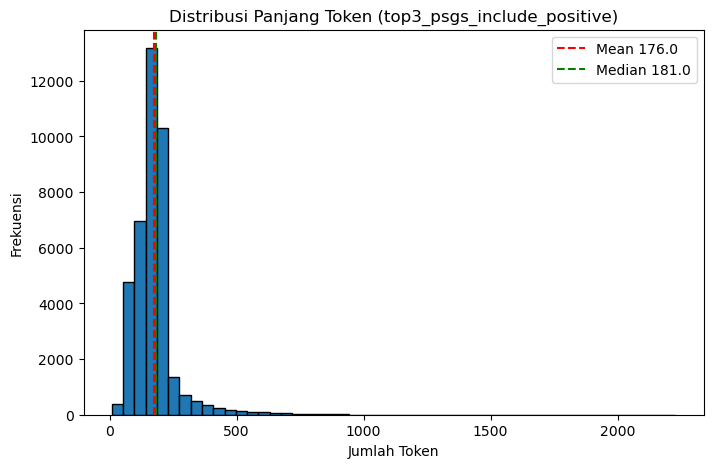

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm

# load tokenizer
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# ambil semua teks dari kolom top3_psgs_include_positive
all_texts = []
for row in all_ds["top3_psgs_include_positive"]:
    for item in row:
        all_texts.append(item["text"])

# hitung panjang token untuk tiap teks
token_lengths = []
for txt in tqdm(all_texts, desc="Tokenizing"):
    tokenized = t5_tokenizer(
        txt,
        truncation=False,
        add_special_tokens=True,
        return_attention_mask=False,
        return_token_type_ids=False,
    )
    token_lengths.append(len(tokenized["input_ids"]))

token_lengths = np.array(token_lengths)

# hitung statistik
stats = {
    "mean": np.mean(token_lengths),
    "median": np.median(token_lengths),
    "q25": np.percentile(token_lengths, 25),
    "q75": np.percentile(token_lengths, 75),
    "p10": np.percentile(token_lengths, 10),
    "p90": np.percentile(token_lengths, 90),
}

print("Statistik panjang token (flan-t5-base):")
for k, v in stats.items():
    print(f"{k}: {v:.2f}")

# visualisasi distribusi
plt.figure(figsize=(8,5))
plt.hist(token_lengths, bins=50, edgecolor="black")
plt.axvline(stats["mean"], color="red", linestyle="--", label=f"Mean {stats['mean']:.1f}")
plt.axvline(stats["median"], color="green", linestyle="--", label=f"Median {stats['median']:.1f}")
plt.title("Distribusi Panjang Token (top3_psgs_include_positive)")
plt.xlabel("Jumlah Token")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from tqdm import tqdm

# tokenizer
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# 1) Kumpulkan (row_id, top3_index, text, is_positive)
triples = []  # (row_id, k, text, is_positive)
ids = all_ds["id"] if "id" in all_ds.column_names else list(range(len(all_ds)))
top3_col = all_ds["top3_psgs_include_positive"]

for row_id, items in zip(ids, top3_col):
    if not isinstance(items, list):
        continue
    for k, d in enumerate(items):
        if not isinstance(d, dict):
            continue
        txt = d.get("text", "")
        is_pos = bool(d.get("is_positive", False))
        if isinstance(txt, str) and txt.strip():
            triples.append((row_id, k, txt, is_pos))

# 2) Tokenisasi batch dan hitung panjang token
texts = [t[2] for t in triples]
enc = t5_tokenizer(
    texts,
    add_special_tokens=True,   # hitung panjang dengan special tokens
    truncation=False,
    padding=False,
    return_attention_mask=False,
    return_token_type_ids=False,
)

lens = [len(ids) for ids in enc["input_ids"]]

# 3) Filter > 300 token
rows = []
for (row_id, k, txt, is_pos), L in zip(triples, lens):
    if L > 300:
        rows.append({
            "id": row_id,
            "top3_index": k,           # posisi dalam top3 (0=skor tertinggi)
            "token_len": L,
            "is_positive": is_pos,
            "text": txt,
        })

# 4) Lihat hasil
df_long = pd.DataFrame(rows).sort_values(["token_len"], ascending=False)
print("Jumlah passage > 300 token:", len(df_long))
print(df_long.head(10))

Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


Jumlah passage > 300 token: 2108
                           id  top3_index  token_len  is_positive  \
496      509381553604953491-0           0       2228        False   
1091   -4891423765760330169-2           2       1643        False   
411     3729667736221810738-0           2       1572        False   
1831    3610370681884974807-0           2       1490        False   
257     2792667802436251792-0           2       1430        False   
1729   -6294291492927048707-1           2       1358        False   
1829    2162058776019169335-2           2       1287        False   
489   -7657914863939360573-30           1       1282        False   
2047    3105168833694610114-2           2       1244        False   
1962    -302008274795995573-1           0       1244        False   

                                                   text  
496   Sejarah Nusantara pada era kerajaan Hindu-Budd...  
1091  Jujun Junaedi | Sejak usianya baru empat tahun...  
411   Teknologi komunikasi permai

In [201]:
# (opsional) simpan ke CSV untuk inspeksi manual
df_long.to_excel("top3_include_positive_over300.xlsx", index=False)

In [202]:
row = all_ds.filter(lambda x: x['id']=='509381553604953491-0')
print("positive:",row['positive_passage'])

Filter: 100%|██████████| 13154/13154 [00:01<00:00, 6754.42 examples/s]

positive: ['Borobudur | Borobudur adalah sebuah candi Buddha yang terletak di Borobudur, Magelang, Jawa Tengah, Indonesia. Candi ini terletak kurang lebih 100 km di sebelah barat daya Semarang, 86 km di sebelah barat Surakarta, dan 40 km di sebelah barat laut Yogyakarta. Candi berbentuk stupa ini didirikan oleh para penganut agama Buddha Mahayana sekitar tahun 800-an Masehi pada masa pemerintahan wangsa Syailendra. Borobudur adalah candi atau kuil Buddha terbesar di dunia, sekaligus salah satu monumen Buddha terbesar di dunia.']


In [204]:
for item in row['top3_psgs_include_positive'][0]:
    print(item['text'])

Sejarah Nusantara pada era kerajaan Hindu-Buddha | 101- Penempatan Lembah Bujang yang menggunakan aksara Sanskrit Pallava membuktikan hubungan dengan India di Sungai Batu. 150- Kerajaan Salakanagara, berdasarkan Naskah Wangsakerta- Pustaka Rajyarajya i Bhumi Nusantara (yang disusun sebuah panitia dengan ketuanya Pangeran Wangsakerta) diperkirakan merupakan kerajaan paling awal yang ada di Nusantara. 300- Kerajaan-kerajaan di asia tenggara telah melakukan hubungan dagang dengan India. Hubungan dagang ini mulai intensif pada abad ke-2 M. Memperdagangkan barang-barang dalam pasaran internasional misalnya: logam mulia, perhiasan, kerajinan, wangi-wangian, obat-obatan. Dari sebelah timur Indonesia diperdagangkan kayu cendana, kapur barus, cengkeh. Hubungan dagang ini memberi pengaruh yang besar dalam masyarakat Indonesia, terutama dengan masuknya ajaran Hindu dan Budha, pengaruh lainnya terlihat pada sistem pemerintahan. 300- Telah dilakukannya hubungan pelayaran niaga yang melintasi Tiongk

In [2]:
from transformers import AutoTokenizer

t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

def _concat_top3_texts(batch):
    """
    Buat gabungan teks dari kolom top3_psgs_include_positive (list[dict/text]) per-baris,
    lalu hitung panjang token dengan T5-base (tanpa truncation).
    """
    concat_texts = []
    for items in batch["top3_psgs_include_positive"]:
        texts = []
        if isinstance(items, list):
            for it in items:
                if isinstance(it, dict):
                    txt = it.get("text", "")
                else:
                    txt = it
                if isinstance(txt, str) and txt.strip():
                    texts.append(txt.strip())
        # gabungkan dengan spasi (bisa diganti "\n\n" jika ingin separator lebih jelas)
        concat_texts.append(" ".join(texts) if texts else "")

    enc = t5_tokenizer(
        concat_texts,
        add_special_tokens=True,
        truncation=False,
        padding=False,
        return_attention_mask=False,
        return_token_type_ids=False,
    )
    lengths = [len(ids) for ids in enc["input_ids"]]
    return {"_top3_concat_text": concat_texts, "_top3_concat_len": lengths}

# Tambahkan kolom bantu berisi gabungan teks & panjang token
all_ds_tmp = all_ds.map(
    _concat_top3_texts,
    batched=True,
    batch_size=512,
    load_from_cache_file=False,
    desc="Concat + token length (top3_psgs_include_positive)"
)

# Filter: hanya baris dengan total token <= 850
all_ds_filtered = all_ds_tmp.filter(lambda ex: ex["_top3_concat_len"] <= 850)

# (opsional) hapus kolom bantu
all_ds_filtered = all_ds_filtered.remove_columns(["_top3_concat_text", "_top3_concat_len"])

print(all_ds_filtered)

Concat + token length (top3_psgs_include_positive):   0%|          | 0/13154 [00:00<?, ? examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Concat + token length (top3_psgs_include_positive): 100%|██████████| 13154/13154 [00:03<00:00, 3998.07 examples/s]
Filter: 100%|██████████| 13154/13154 [00:01<00:00, 7736.86 examples/s]

Dataset({
    features: ['id', 'question', 'answer', 'positive_passage', 'question_norm', 'question_stem', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive'],
    num_rows: 12504
})


In [3]:
all_texts = []
for row in all_ds_filtered["top3_psgs_include_positive"]:
    for item in row:
        all_texts.append(item["text"])

# hitung panjang token untuk tiap teks
token_lengths = []
for txt in tqdm(all_texts, desc="Tokenizing"):
    tokenized = t5_tokenizer(
        txt,
        truncation=False,
        add_special_tokens=True,
        return_attention_mask=False,
        return_token_type_ids=False,
    )
    token_lengths.append(len(tokenized["input_ids"]))

token_lengths = np.array(token_lengths)

# hitung statistik
stats = {
    "mean": np.mean(token_lengths),
    "median": np.median(token_lengths),
    "q25": np.percentile(token_lengths, 25),
    "q75": np.percentile(token_lengths, 75),
    "p10": np.percentile(token_lengths, 10),
    "p90": np.percentile(token_lengths, 90),
}

print("Statistik panjang token (flan-t5-base):")
for k, v in stats.items():
    print(f"{k}: {v:.2f}")

# visualisasi distribusi
plt.figure(figsize=(8,5))
plt.hist(token_lengths, bins=50, edgecolor="black")
plt.axvline(stats["mean"], color="red", linestyle="--", label=f"Mean {stats['mean']:.1f}")
plt.axvline(stats["median"], color="green", linestyle="--", label=f"Median {stats['median']:.1f}")
plt.title("Distribusi Panjang Token (top3_psgs_include_positive)")
plt.xlabel("Jumlah Token")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()

NameError: name 'tqdm' is not defined

In [4]:
all_ds_filtered.save_to_disk("./generated_data/all_ds_concat_psgs_under_850")

Saving the dataset (1/1 shards): 100%|██████████| 12504/12504 [00:00<00:00, 36372.30 examples/s]


In [25]:
all_ds_filtered = load_from_disk("./generated_data/all_ds_concat_psgs_under_850")

In [26]:
import pandas as pd

# convert ke pandas dataframe
df = all_ds_filtered.to_pandas()

# ambil elemen pertama dari answer (asumsikan answer selalu list dengan ≥1 elemen)
df["_answer_first"] = df["answer"].apply(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) > 0 else None)

# panjang positive_passage
df["_pos_len"] = df["positive_passage"].astype(str).str.len()

# sort agar yg terpendek muncul dulu
df_sorted = df.sort_values(by="_pos_len", ascending=True)

# drop_duplicates mempertahankan yg pertama (terpendek)
df_dedup = df_sorted.drop_duplicates(subset=["question_stem", "_answer_first"], keep="first").reset_index(drop=True)

print(f"Sebelum dedup: {len(df)} baris")
print(f"Sesudah dedup: {len(df_dedup)} baris")

# simpan hasil
df_dedup.to_excel("dedup_shortest_positive.xlsx", index=False)


Sebelum dedup: 12504 baris
Sesudah dedup: 12385 baris


In [27]:
all_ds_filtered = Dataset.from_pandas(df_dedup, preserve_index=False)

In [28]:
def check_positive_contains_answer(batch):
    results = []
    for answers, top3 in zip(batch["answer"], batch["top3_psgs_include_positive"]):
        # ambil teks positif (kalau ada)
        pos_texts = [d["text"] for d in top3 if d.get("is_positive")]
        if not pos_texts:
            # kalau tidak ada positive, hitung sebagai gagal
            results.append(False)
            continue

        pos_text = pos_texts[0]  # asumsi cuma ada satu positive
        # cek semua answer ada dalam teks positive
        ok = all(ans.strip() in pos_text for ans in answers if ans.strip())
        results.append(ok)
    return {"_pos_has_all_answers": results}

# Tambahkan kolom cek
all_ds_checked = all_ds_filtered.map(
    check_positive_contains_answer,
    batched=True,
    batch_size=512,
    load_from_cache_file=False,
    desc="Check positive passage contains all answers"
)

# Hitung statistik
total = len(all_ds_checked)
n_fail = sum(1 for x in all_ds_checked["_pos_has_all_answers"] if not x)
percent_fail = (n_fail / total) * 100 if total > 0 else 0.0

print(f"Total baris: {total}")
print(f"Baris di mana positive_passage tidak mengandung semua answer: {n_fail}")
print(f"Persentase: {percent_fail:.2f}%")

Check positive passage contains all answers: 100%|██████████| 12385/12385 [00:00<00:00, 15500.83 examples/s]

Total baris: 12385
Baris di mana positive_passage tidak mengandung semua answer: 0
Persentase: 0.00%


In [29]:
from collections import Counter

def get_positive_index(batch):
    indices = []
    for top3 in batch["top3_psgs_include_positive"]:
        idx = None
        for i, d in enumerate(top3):
            if d.get("is_positive"):
                idx = i
                break   # ambil yang pertama ketemu
        indices.append(idx)
    return {"_positive_index": indices}

# Tambahkan kolom indeks
all_ds_with_idx = all_ds_filtered.map(
    get_positive_index,
    batched=True,
    batch_size=512,
    load_from_cache_file=False,
    desc="Cari posisi is_positive=True"
)

# Hitung distribusi
total = len(all_ds_with_idx)
ctr = Counter(x for x in all_ds_with_idx["_positive_index"] if x is not None)

for i in range(3):
    n = ctr.get(i, 0)
    p = (n / total) * 100 if total > 0 else 0
    print(f"Index {i}: {n} baris ({p:.2f}%)")

n_none = sum(1 for x in all_ds_with_idx["_positive_index"] if x is None)
if n_none:
    p_none = (n_none / total) * 100
    print(f"Tidak ada positive: {n_none} baris ({p_none:.2f}%)")

Cari posisi is_positive=True: 100%|██████████| 12385/12385 [00:00<00:00, 18458.65 examples/s]


Index 0: 9375 baris (75.70%)
Index 1: 889 baris (7.18%)
Index 2: 2121 baris (17.13%)


In [ ]:
import random
from datasets import Dataset

random.seed(42)  # untuk konsistensi

# 1. Tandai index posisi positive
def get_positive_index(example):
    for i, d in enumerate(example["top3_psgs_include_positive"]):
        if d.get("is_positive"):
            return i
    return None

pos_indices = [get_positive_index(ex) for ex in all_ds_filtered]

# 2. Ambil id baris untuk setiap grup
idx0 = [i for i, p in enumerate(pos_indices) if p == 0]
idx1 = [i for i, p in enumerate(pos_indices) if p == 1]
idx2 = [i for i, p in enumerate(pos_indices) if p == 2]

print(len(idx0), len(idx1), len(idx2))  # 9404, 892, 2208

# 3. Tentukan jumlah target
keep0 = 4129
move1 = 3239
move2 = 2007

# 4. Acak idx0 dan bagi
random.shuffle(idx0)
idx0_keep = idx0[:keep0]
idx0_to1  = idx0[keep0:keep0+move1]
idx0_to2  = idx0[keep0+move1:keep0+move1+move2]

# 5. Buat set target index
target_pos = {}
for i in idx0_keep:
    target_pos[i] = 0
for i in idx0_to1:
    target_pos[i] = 1
for i in idx0_to2:
    target_pos[i] = 2
# sisanya (idx1, idx2) biarkan tetap

# 6. Fungsi swap posisi positive
def reposition_positive(example, idx):
    target = target_pos.get(idx, None)
    if target is None:
        return example  # tidak diubah

    top3 = example["top3_psgs_include_positive"]
    pos_idx = None
    for i, d in enumerate(top3):
        if d.get("is_positive"):
            pos_idx = i
            break

    if pos_idx is not None and pos_idx != target and target < len(top3):
        # tukar elemen pos_idx dengan elemen target
        top3[pos_idx], top3[target] = top3[target], top3[pos_idx]

    example["top3_psgs_include_positive"] = top3
    return example

# 7. Terapkan mapping dengan enumerate dataset
all_ds_balanced = all_ds_filtered.map(
    lambda ex, idx: reposition_positive(ex, idx),
    with_indices=True,
    load_from_cache_file=False,
    desc="Reposition positives"
)


9375 889 2121


Reposition positives: 100%|██████████| 12385/12385 [00:02<00:00, 4313.40 examples/s]


In [31]:
all_ds_balanced

Dataset({
    features: ['id', 'question', 'answer', 'positive_passage', 'question_norm', 'question_stem', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', '_answer_first', '_pos_len'],
    num_rows: 12385
})

In [32]:
def get_positive_index(batch):
    indices = []
    for top3s in batch["top3_psgs_include_positive"]:
        idx = None
        for i, d in enumerate(top3s):
            if d.get("is_positive"):
                idx = i
                break
        indices.append(idx)
    return {"_positive_index": indices}

all_ds_with_idx = all_ds_balanced.map(
    get_positive_index,
    batched=True,
    batch_size=512,
    load_from_cache_file=False,
    desc="Cek distribusi ulang posisi is_positive=True"
)


Cek distribusi ulang posisi is_positive=True: 100%|██████████| 12385/12385 [00:00<00:00, 16736.08 examples/s]


In [33]:
# Hitung distribusi
total = len(all_ds_with_idx)
ctr = Counter(x for x in all_ds_with_idx["_positive_index"] if x is not None)

for i in range(3):
    n = ctr.get(i, 0)
    p = (n / total) * 100 if total > 0 else 0
    print(f"Index {i}: {n} baris ({p:.2f}%)")

n_none = sum(1 for x in all_ds_with_idx["_positive_index"] if x is None)
if n_none:
    p_none = (n_none / total) * 100
    print(f"Tidak ada positive: {n_none} baris ({p_none:.2f}%)")

Index 0: 4129 baris (33.34%)
Index 1: 4128 baris (33.33%)
Index 2: 4128 baris (33.33%)


In [34]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset, DatasetDict

# pastikan dataset punya kolom _positive_index
df = all_ds_with_idx.to_pandas()

# Step 1: ambil 2000 baris dulu untuk dev+test (stratified)
df_train, df_temp = train_test_split(
    df,
    test_size=2000,
    stratify=df["_positive_index"],
    random_state=42
)

# Step 2: dari df_temp (2000 baris), split jadi dev=1000 & test=1000 (stratified lagi)
df_dev, df_test = train_test_split(
    df_temp,
    test_size=1000,
    stratify=df_temp["_positive_index"],
    random_state=42
)

# Convert kembali ke HuggingFace Dataset
ds_train = Dataset.from_pandas(df_train, preserve_index=False)
ds_dev   = Dataset.from_pandas(df_dev, preserve_index=False)
ds_test  = Dataset.from_pandas(df_test, preserve_index=False)

# Gabungkan ke DatasetDict
dataset_splits = DatasetDict({
    "train": ds_train,
    "dev": ds_dev,
    "test": ds_test,
})

print(dataset_splits)
for split in dataset_splits:
    print(split, len(dataset_splits[split]))

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'positive_passage', 'question_norm', 'question_stem', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', '_answer_first', '_pos_len', '_positive_index'],
        num_rows: 10385
    })
    dev: Dataset({
        features: ['id', 'question', 'answer', 'positive_passage', 'question_norm', 'question_stem', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', '_answer_first', '_pos_len', '_positive_index'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'question', 'answer', 'positive_passage', 'question_norm', 'question_stem', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', '_answer_first', '_pos_len', '_positive_index'],
        num_rows: 1000
    })
})
train 10385
dev 1000
test 1000


In [35]:
dataset_splits.save_to_disk('./generated_data/all_ds_balanced')

Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 88725.15 examples/s] 


In [37]:
dataset_splits.push_to_hub('khalidrizki/indonesian-qa-and-info-retrieval')

Creating parquet from Arrow format: 100%|██████████| 11/11 [00:00<00:00, 29.36ba/s]
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 30.05ba/s]
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 28.83ba/s]
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/khalidrizki/indonesian-qa-and-info-retrieval/commit/ee323e73d3859fa9753c3752a87af4fa804b6503', commit_message='Upload dataset', commit_description='', oid='ee323e73d3859fa9753c3752a87af4fa804b6503', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/khalidrizki/indonesian-qa-and-info-retrieval', endpoint='https://huggingface.co', repo_type='dataset', repo_id='khalidrizki/indonesian-qa-and-info-retrieval'), pr_revision=None, pr_num=None)

In [39]:
for split in dataset_splits.keys():
    dataset_splits[split] = dataset_splits[split].remove_columns(['_answer_first', '_pos_len'])
dataset_splits

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'positive_passage', 'question_norm', 'question_stem', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', '_positive_index'],
        num_rows: 10385
    })
    dev: Dataset({
        features: ['id', 'question', 'answer', 'positive_passage', 'question_norm', 'question_stem', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', '_positive_index'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'question', 'answer', 'positive_passage', 'question_norm', 'question_stem', 'retrieved_top3', 'top3_psgs_include_positive', 'top3_psgs_may_not_include_positive', '_positive_index'],
        num_rows: 1000
    })
})

In [42]:
import pandas as pd

def distribusi_per_segmen(ds, col="_positive_index", seg_size=1000):
    df = ds.to_pandas()
    n = len(df)
    print(f"\n=== Split: {ds.split} (total {n} baris) ===")
    for start in range(0, n, seg_size):
        end = min(start + seg_size, n)
        counts = df[col].iloc[start:end].value_counts(normalize=True).sort_index()
        counts_abs = df[col].iloc[start:end].value_counts().sort_index()
        print(f"Baris {start}–{end}:")
        for idx in sorted(counts_abs.index):
            print(f"  {idx}: {counts_abs[idx]} ({counts[idx]*100:.2f}%)")
        print()

# jalankan untuk semua split
for split in dataset_splits.keys():
    ds = dataset_splits[split]   # biar tampil nama split
    distribusi_per_segmen(ds, col="_positive_index", seg_size=1000)



=== Split: None (total 10385 baris) ===
Baris 0–1000:
  0: 333 (33.30%)
  1: 350 (35.00%)
  2: 317 (31.70%)

Baris 1000–2000:
  0: 311 (31.10%)
  1: 331 (33.10%)
  2: 358 (35.80%)

Baris 2000–3000:
  0: 348 (34.80%)
  1: 340 (34.00%)
  2: 312 (31.20%)

Baris 3000–4000:
  0: 326 (32.60%)
  1: 348 (34.80%)
  2: 326 (32.60%)

Baris 4000–5000:
  0: 326 (32.60%)
  1: 325 (32.50%)
  2: 349 (34.90%)

Baris 5000–6000:
  0: 339 (33.90%)
  1: 333 (33.30%)
  2: 328 (32.80%)

Baris 6000–7000:
  0: 346 (34.60%)
  1: 321 (32.10%)
  2: 333 (33.30%)

Baris 7000–8000:
  0: 332 (33.20%)
  1: 327 (32.70%)
  2: 341 (34.10%)

Baris 8000–9000:
  0: 326 (32.60%)
  1: 333 (33.30%)
  2: 341 (34.10%)

Baris 9000–10000:
  0: 340 (34.00%)
  1: 331 (33.10%)
  2: 329 (32.90%)

Baris 10000–10385:
  0: 135 (35.06%)
  1: 122 (31.69%)
  2: 128 (33.25%)


=== Split: None (total 1000 baris) ===
Baris 0–1000:
  0: 333 (33.30%)
  1: 334 (33.40%)
  2: 333 (33.30%)


=== Split: None (total 1000 baris) ===
Baris 0–1000:
  0:

In [43]:
dataset_splits.push_to_hub('khalidrizki/indonesian-qa-and-info-retrieval')

Creating parquet from Arrow format: 100%|██████████| 11/11 [00:00<00:00, 32.91ba/s]
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 27.58ba/s]
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 25.75ba/s]
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Uploading the dataset shards: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/khalidrizki/indonesian-qa-and-info-retrieval/commit/5c6b5f6d86dc33f866cce4bb1f39085547c46cce', commit_message='Upload dataset', commit_description='', oid='5c6b5f6d86dc33f866cce4bb1f39085547c46cce', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/khalidrizki/indonesian-qa-and-info-retrieval', endpoint='https://huggingface.co', repo_type='dataset', repo_id='khalidrizki/indonesian-qa-and-info-retrieval'), pr_revision=None, pr_num=None)